# Exam 1

from datascience import *
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Lecture 7: Charts ##

full = Table.read_table('../Datasets/nc-est2014-agesex-res.csv')

### How to filter for only the columns we want 
partial = full.select('SEX', 'AGE', 'CENSUS2010POP', 'POPESTIMATE2014')

### How to rename columns 
simple = partial.relabeled(2, '2010').relabeled(3, '2014')

### Cleaning the data further
no_999 = simple.where('AGE', are.below(999))

### How to remove a specific sesion of data 
everyone = no_999.where('SEX', 0).drop('SEX') # This removes where the SEX column = 0 

### Line plots 
everyone.plot('AGE', '2010')
plots.title('US Population');

### Line plots for different years 
everyone.plot('AGE')
plots.title('US Population'); # This will make a line for each age column

vgsales = Table.read_table('../Datasets/vgsales.csv')

### Sort Bar Chart Data in Order 
### Descending and Ascending order
top10_NA_Sales = vgsales.sort('NA_Sales', descending=True).take(np.arange(10))

### Bar Chart Creation
top10_NA_Sales.barh('Name', 'NA_Sales')

## Lecture 8: Histograms ##

### How to group by categorical variables 
genre_dist = vgsales.select('Genre').group('Genre')

### How to make a descending bar chart by categorical variable 
genre_dist.sort('count', descending=True).barh('Genre')

### HOW TO BIN DATA 
    # Find the Min and Max values 
years_since = 2022 - vgsales.column('Year')
vgsales = vgsales.with_column('Years Since Release', years_since)
min(years_since), max(years_since)
    # Create an array based on the min and max of the data
my_bins = make_array(0, 5, 10, 15, 20, 30, 43) # Note: Include one more than the max, to include the max 
    # Put it all together 
binned_data = vgsales.bin('Years Since Release', bins = my_bins)
binned_data

### Alternate Bin data
vgsales.bin('Years Since Release', bins = np.arange(0, 50, 5))

#Histograms 
vgsales.hist('Years Since Release', bins = my_bins)
vgsales.hist('Years Since Release', bins = np.arange(0, 45, 5))

### How to find the percentage of something in each bin 
binned_data = binned_data.with_column(
    'Percent', 100*binned_data.column('Years Since Release count')/sum(binned_data.column('Years Since Release count')))
binned_data

### How to find the height of a bin
    # Step 1: Calculate % of games in the [20, 30) bin
percent = binned_data.where('bin', 20).column('Percent').item(0)
    # Step 2: Calculate the width of the 20-30 bin
width = 30 - 20
    # Step 3: Area of rectangle = height * width
    #         --> height = percent / width
height = percent / width
height

## Lecture 9: Functions ##

def triple(x):
    return 3 * x # This doesn't care what type x is, it will triple it regardless

### The Apply Function 
sleep.apply(np.average, 'AverageSleep') # Applies the average function to every entry in the AverageSleep column

## Lecture 10: Groups ##

insurance = Table.read_table('../Datasets/insurance_charges.csv')

### How to make a scatter plot
insurance.scatter('bmi', 'charges')

### How to make a scatter plot grouped by one variable
insurance.scatter('bmi', 'charges', group = 'smoker')

### How to filter a scatterplot 
insurance_smoker = insurance.where('smoker', 'yes')
insurance_smoker.scatter('bmi', 'charges')

### How to draw a line on a scatterplot
insurance_smoker.scatter('bmi', 'charges')
plots.plot([35, 35], [15000, 65000], color='red', lw=2);

### How to calculate mean 
nearby = insurance_smoker.where('bmi', are.between(34, 36))
nearby_mean = np.mean(nearby.column('charges'))

### How to plot the mean onto a scatter plot 
insurance_smoker.scatter('bmi', 'charges')
plots.scatter(35, nearby_mean, color='red', s=50); # s = size; makes the point a little bigger

### Creating a function to find the average bmi charge for specific bmis
def predict(bmi):
    '''uses smokers bmi to predict hospital charges'''
    nearby = insurance_smoker.where('bmi', are.between(bmi -1 , bmi + 1))
    return np.mean(nearby.column('charges'))

### Get an array of predicted values 
predicted_charges = insurance_smoker.apply(predict, 'bmi')

### Adds the array to the dataset
insurance_smoker = insurance_smoker.with_column(
    'Predicted charges', predicted_charges)

### Creates a scatterplot that compares the actual charges vs the predicted charges 
### Scatterplot that compares predicted values to actual values 
insurance_smoker.select(
    'charges', 
    'bmi', 
    'Predicted charges'
).scatter('bmi')

cereal = Table.read_table('../Datasets/Cereal.csv')

### How to count how many of something are in a table 
cereal.group('Company')

### How to select categories and average by category 
cereal.select('Company', 'Calories').group('Company', np.average)

### How to average an entire table by group 
cereal.group('Company', np.average) # Note: Name is blank because "Name" = string class

sleep = Table.read_table('../Datasets/SleepStudy.csv').select(
    'ClassYear',
    'LarkOwl',
    'GPA', 
    'PoorSleepQuality', 
    'AverageSleep', 
    'Drinks'
)

### How to create a line graph of averages
by_Drinks = sleep.group('Drinks', np.average)
### Title: "GPA, PoorSleepQuality, and AverageSleep Averages\n by Number of Drinks Consumed"
by_Drinks.drop(1,2).plot('Drinks') # NOTE: We have to drop the first two columns b/c they have non-numeric data

### How to group by two columsn 
sleep.group(['ClassYear','LarkOwl']).show() # Basic grouping and count

sleep.group(['ClassYear','LarkOwl'], np.average).show() # Grouping and averaging

### Pivot tables 
sleep.pivot('ClassYear', 'LarkOwl')
### Same as sleep.group(['ClassYear','LarkOwl']).show(), but puts Class Year as the column group

### How to average a pivot table 
sleep.pivot('ClassYear', 'LarkOwl', values='Drinks', collect=np.average)
### Takes the average drinks of the subgroups 

## Lecture 11: Joins

### Creating the tables we will be working with 
drinks = Table().with_columns(
    'Drink', make_array('Milk Tea', 'Espresso', 'Latte', 'Espresso'),
    'Cafe', make_array('Asha', 'Strada', 'Strada', 'FSM'),
    'Price', make_array(5.5, 1.75, 3.25, 2)
)

discounts = Table().with_columns(
    'Coupon % off', make_array(10, 25, 5),
    'Location', make_array('Asha', 'Strada', 'Asha')
)

### How to join 
combined = drinks.join('Cafe', discounts, 'Location')
### table_column1.join("column 1", table the column 2 is from, and "column 2 that will be joined to column 1")
combined # This is a left join 

### You can also join the same table together to duplicate certain columns (still a left join)
drinks.join('Cafe', drinks, 'Cafe')

### Joins between three tables 
state_areas = Table.read_table('../Datasets/state-areas.csv')
state_pop = Table.read_table('../Datasets/state-population.csv')
state_abbrevs = Table.read_table('../Datasets/state-abbrevs.csv')

### What were the top 10 states with the lowest population per square mile in the year 2000?
join1 = state_areas.join("state", state_abbrevs, "state")
join1

### We want just for the year 2000
join2 = state_pop.where("year", are.equal_to(2000)).where("ages", "total")

total_states = join1.join("abbreviation", join2, "state/region")

total_states["population per square mile"] = total_states["population"]/total_states["area (sq. mi)"]

total_states.sort("population per square mile", descending = False)

## Class 12: Review 

Refer to class 12's document for additional notes 
- This is a really good resource!!


from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Lecture 12 Answers #

nba = Table.read_table('nba_salaries.csv')
sky = Table.read_table('skyscrapers_v2.csv')
billion = Table.read_table('billionaires.csv')

### Question 1

Construct a table of billionaires with United States citizenship, listed from highest net worth to lowest. The table should only include the name and net worth of the billionaires.

How many billionaires have United States citizenship?

US_billion = billion.where('citizenship', 'United States'
                          ).sort('net worth', descending=True
                                ).select('name', 'net worth')
US_billion

US_billion.num_rows

### Question 2

Add a column to the table from question 1 that lists the net worth in billions of dollars rather than dollars. Use this new column to construct a histogram for the net worth of billionaires with bins equal to 10 billion dollars. 

US_billion = US_billion.with_column(
    'net worth in billions', US_billion.column('net worth') / 1e9
)

US_billion.hist('net worth in billions', bins = np.arange(0, 130, 10))

### Question 3

Using the histogram from question 2, approximately what percentage of US billionaires have net worths of less than 10 billion dollars?

width = 10
approx_height = 6.75

Area = width * approx_height
Area

### Question 4

What is the average net worth of billionaires with a net worth below 10 billion dollars, in billions of dollars?

np.mean(billion.where('net worth', are.below(10000000000)).column('net worth'))/1000000000

### Question 5

Construct a bar plot for the counts of billions for each citizenship, from highest count to lowest, showing only the top 10 citizenships.

billion.group('citizenship'
             ).sort('count', descending=True
                   ).take(np.arange(0,10,1)
                         ).barh('citizenship'
                               )

### Question 6

Which NBA teams spent the most on their “starters” in 2015-2016?

Assume the “starter” for a team & position is the player with the highest salary on that team in that position.

nba2 = nba.drop('PLAYER').group(['TEAM', 'POSITION'], np.max)
nba3 = nba2.group('TEAM', np.sum).drop('POSITION sum')
nba4 = nba3.relabeled("'15-'16 SALARY amax sum", "'15-'16 SALARY").sort("'15-'16 SALARY", descending=True)
nba4.show(5)

### Question 7

Construct a scatter plot with the heights and years completed for the skyscrapers. Describe any trends in the data that you can see in the plot.

sky.scatter('height', 'completed')

More taller skyscrapers seem to be build as the data completed increases.

Very few skyscapers were built during the time periods of World War I and World War II.

Most skyscrapers appear to be below 100 meters in height.

### Question 8

Define a function that converts a length in meters to feet. Convert the heights of the skyscrapers in the table (initially in meters) to feet in the table and relabel the column height in feet.

def convert_m_ft(meters):
    return 3.28084 * meters

sky.apply(convert_m_ft, 'height')
sky = sky.with_column(
    'height in feet', 
    sky.apply(convert_m_ft, 'height')
).drop('height')

sky    

### Question 9
For each city, what’s the tallest building for each material?

sky.select('material', 'city', 'height in feet'
          ).group(['city', 'material'], max).show(5)

### Question 10
For each city, what’s the height difference (in feet) between the tallest steel building and the tallest concrete building?

sky_p = sky.pivot('material', 'city', 'height in feet', max)
sky_p.show()

sky_p = sky_p.with_column(
    'difference', 
    abs(sky_p.column('steel') - sky_p.column('concrete'))
)
sky_p.show(5)

sky_p.sort('difference', True)


# Exam 2 

from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

# Unit 4: Distributions and Random Sampling 

## Iteration 

## Chance

# Simulation 
    # Let's play a game: we each roll a die. 
    # If my number is bigger: you pay me a dollar.
    # If they're the same: we do nothing.
    # If your number is bigger: I pay you a dollar.
    
def one_round(my_roll, your_roll):
    if my_roll > your_roll:
        return 1
    elif your_roll > my_roll:
        return -1
    elif your_roll == my_roll:
        return 0
    
die_faces = np.arange(1, 7)

def simulate_one_round():
    my_roll = np.random.choice(die_faces)
    your_roll = np.random.choice(die_faces)
    return one_round(my_roll, your_roll)

game_outcomes = make_array()

for i in np.arange(10000):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)
results.group('My winnings').barh('My winnings')

# Monty Hall 
# Behind the door of our choice
doors = make_array('car', 'first goat', 'second goat')

# Our two goats
goats = make_array('first goat', 'second goat')

def other_goat(a_goat):
    """If we picked a goat, this returns the other goat"""
    
    if a_goat == 'first goat':
        return 'second goat'
    elif a_goat == 'second goat':
        return 'first goat'

other_goat('first goat')

def monty_hall():
    
    # randomly choose a door
    contestant_choice = ...
    
    # For the three possible choices
    # What does Monty show you?
    # What is remaining?
    
    if contestant_choice == ...:
        monty_choice = ...
        remaining_door = ...
        
    elif contestant_choice == ...:
        monty_choice = ...
        remaining_door = ...
        
    elif contestant_choice == ...:
        monty_choice = ...
        remaining_door = ...
        
    return make_array(contestant_choice, monty_choice, remaining_door)

games = Table(['Guess', 'Revealed', 'Remaining'])

games.append(monty_hall())

games = Table(['Guess', 'Revealed', 'Remaining'])

for i in range(10000):
    games.append(monty_hall())
    
games
# We get Ellipsis because we have to fill in the monty_hall code 

## Sampling

# Probability Distributions 
dice_game_prob = Table().with_columns(
    'My winnings', make_array(-1, 0, 1),
    'Probability', make_array(15/36, 6/36, 15/36)
)

dice_game_prob.barh('My winnings')

# Empirical Distributions 
def one_round(my_roll, your_roll):
    if my_roll > your_roll:
        return 1
    elif your_roll > my_roll:
        return -1
    elif your_roll == my_roll:
        return 0

die_faces = np.arange(1, 7)

def simulate_one_round():
    my_roll = np.random.choice(die_faces)
    your_roll = np.random.choice(die_faces)
    return one_round(my_roll, your_roll)

game_outcomes = make_array()

for i in np.arange(10000):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)

results.group('My winnings').barh('My winnings')

# Law of Large Numbers 
game_outcomes = make_array()

for i in np.arange(10):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)

results.group('My winnings').barh('My winnings')
dice_game_prob.barh('My winnings')

game_outcomes = make_array()

for i in np.arange(100):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)

results.group('My winnings').barh('My winnings')
dice_game_prob.barh('My winnings')

game_outcomes = make_array()

for i in np.arange(1000):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)

results.group('My winnings').barh('My winnings')
dice_game_prob.barh('My winnings')

game_outcomes = make_array()

for i in np.arange(10000):
    game_outcomes = np.append(game_outcomes, simulate_one_round())
    
results = Table().with_column('My winnings', game_outcomes)

results.group('My winnings').barh('My winnings')
dice_game_prob.barh('My winnings')

# Random Sampling 
music = Table.read_table('../../Unit4_Distributions_and_Random_Sampling/Datasets/music.csv')
music = music.with_column('Row', np.arange(music.num_rows)).move_to_start('Row')
music

music.where('genre', 'Rap') 

music.take(make_array(34, 6321, 10040))

music.take(np.arange(0, music.num_rows, 1000))

start = np.random.choice(np.arange(1000))
systematic_sample = music.take(np.arange(start, music.num_rows, 1000))
systematic_sample

# Large Random Samples 
music.hist('duration')

music_bins = np.arange(0, 800, 25)
music.hist('duration', bins=music_bins)

min(music.column('duration'))

max(music.column('duration'))

np.average(music.column('duration'))

music.sample(10).hist('duration', bins = music_bins)

music.sample(1000).hist('duration', bins = music_bins)

# Simulating Statistics 

np.median(music.column('duration'))

np.median(music.sample(10).column('duration'))

def sample_median(size):
    return np.median(music.sample(size).column('duration'))

sample_median(10)

sample_medians_array = make_array()

for i in np.arange(1000):
    new_median = sample_median(10)
    sample_medians_array = np.append(sample_medians_array, new_median)
    
Table().with_column(
    'Sample medians', sample_medians_array
).hist(bins = np.arange(120,350, 10))

sample_medians_array = make_array()

for i in np.arange(1000):
    new_median = sample_median(1000)
    sample_medians_array = np.append(sample_medians_array, new_median)
    
Table().with_column(
    'Sample medians', sample_medians_array
).hist(bins = np.arange(120,350, 10))


Table().with_column(
    'Sample medians', sample_medians_array
).hist(bins = np.arange(220,240, 1))

## Models

# Population Distribution and Parameter 
music = Table.read_table('../../Unit4_Distributions_and_Random_Sampling/Datasets/music.csv')
music_bins = np.arange(0, 800, 25)

# (Population) Probability Distribution
music.hist('duration', bins=music_bins)

# (Population) Parameter
np.median(music.column('duration'))

# Statistics 
# (Sample) Statistic
np.median(music.sample(10).column('duration'))

# (Sample) Statistic
np.median(music.sample(100).column('duration'))

# Empireical Distributions of a Statistic 
def sample_median(size):
    return np.median(music.sample(size).column('duration'))
sample_median(10)
num_simulations = 5000
sample_medians_array = make_array()

for i in np.arange(num_simulations):
    new_median = sample_median(10)
    sample_medians_array = np.append(sample_medians_array, new_median)
    
Table().with_column(
    'Sample medians', sample_medians_array
).hist(bins = np.arange(120,350, 10))

# Empirical Distibutions Overlayed 
sample_medians_array_10 = make_array()
sample_medians_array_100 = make_array()
sample_medians_array_1000 = make_array()

num_simulations = 5000

for i in np.arange(num_simulations):
    sample_medians_array_10 = np.append(
        sample_medians_array_10, 
        sample_median(10)
    )
    
    sample_medians_array_100 = np.append(
        sample_medians_array_100, 
        sample_median(100)
    )
    
    sample_medians_array_1000 = np.append(
        sample_medians_array_1000, 
        sample_median(1000)
    )
sample_medians = Table().with_columns('Size 10', sample_medians_array_10, 
                                      'Size 100', sample_medians_array_100,
                                      'Size 1000', sample_medians_array_1000)  
sample_medians.hist(bins = np.arange(170,300, 1))

# Mendel and Pea Flowers 
## Mendel had 929 plants, of which 709 had purple flowers
observed_purples = 709 / 929
observed_purples

abs(observed_purples * 100 - 75)

predicted_proportions = make_array(.75, .25)
sample_proportions(929, predicted_proportions)

def purple_flowers():
    return sample_proportions(929, predicted_proportions).item(0) * 100

purples = make_array()

for i in np.arange(10000):
    new_purple = purple_flowers()
    purples = np.append(purples, new_purple)

Table().with_column('Percent of purple flowers in sample of 929', purples).hist()
plots.plot([observed_purples*100, observed_purples*100], [0, .3], color='red', lw=2);

Table().with_column('Discrepancy in sample of 929 if the model is true', abs(purples- 75)).hist()
plots.plot([abs(observed_purples * 100 - 75), abs(observed_purples * 100 - 75)], [0, .6], color='red', lw=2);

Discrepancy = Table().with_column('Discrepancy in sample of 929 if the model is true', abs(purples- 75))
Discrepancy.where(
    'Discrepancy in sample of 929 if the model is true', 
    are.above_or_equal_to(abs(observed_purples * 100 - 75))
).num_rows / 10000

# Swain Vs Alabama 

population_proportions = make_array(.26, .74)
population_proportions

sample_proportions(100, population_proportions)

def panel_proportion():
    return sample_proportions(100, population_proportions).item(0)

panels = make_array()

num_simulations = 10000

for i in np.arange(num_simulations):
    new_panel = panel_proportion() * 100
    panels = np.append(panels, new_panel)
    
Table().with_column('Number of Black Men on Panel of 100', panels).hist(bins=np.arange(5.5,40.))
plots.plot([8, 8], [0, .1], color='red', lw=2);

Black_men_on_panel = Table().with_column('Number of Black Men on Panel of 100', panels)
Black_men_on_panel.where('Number of Black Men on Panel of 100', are.below(9)).num_rows / num_simulations

min(panels)

# Pvalue code 
np.count_nonzero(panels <= 8) / num_simulations

## Comparing Distributions 

# Alameda COuntry Jury Panels 
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

jury.barh('Ethnicity')

# Under the model, this is the true distribution of people
# from which the jurors are randomly sampled
model = jury.column('Eligible')
model

# Let's simulate a random draw of 1453 jurors from this distribution
simulated = sample_proportions(1453, model)
simulated

# The actual observed distribution (Panels) looks quite different
# from the simulation -- try running this several times to confirm!
jury_with_simulated = jury.with_column('Simulated', simulated)
jury_with_simulated

jury_with_simulated.barh('Ethnicity')

# Distance between Distributions

# In this case, we need to understand how each of the 5 categories
# differ from their expected values according to the model.

diffs = jury.column('Panels') - jury.column('Eligible')
jury_with_difference = jury.with_column('Difference', diffs)
jury_with_difference

# Total Variation Distance 
def tvd(dist1, dist2):
    return sum(abs(dist1 - dist2))/2

# The TVD of our observed data (Panels) from their expected values
# assuming the model is true (Eligbible)
obsvd_tvd = tvd(jury.column('Panels'), jury.column('Eligible'))
obsvd_tvd

# The TVD of a model simluation from its expected values
tvd(sample_proportions(1453, model), jury.column('Eligible'))

def simulated_tvd():
    return tvd(sample_proportions(1453, model), model)

tvds = make_array()

num_simulations = 10000
for i in np.arange(num_simulations):
    new_tvd = simulated_tvd()
    tvds = np.append(tvds, new_tvd)
    
title = 'Simulated TVDs (if model is true)'
bins = np.arange(0, .05, .005)

Table().with_column(title, tvds).hist(bins = bins)
plots.plot([obsvd_tvd, obsvd_tvd], [0, 50], color='red', lw=2);

# Example: Benford's Law 
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)

benford = Table().with_columns(
    'First digit', digits,
    'Benford Model Probability', benford_model)
benford.barh('First digit')

# You don't have to understand how this function works, 
# since it uses Python features from beyond STOR 120.
def first_digit(num):
    return int(str(num)[0])

first_digit(32)

# Benford's Law and COVID-19 Reporting 
COVID_by_digit = Table().with_columns(
    'First Digit', np.arange(1, 10),
    "Count", make_array(194, 106, 72, 51, 52, 38, 36, 22, 10)
)

COVID_by_digit

COVID_by_digit = COVID_by_digit.with_column(
    'Proportion', COVID_by_digit.column('Count') / sum(COVID_by_digit.column('Count'))
)

COVID_by_digit

COVID_observed_tvd = sum(abs(COVID_by_digit.column('Proportion') - benford_model))/2
COVID_observed_tvd

def simulate_COVID_count_first_digits():
    simulated_frequencies = sample_proportions(sum(COVID_by_digit.column('Count')), benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

COVID_simulated_tvds = make_array()

for i in np.arange(10000):
    COVID_simulated_tvds = np.append(COVID_simulated_tvds, simulate_COVID_count_first_digits())

COVID_bins = np.arange(0, 0.10, 0.005)

Table().with_column('COVID Simulated TVD', COVID_simulated_tvds).hist(0, bins = COVID_bins)
plots.plot([COVID_observed_tvd, COVID_observed_tvd], [0, 30], color='red', lw=2);

# Pvalue COde 
np.count_nonzero(COVID_simulated_tvds >= COVID_observed_tvd) / 10000
    

# Unit 5: Testing Statistical Hypotheses

## Unit 5: Homework 7

# Homework 7: Testing Hypotheses

**Reading**: 
* [Testing Hypotheses](https://www.inferentialthinking.com/chapters/11/Testing_Hypotheses.html)

## 1. Spam Calls


## Part 1: 585 Fun

Dr. McLean gets a lot of spam calls. An area code is defined to be a three digit number from 200-999 inclusive. In reality, many of these area codes are not in use. Of these possible numbers, there are currently 317 geographical US area codes (there are others not based on geography). 

**Throughout these questions, you should assume that Dr. McLean's area code is 585 (Rochester NY, home of the [garbage plate](https://www.visitrochester.com/blog/post/rochester-garbage-plate/)).**

**Question 1.** Assuming each area code is just as likely as any other, what's the probability that the area code of two back to back spam calls are 585?


<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

prob_585 = (1/317)*(1/317)
prob_585

**Question 2.** Peter already knows that Dr. McLean's area code is 585. Peter randomly guesses the last 7 digits (0-9 inclusive) of his phone number. What's the probability that Peter correctly guesses Dr. McLean's number, assuming that he’s equally likely to choose any digit? Assume that any digit is possible in any position of the phone number (in reality, this is not the case).

*Note: A phone number contains an area code and 7 additional digits, i.e. xxx-xxx-xxxx*

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

prob_mclean_num = (1/10)**7
prob_mclean_num

Dr. McLean suspects that there's a higher chance that the spammers are using his area code (585) to trick him into thinking it's someone from his area calling him. Stephanie thinks that this is not the case, and that spammers are just choosing area codes of the spam calls at random from all 317 possible US geographical area codes. Dr. McLean wants to test his claim using the 50 spam calls he received in the past month.

Here's a dataset of the area codes of the 50 spam calls he received in the past month.

Just run this cell
spam = Table().read_table('../Datasets/spam.csv')
spam

**Question 3.** Define the null hypothesis and alternative hypothesis for this investigation. 

*Hint: Don’t forget that your null hypothesis should fully describe a probability model that we can use for simulation later.*


<!--
BEGIN QUESTION
name: q1_3
manual: true
-->
<!-- EXPORT TO PDF -->

Ho: Spammers use familiar area codes
Ha: Spammers use random area codes, AKA Spammers do not use familiar area codes

**Question 4.** Which of the following test statistics would be a reasonable choice to help differentiate between the two hypotheses?

*Hint*: For a refresher on choosing test statistics, check out the textbook section on [Test Statistics](https://inferentialthinking.com/chapters/11/3/Decisions_and_Uncertainty.html#step-2-the-test-statistic).

1. The proportion of area codes that are 585 in 50 random spam calls
2. The total variation distance (TVD) between probability distribution of randomly chosen area codes, and the observed distribution of area codes. (*Remember the possible area codes are 200-999 inclusive*)
3. The probability of getting an area code of 585 out of all the possible area codes.
4. The proportion of area codes that are 585 in 50 random spam calls divided by 2
5. The number of times you see the area code 585 in 50 random spam calls

Assign `reasonable_test_statistics` to an array of numbers corresponding to these test statistics.

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

reasonable_test_statistics = 2

**For the rest of this question, suppose you decide to use the number of times you see the area code 585 in 50 spam calls as your test statistic.**

**Question 5.** 
Write a function called `simulate` that generates exactly one simulated value of your test statistic under the null hypothesis.  It should take no arguments and simulate 50 area codes under the assumption that each area code is sampled with equal probability. The `AreaCodes` table contains all US geographical area codes. Your function should return the number of times you saw the 585 area code in those 50 random spam calls.


<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

import pandas as pd 

AreaCodes = Table.read_table('../Datasets/AreaCodes.csv')
AreaCodes_df = pd.read_csv('../Datasets/AreaCodes.csv')

Making sure things work before putting them into a function 
 rand_sample = AreaCodes_df.sample(50).reset_index()
 Count how many times this sample has the value 585 
points = 0 
for x in np.arange(0, len(rand_sample), 1):
     if rand_sample["Area Code"][x] == 585:
         points = points + 1
 points

We want a function, that takes no arguments 
 IT should sample something 50 times, and count how many times it sees the area code 585

def simulate():
    rand_sample = AreaCodes_df.sample(50).reset_index()
    # Count how many times this sample has the value 585 
    points = 0 
    for x in np.arange(0, len(rand_sample), 1):
        if rand_sample["Area Code"][x] == 585:
            points = points + 1
    return points
        
    
Call your function to make sure it works
simulate()

**Question 6.** Generate 20,000 simulated values of the number of times you see the area code 585 in 50 random spam calls. Assign `test_statistics_under_null` to an array that stores the result of each of these trials. 

*Hint*: Use the function you defined in Question 5.

<!--
BEGIN QUESTION
name: q1_6
manual: false
-->

test_statistics_under_null = []
repetitions = 20000

for i in np.arange(repetitions):
    test_statistics_under_null.append(simulate())

    
sum(test_statistics_under_null)

**Question 7.** Using the results from Question 6, generate a histogram of the empirical distribution of the number of times you saw the area code 585 in your simulation. **NOTE: Use the provided bins when making the histogram**

<!--
BEGIN QUESTION
name: q1_7
manual: true
-->
<!-- EXPORT TO PDF -->

bins = np.arange(0,5,1) # Use these provided bins
Table().with_column("Sample Test", test_statistics_under_null).hist(bins = bins)

This says that the majority of the time, it only shows up once in a set of 50 calls 

**Question 8.** Compute an empirical P-value for this test.


<!--
BEGIN QUESTION
name: q1_8
manual: false
-->

import math as math 
First calculate the observed value of the test statistic from the `spam` table.
observed_val = sum(test_statistics_under_null)
print(observed_val)
expected_value = (1/317) # Probability of 585 number in one call
print(expected_value)
pvalue = (observed_val - expected_value)/repetitions
pvalue

**Question 9.** Suppose you use a P-value cutoff of 1%. What do you conclude from the hypothesis test? Why?

<!--
BEGIN QUESTION
name: q1_9
manual: true
-->
<!-- EXPORT TO PDF -->

Since the p-value is greater than the alpha, we fail to reject the null hypothesis.

## Part 2: Multiple Spammers

Instead of checking if the area code is equal to his own, Dr. McLean decides to check if the area code matches the area code of one of the 8 places he's been to recently, and wants to test if it's more likely to receive a spam call with an area code from any of those 8 places. These are the area codes of the places he's been to recently: 585, 919, 910, 315, 607, 707, 610, 864.

##### **Question 10.** Define the null hypothesis and alternative hypothesis for this investigation.

*Reminder: Don’t forget that your null hypothesis should fully describe a probability model that we can use for simulation later.*


<!--
BEGIN QUESTION
name: q1_10
manual: true
-->
<!-- EXPORT TO PDF -->

Ho: Dr.McLean will have more calls from 585, 919, 910, 315, 607, 707, 610, and 864 area code spammer calls 

Ha: Dr.McLean will not have more calls from 585, 919, 910, 315, 607, 707, 610, and 864 area code spammer calls 

**Suppose you decide to use the number of times you see any of the area codes of the places Dr. McLean has been to in 50 spam calls as your test statistic.**

**Question 11.** 
Write a function called `simulate_visited_area_codes` that generates exactly one simulated value of your test statistic under the null hypothesis. It should take no arguments and return the number of times that you saw any of the area codes of the places Dr. McLean has been to in those 50 spam calls (under the assumption that the calls come from the 317 US geographical area codes with equal probability).
 

*Hint*: You may find the textbook [section](https://inferentialthinking.com/chapters/11/1/Assessing_a_Model.html#simulating-one-value-of-the-statistic) on the `sample_proportions` function to be useful.

<!--
BEGIN QUESTION
name: q1_11
manual: false
-->

model_proportions = ...
def simulate_visited_area_codes():
    rand_sample = AreaCodes_df.sample(50).reset_index()
    # Count how many times this sample has the value 585 
    points = 0 
    for x in np.arange(0, len(rand_sample), 1):
        if rand_sample["Area Code"][x] == 585 or rand_sample["Area Code"][x] == 919 or rand_sample["Area Code"][x] == 910 or rand_sample["Area Code"][x] == 315 or rand_sample["Area Code"][x] == 607 or rand_sample["Area Code"][x] == 707 or rand_sample["Area Code"][x] == 610:
            points = points + 1
    return points
    
Call your function to make sure it works
simulate_visited_area_codes()

**Question 12.** Generate 20,000 simulated values of the number of times you see any of the area codes of the places Dr. McLean has been to in 50 random spam calls. Assign `test_statistics_under_null` to an array that stores the result of each of these trials. 

*Hint*: Use the function you defined in Question 11.

<!--
BEGIN QUESTION
name: q1_12
manual: false
-->

visited_test_statistics_under_null = []

repetitions = 20000

for i in np.arange(repetitions):
    visited_test_statistics_under_null.append(simulate_visited_area_codes())

sum(visited_test_statistics_under_null)

**Question 13.** Using the results from Question 12, generate a histogram of the empirical distribution of the number of times you saw any of the area codes of the places Dr. McLean has been to in your simulation. **NOTE: Use the provided bins when making the histogram**

<!--
BEGIN QUESTION
name: q1_13
manual: true
-->
<!-- EXPORT TO PDF -->

bins_visited = np.arange(0,6,1) # Use these provided bins
Table().with_column("Sample Test, Multiple Scammers", visited_test_statistics_under_null). hist(bins = bins)

**Question 14.** Compute an empirical P-value for this test.


<!--
BEGIN QUESTION
name: q1_14
manual: false
-->

visited_area_codes = make_array(585, 919, 910, 315, 607, 707, 610, 864)
First calculate the observed value of the test statistic from the `spam` table.
visited_observed_value = sum(visited_test_statistics_under_null)
print(visited_observed_value)
visited_expected_value = (8/317) # Probability of getting a call from visited places area codes in one call
print(visited_expected_value)
pvalue = (visited_observed_value - visited_expected_value)/repetitions
pvalue

**Question 15.** Suppose you use a P-value cutoff of 0.5% (**Note: that’s 0.5%, not our usual cutoff of 5%**). What do you conclude from the hypothesis test? Why?

<!--
BEGIN QUESTION
name: q1_15
manual: true
-->
<!-- EXPORT TO PDF -->

Since the pvalue is greater than 1, this is not possible, so there is a calculation error.  If the P-value was 1, then it would say that we would fail to reject hte null hyptohesis because we would expect this result all of the time. 

**Question 16.** Is `p_value`:

* (a) the probability that the spam calls favored the visited area codes,
* (b) the probability that they didn't favor, or
* (c) neither

If you chose (c), explain what it is instead.


<!--
BEGIN QUESTION
name: q1_16
manual: true
-->
<!-- EXPORT TO PDF -->

A 

**Question 17.** Is 0.5% (the P-value cutoff):

* (a) the probability that the spam calls favored the visited area codes,
* (b) the probability that they didn't favor, or
* (c) neither

If you chose (c), explain what it is instead.

<!--
BEGIN QUESTION
name: q1_17
manual: true
-->
<!-- EXPORT TO PDF -->

B

**Question 18.** Suppose you run this test for 600 different people after observing each person's last 50 spam calls. When you reject the null hypothesis for a person, you accuse the spam callers of favoring the area codes that person has visited. If the spam callers were not actually favoring area codes that people have visited, can we compute how many times we will incorrectly accuse the spam callers of favoring area codes that people have visited? If so, what is the number? Explain your answer. Assume a 0.5% P-value cutoff.

<!--
BEGIN QUESTION
name: q1_18
manual: true
-->
<!-- EXPORT TO PDF -->

HOw many times we incorrectly accuse spam callers will be dependent upon what our alpha level is.  The lower the alpha level, the less likely we are to make a type 1 error (which is when we would reject the null when in reality the null is true).  So we would have a 0.5% chance of incorrectly accusing spam callers of favoring area codes that people had visited if we ran this test with an alpha level of 0.5%.  IN other words, we can expect to get a type one error and unjustly accuse the spam callers about 0.5% of the time.  

## Part 3: Practice with A/B Tests

Dr. McLean collects information about this month's spam calls. The table `with_labels` is a sampled table, where the `Area Code Visited` column contains either `"Yes"` or `"No"` which represents whether or not Dr. McLean has visited the location of the area code. The `Picked Up` column is `1` if Dr. McLean picked up and `0` if he did not pick up. Honestly, unless it's Dr. McLean's family calling, He's not answering the phone...

Just run this cell
with_labels = Table().read_table("../Datasets/spam_picked_up.csv")
with_labels

 Just run this cell
with_labels = Table().read_table("spam_picked_up.csv")
with_labels

Dr. McLean is going to perform an A/B Test to see whether or not he is more likely to pick up a call from an area code he has visited. Specifically, his null hypothesis is that there is no difference in the distribution of calls he picked up between visited and not visited area codes, with any difference due to chance. His alternative hypothesis is that there is a difference between the two categories, specifically that he thinks that he is more likely to pick up if he has visited the area code. We are going to perform a [permutation test](https://www.inferentialthinking.com/chapters/12/1/AB_Testing.html#Permutation-Test) to test this. Our test statistic will be the difference in proportion of calls picked up between the area codes Dr. McLean visited and the area codes he did not visit.

**Question 19.** Complete the `difference_in_proportion` function to have it calculate this test statistic, and use it to find the observed value. The function takes in a sampled table which can be any table that has the same columns as `with_labels`. We'll call `difference_in_proportion` with the sampled table `with_labels` in order to find the observed difference in proportion.

<!--
BEGIN QUESTION
name: q1_19
manual: false
-->

def difference_in_proportion(sample):
    # Take a look at the code for `proportion_visited` and use that as a 
    # hint of what `proportions` should be assigned to
    proportions = sample.group("Area Code Visited", np.average)
    proportion_visited = proportions.where("Area Code Visited", "Yes").column("Picked Up average").item(0)
    proportion_not_visited = proportions.where("Area Code Visited", "No").column("Picked Up average").item(0)
    return proportion_visited - proportion_not_visited

observed_diff_proportion = difference_in_proportion(with_labels)
observed_diff_proportion

**Question 20.** To perform a permutation test we shuffle the labels, because our null hypothesis is that the labels don't matter because the distribution of calls he picked up between visited and not visited area codes come from same underlying distribution. The labels in this case is the `"Area Code Visited"` column containing `"Yes"` and `"No"`.

Write a function to shuffle the table and return a test statistic using the function you defined in question 19.

*Hint: To shuffle labels, we sample without replacement and then replace the appropriate column with the new shuffled column.*

<!--
BEGIN QUESTION
name: q1_20
manual: false
-->

shuffled = with_labels.sample(with_replacement = False).column("Area Code Visited")  
shuffled

original_with_shuffled_labels = with_labels.drop("Area Code Visited").with_column('Area Code Visited', shuffled)

original_with_shuffled_labels.group("Area Code Visited", np.average).where("Area Code Visited", "Yes").column("Picked Up average").item(0)

difference_in_proportion(original_with_shuffled_labels)

def simulate_one_stat():
    shuffled = with_labels.sample(with_replacement = False).column(0)    
    original_with_shuffled_labels = with_labels.drop("Area Code Visited").with_column('Area Code Visited', shuffled)
    return difference_in_proportion(original_with_shuffled_labels)

one_simulated_test_stat = simulate_one_stat() 
one_simulated_test_stat

**Question 21.** Generate 1,000 simulated test statistic values. Assign `test_stats` to an array that stores the result of each of these trials. 

*Hint*: Use the function you defined in Question 20.

We also provided code that'll generate a histogram for you after generating a 1000 simulated test statistic values.

<!--
BEGIN QUESTION
name: q1_21
manual: true
-->
<!-- EXPORT TO PDF -->

trials = 1000
test_stats = make_array()

for i in np.arange(1000):
    new_difference = simulate_one_stat()
    test_stats = np.append(test_stats, new_difference)


#### here's code to generate a histogram of values and the red line is the observed value
Table().with_column("Simulated Proportion Difference", test_stats).hist("Simulated Proportion Difference");
plt.plot([observed_diff_proportion, observed_diff_proportion], [0, 3], color='red', lw=2);

**Question 22.** Compute the empirical p-value for this test, and assign it to `p_value_ab`.

<!--
BEGIN QUESTION
name: q1_22
manual: false
-->

p_value_ab = sum(test_stats <= observed_diff_proportion)/1000
p_value_ab

When I ran this test, I got a pvalue of 0.962.  Comparing this pvalue to an alpha of 0.05, or even 0.5, the pvalue is greater than the alpha.  Therefore, we fail to reject hte null hypothesis that there is no difference in the distribution of calls he picked up between visited and not visited area codes. We have evidence that supports our claim that there is no difference in the distriubtion of calls from spammers that are from visited and not visited area codes. 

## Unit 5: Lab 7

# Lab 7: Crime and Penalty

## 1. A/B Testing

A/B testing is a form of hypothesis testing that allows you to make comparisons between two distributions.

You'll almost never be explicitly asked to perform an A/B test. Make sure you can identify situations where the test is appropriate and know how to correctly implement each step.  

**Question 1.1:** The following statements are the unordered steps of an A/B hypothesis test:

1. Find the value of the observed test statistic

2. Choose a test statistic (typically the difference in means between two categories)

3. Shuffle the labels of the original sample, find your simulated test statistic, and repeat many times

4. Calculate the p-value based off your observed and simulated test statistics

5. Define a null and alternate model

6. Use the p-value and p-value cutoff to draw a conclusion about the null hypothesis

Make an array called `ab_test_order` that contains the correct order of an A/B test, where the first item of the array is the first step of an A/B test and the last item of the array is the last step of an A/B test

<!--
BEGIN QUESTION
name: q1_1
-->

Order the steps of an A/B Hypothesis test:
1. Define a null and alternate model 

2. Choose a test statistic (typically the difference in means between two categories)

3. Shuffle the labels of the original sample, find your simulated test statistic, and repeat many times

4. Find the value of the observed test statistic 

5. Calculate the p-value based off your observed and simulated test statistics 

6. Use the p-value and p-value cutoff to draw a conclusion about the null hypothesis 

ab_test_order = make_array("1. Define a null and alternate model", 
                           "2. Choose a test statistic (typically the difference in means between two categories"
                           "3. Shuffle the labels of the original sample, find your simulated test statistic, and repeat many times",
                           "4. Find the value of the observed test statistic",
                           "5. Calculate the p-value based off your observed and simulated test statistics",
                           "6. Use the p-value and p-value cutoff to draw a conclusion about the null hypothesis ")
ab_test_order

**Question 1.2:** If the null hypothesis of an A/B test is correct, should the order of labels affect the differences in means between each group? Why do we shuffle labels in an A/B test? 

<!--
BEGIN QUESTION
name: q1_2
-->

The order shouldn't effect the outcome of the test.  We shuffle them in the off chance they were recorded in a pattern.  We also shuffle them to increase the random select that we choose to run our test on.  This way we have a more reliable sample to test on. 

## 2: Murder Rates

Punishment for crime has many [philosophical justifications](https://plato.stanford.edu/entries/legal-punishment/).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is:

> Through our exploration, does instituting a death penalty for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

#### The data

The main data source for this lab comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

murder_rates = Table.read_table('../../Unit5_Testing_Statistical_Hypotheses/Datasets/crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot a couple, just to see the variety.

**Question 2.1.** Draw a line plot with years on the horizontal axis and murder rates on the vertical axis. Include two lines: one for North Carolina murder rates and one for Texas murder rates. Create this plot using a single call, `nc_tx.plot('Year')`.

*Hint*: To create two lines, you will need create the table `nc_tx` with two columns of murder rates, in addition to a column of years. This table will have the following structure:

| Year | Murder rate in North Carolina | Murder rate in Texas     |
|------|-------------------------------|--------------------------|
| 1960 | 10.6                          | 1.2                      |
| 1961 | 9.2                           | 1                        |
| 1962 | 7.9                           | 0.9                      |

<center>... (41 rows omitted)</center>

<!--
BEGIN QUESTION
name: q2_1
-->

The next lines are provided for you. They create a table
containing only the North Carolina information and one containing
only the Texas information.

nc = murder_rates.where('State', 'North Carolina').drop('State', 'Population').relabeled(1, 'Murder rate in North Carolina')
tx = murder_rates.where('State', 'Texas').drop('State', 'Population').relabeled(1, 'Murder rate in Texas')

Fill in this line to make a table like the one pictured above.
nc_tx = nc.join("Year", tx)
nc_tx

**Question 2.2:** Using the table `nc_tx`, draw a line plot that compares the murder rate in North Carolina and the murder rate in Texas over time.

<!--
BEGIN QUESTION
name: q2_2
-->

Draw your line plot here
nc_tx.plot("Year")

## 3. The Death Penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the presence of the death penalty affects the murder rate of a state.

**Question 3.1.** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

<!--
BEGIN QUESTION
name: q3_1
-->

There may be other circumstances that cause a change in a state's murder rate over years.  If we just compare the years with the death penalty in effect with the years it was not in effect it doesn't account for what time was like during the years.  For example, it was probably a lot easier to murder someone and get away with it in the 1950s than in the later 1900s.  Furthermore, if we just compare the two years, that's more of an observational study than an experiment.  In observational studies we can conclude association, but not causation.  If we run a simulated experiment using the data we have, we can say we have causal evidence that something may have had an impact on the change in the murder rates. 

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we have some hope that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in 1973 (the year after 1972).

> **Control group:** The states in that population, in 1971 (the year before 1972).

> **Null hypothesis:** Murder rates in 1971 and 1973 come from the same distribution.

> **Alternative hypothesis:** Murder rates were higher in 1973 than they were in 1971.

Our alternative hypothesis is related to our suspicion that murder rates increase when the death penalty is eliminated.  

**Question 3.2:** Should we use an A/B test to test these hypotheses? If yes, what is our "A" group and what is our "B" group?

<!--
BEGIN QUESTION
name: q3_2
-->

We canuse A/B testing to test if there was a change between the time there was the death penalty and no death penalty.  The A group would be the group of murder rates when there was a death penalty in effect and the group B would be the group of murder rates when there was no death penalty in effect. 

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')

def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    The implementation of this function uses a bit of syntax
    we haven't seen before.  Just trust that it behaves as its
    documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

**Question 3.3:** Use the `death_penalty` and `murder_rates` tables to find murder rates in 1971 for states with the death penalty before the abolition. Create a new table `preban_rates` that contains the same information as `murder_rates`, along with a column `Death Penalty` that contains booleans (`True` or `False`) describing if states had the death penalty in 1971. This table should only include those states with the death penalty in 1971.

<!--
BEGIN QUESTION
name: q3_3
-->

States that had death penalty in 1971
preban_rates = murder_rates.join("State", death_penalty).where("Death Penalty", are.equal_to(True)).where("Year", are.equal_to(1971))
preban_rates

**Question 3.4:** Create a table `postban_rates` that contains the same information as `preban_rates`, but for 1973 instead of 1971. `postban_rates` should only contain the states found in `preban_rates` and all states should show that they do not have the death penalty.

<!--
BEGIN QUESTION
name: q3_4
-->

postban_rates = murder_rates.join("State", death_penalty).where("Death Penalty", are.equal_to(True)).where("Year", are.equal_to(1973))
postban_rates = postban_rates.sort("State")    
postban_rates["Death Penalty"][:] = False
postban_rates

**Question 3.5:** Use `preban_rates_copy` and `postban_rates` to create a table `change_in_death_rates` that contains each state's population, murder rate, and whether or not that state had the death penalty for both 1971 and 1973. The table should contain two rows for each state and have the same column labels as `preban_rates`.

*Hint:* `tbl_1.append(tbl_2)` will create a new table that includes rows from both `tbl_1` and `tbl_2`. Both tables must have the exactly the same columns, in the same order.

<!--
BEGIN QUESTION
name: q3_5
-->

preban_rates_copy = preban_rates.copy()
change_in_death_rates = preban_rates_copy.append(postban_rates)
change_in_death_rates

Run the cell below to view the distribution of death rates during the pre-ban and post-ban time periods.

change_in_death_rates.hist('Murder Rate', group = 'Death Penalty')

**Question 3.6:** Create a table `rate_means` that contains the average murder rates for the states that had the death penalty and the states that didn't have the death penalty. It should have two columns: one indicating if the penalty was in place, and one that contains the average murder rate for each group.

<!--
BEGIN QUESTION
name: q3_6
-->

rate_means = change_in_death_rates.group("Death Penalty", np.average)
rate_means

**Question 3.7:** We want to figure out if there is a difference between the distribution of death rates in 1971 and 1973. Specifically, we want to test if murder rates were higher in 1973 than they were in 1971. 

What should the test statistic be? How does it help us differentiate whether the data supports the null and alternative? 

<!--
BEGIN QUESTION
name: q3_7
-->

I think the test statistic should be the Murder Rate average because that is what we are trying to measure a change in.  It helps us differeniate whether the data supports the null and alternative hypothesis because the null states that "murder tates in 1971 and 1973 come from the same distirbution" while the alterative hypthesis states "Murder rates were higher in 1973 than they were in 1971."  Because the common theme between the two are the change in murder rates, we want that to be the statistic we use as the measurement. 

**Question 3.8:** Set `observed_difference` to the observed test statistic using the `rate_means` table 

<!--
BEGIN QUESTION
name: q3_8
-->

observed_difference = rate_means.column(4).item(1)-rate_means.column(4).item(0)
observed_difference

**Question 3.9:** Given a table like `change_in_death_rates`, a value column `label`, and a group column `group_label`, write a function that calculates the appropriate test statistic.

<!--
BEGIN QUESTION
name: q3_9
-->

table = change_in_death_rates 
value_col = "Death Penalty"
labels_col = "Murder Rate"

reduced = table.select(labels_col, values_col)  
print(reduced)
    
table containing group means
means_table = reduced.group(values_col, np.average)
print(means_table)
array of group means
means = means_table.column(1)



def find_test_stat(table, values_col, labels_col):
    #table with the two relevant columns
    reduced = table.select(labels_col, values_col)  
    
    # table containing group means
    means_table = reduced.group(values_col, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

find_test_stat(change_in_death_rates, "Death Penalty", "Murder Rate")

When we run a simulation for A/B testing, we resample by shuffling the labels of the original sample. If the null hypothesis is true and the murder rate distributions are the same, we expect that the difference in mean death rates will be not change when "Death Penalty" labels are changed.

**Question 3.10:** Write a function `simulate_and_test_statistic` to compute one trial of our A/B test. Your function should run a simulation and return a test statistic.

<!--
BEGIN QUESTION
name: q3_10
-->

I'm super sus of this, this test is telling me that if I run a randomly shuffled selection, I get the same 
test stat for each shuffle
Are you sure this is correct? 
This follows the exact same format as the lecture 20 notes

table = change_in_death_rates
labels_col = "Murder Rate"
values_col = "Death Penalty"
shuffled_labels = table.sample(with_replacement = False).column(values_col)
print(shuffled_labels)

shuffled_table = table.select(labels_col).with_column(
       'Shuffled Label', shuffled_labels)
 print(shuffled_table)

 means_table = shuffled_table.group(labels_col, np.average)
 print(means_table)

 means = means_table.column(0)
 print(means)

 find_test_stat(shuffled_table,'Shuffled Label' , labels_col)

def simulate_and_test_statistic(table, labels_col, values_col):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(values_col)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(labels_col).with_column(
        'Shuffled Label', shuffled_labels)
    
    return find_test_stat(shuffled_table, labels_col, 'Shuffled Label')

simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")

**Question 3.11:** Simulate 5000 trials of our A/B test and store the test statistics in an array called `differences`

<!--
BEGIN QUESTION
name: q3_11
-->

This cell might take a couple seconds to run
differences = make_array()

for i in np.arange(5000):
    new_difference = simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")
    differences = np.append(differences, new_difference)
                                                 
differences

Run the cell below to view a histogram of your simulated test statistics plotted with your observed test statistic

Table().with_column('Difference Between Group Means', differences).hist()
plt.plot([observed_difference, observed_difference], [0, 0.5], color='red', lw=2);

**Question 3.12:** Find the p-value for your test and assign it to `empirical_P`

<!--
BEGIN QUESTION
name: q3_12
-->

empirical_P = sum(differences <= observed_difference)/5000
empirical_P

**Question 3.13:** Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses. Describe your findings using simple, non-technical language. What does your analysis tell you about murder rates after the death penalty was suspended? What can you claim about causation from your statistical analysis?

<!--
BEGIN QUESTION
name: q3_13
-->

We fail to reject the null hypothesis with this current pvalue because the pvalue is greater than the alpha level of 0.05.  That means that there appears to be no change in the distribution of murder rates in 1971 and 1973; or in other words, they appear to come from the same distribution. 

**You're done! Congratulations.**

## Decisions and Uncertainity 

scores = Table.read_table('../../Unit5_Testing_Statistical_Hypotheses/Datasets/scores_by_section.csv')
scores

scores.group('Section')

scores.group('Section', np.average).show()
observed_average = scores.group('Section', np.average).where('Section', 3).column('Midterm average').item(0)
observed_average

random_sample = scores.sample(27, with_replacement=False)
random_sample

np.average(random_sample.column('Midterm'))

# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class

def random_sample_midterm_avg():
    random_sample = scores.sample(27, with_replacement = False)
    return np.average(random_sample.column('Midterm'))

# Simulate 10,000 copies of the test statistic

sample_averages = make_array()

for i in np.arange(10000):
    sample_averages = np.append(sample_averages, random_sample_midterm_avg())    
    
# Compare the simulated distribution of the statistic
# and the actual observed statistic

averages_tbl = Table().with_column('Random Sample Average', sample_averages)
averages_tbl.hist(bins = 20)
plots.plot([observed_average, observed_average], [0, .35], color='red', lw=2);

sum(sample_averages <= observed_average) / 10000

# 5% of 10,000 = 500

five_percent_point = averages_tbl.sort(0).column(0).item(500)
five_percent_point

averages_tbl.hist(bins = 20)
plots.plot([five_percent_point, five_percent_point], [0, 0.35], color='gold', lw=2)
plots.title('Area to the left of the gold line: 5%');
plots.plot([observed_average, observed_average], [0, .35], color='red', lw=2);


## A/B Testing

births = Table.read_table('../../Unit5_Testing_Statistical_Hypotheses/Datasets/baby.csv')
births

smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight.group('Maternal Smoker')

smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic 
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

# Random Permutations (Shuffling) 
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))
letters.sample()
letters.sample(with_replacement = False)

letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

# Simulation Under Null Hypothesis 
smoking_and_birthweight

shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

original_and_shuffled

difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

# Permutation Test 
table = births
label = 'Birth Weight'
group_label = 'Maternal Smoker'

shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
shuffled_labels # Array of trues and falses 

shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
shuffled_table

# difference_of_means(shuffled_table, label, 'Shuffled Label') 

def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

differences = make_array()

for i in np.arange(1000):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)
    
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');
plots.plot([observed_difference, observed_difference], [0, .35], color='red', lw=2);

sum(differences <= observed_difference)/5000

min(differences)

## Causalitiy

# Dolphin Therapy 
Therapy = np.append(
    np.repeat('Dolphin', 13), 
    np.repeat('No Dolphin', 12)
)

Therapy

Improvement = np.append(
    np.append(np.repeat(1, 10), np.repeat(0, 3)),
    np.append(np.repeat(1, 3), np.repeat(0, 9))
)

Improvement    

dolphin = Table().with_columns(
    'Therapy', Therapy,
    'Improvement', Improvement
)

dolphin.show()

dolphin_summary = dolphin.group('Therapy', np.mean)
dolphin_summary

obs_diff_prop = dolphin_summary.column(1).item(0) - dolphin_summary.column(1).item(1)
obs_diff_prop

def difference_of_props(table, group_label, outcome):
    """Takes: name of table, column label of binary categorical variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(outcome, group_label)  
    
    # table containing counts for each group
    summary_table = reduced.group(group_label, np.mean)
    
    return summary_table.column(1).item(0) - summary_table.column(1).item(1)

difference_of_props(dolphin, 'Therapy', 'Improvement')

# Simulated Dolphin Therapy 
shuffled_labels = dolphin.sample(with_replacement=False).column('Therapy')
shuffled_labels

original_and_shuffled = dolphin.with_column(
    'Shuffled Label', shuffled_labels
)

original_and_shuffled

difference_of_props(original_and_shuffled, 'Shuffled Label', 'Improvement')

def one_simulated_difference(table, group_label, outcome):
    """Takes: name of table, column label of binary cateogorcial variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # table of outcome variable and shuffled labels
    shuffled_table = table.select(outcome).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_props(shuffled_table, 'Shuffled Label', outcome)  

one_simulated_difference(dolphin, 'Therapy', 'Improvement')

differences = make_array()

for i in np.arange(10000):
    new_difference = one_simulated_difference(dolphin, 'Therapy', 'Improvement')
    differences = np.append(differences, new_difference)
    
Table().with_column('Difference Between Group Proportions', differences).hist(bins=11)
print('Observed Difference:', obs_diff_prop)
plots.title('Prediction Under the Null Hypothesis');
plots.plot([obs_diff_prop, obs_diff_prop], [0, 2], color='red', lw=2);

p_value = sum(differences>= obs_diff_prop)/10000
p_value

## Examples

# Dolphin Therapy

### Construct table of the data

Therapy = np.append(
    np.repeat('Dolphin', 13), 
    np.repeat('No Dolphin', 12)
)

Therapy

Improvement = np.append(
    np.append(np.repeat(1, 10), np.repeat(0, 3)),
    np.append(np.repeat(1, 3), np.repeat(0, 9))
)

Improvement    

dolphin = Table().with_columns(
    'Therapy', Therapy,
    'Improvement', Improvement
)

dolphin.show()

### Determine observed difference

dolphin_summary = dolphin.group('Therapy', np.mean)
dolphin_summary

obs_diff_prop = dolphin_summary.column(1).item(0) - dolphin_summary.column(1).item(1)
obs_diff_prop

def difference_of_props(table, group_label, outcome):
    """Takes: name of table, column label of binary categorical variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(outcome, group_label)  
    
    # table containing counts for each group
    summary_table = reduced.group(group_label, np.mean)
    
    return summary_table.column(1).item(0) - summary_table.column(1).item(1)

difference_of_props(dolphin, 'Therapy', 'Improvement')

### Simulate one outcome

shuffled_labels = dolphin.sample(with_replacement=False).column('Therapy')
shuffled_labels

original_and_shuffled = dolphin.with_column(
    'Shuffled Label', shuffled_labels
)

original_and_shuffled

difference_of_props(original_and_shuffled, 'Shuffled Label', 'Improvement')

def one_simulated_difference(table, group_label, outcome):
    """Takes: name of table, column label of binary cateogorcial variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # table of outcome variable and shuffled labels
    shuffled_table = table.select(outcome).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_props(shuffled_table, 'Shuffled Label', outcome)  

one_simulated_difference(dolphin, 'Therapy', 'Improvement')

### Simulate many outcomes

differences = make_array()

for i in np.arange(10000):
    new_difference = one_simulated_difference(dolphin, 'Therapy', 'Improvement')
    differences = np.append(differences, new_difference)

### Use simulation to make a decision

Table().with_column('Difference Between Group Proportions', differences).hist()
print('Observed Difference:', obs_diff_prop)
plots.title('Prediction Under the Null Hypothesis');
plots.plot([obs_diff_prop, obs_diff_prop], [0, 2], color='red', lw=2);

p_value = sum(differences>= obs_diff_prop)/10000
p_value

# Unit 6: Estimation

## Lab 8: Normal Distribution and Variance of Sample Means 

Lab 8: Normal Distribution and Variance of Sample Means

Welcome to Lab 8!

In today's lab, we will learn about [the variance of sample means](https://inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean.html) as well as [the normal distribution](https://www.inferentialthinking.com/chapters/14/3/SD_and_the_Normal_Curve.html).

## 1. Normal Distributions

When we visualize the distribution of a sample, we are often interested in the mean and the standard deviation of the sample (for the rest of this lab, we will abbreviate “standard deviation” as “SD”). These two summary statistics can give us a bird’s eye view of the distribution - by letting us know where the distribution sits on the number line and how spread out it is, respectively. 

**Question 1.1.** The next cell loads the table `births` from lecture, which is a large random sample of US births and includes information about mother-child pairs. 

Plot the distribution of mother’s ages from the table. Don’t change the last line, which will plot the mean of the sample on the distribution itself.

<!--
BEGIN QUESTION
name: q1_1
-->

births = Table.read_table('../Datasets/baby.csv')
bins = 20
plt.hist(births.column("Maternal Age"), bins = bins)

Do not change this line
plt.scatter(np.mean(births.column("Maternal Age")), 0, color='red', s=100, zorder=2);

From the plot above, we can see that the mean is the center of gravity or balance point of the distribution. If you cut the distribution out of cardboard, and then placed your finger at the mean, the distribution would perfectly balance on your finger. Since the distribution above is right skewed (which means it has a long right tail), we know that the mean of the distribution is larger than the median, which is the “halfway” point of the data. Conversely, if the distribution had been left skewed, we know the mean would be smaller than the median.

Run the following cell to compare the mean (red) and median (green) of the distribution of mothers ages.

births.hist("Maternal Age")
plt.scatter(np.mean(births.column("Maternal Age")), 0, color='red', s=100, zorder=2);
plt.scatter(np.median(births.column("Maternal Age")), 0, color='lightgreen', s=100, zorder=2);

We are also interested in the standard deviation of mother’s ages. The SD gives us a sense of how variable mothers' ages are around the average mothers' age. If the SD is large, then the mothers' heights should spread over a large range from the mean. If the SD is small, then the mothers' heights should be tightly clustered around the average mother height. 

**The SD of an array is defined as the root mean square of deviations (differences) from average**.

Fun fact! σ (Greek letter sigma) is used to represent the SD and  μ (Greek letter mu) is used for the mean.

**Question 1.2** Fill in the code below to determine the mean and standard deviation for maternal ages. Numpy has a function for the standard deviation: `np.std()`. Run the cell to see the width of one SD (yellow) from the sample mean (red) plotted on the histogram of maternal ages.

<!--
BEGIN QUESTION
name: q1_2
-->

import statistics as stats
import math as math

age_mean = stats.mean(births.column("Maternal Age"))
age_sd = np.std(births.column("Maternal Age"))
births.hist("Maternal Age")

plt.scatter(age_mean, 0, color='red', s=100, zorder=2);
plt.scatter(age_mean+age_sd, 0, color='yellow', s=100, zorder=2);
plt.scatter(age_mean-age_sd, 0, color='yellow', s=100, zorder=2);

In this histogram, the standard deviation is not easy to identify just by looking at the graph.

However, the distributions of some variables allow us to easily spot the standard deviation on the plot. For example, if a sample follows a *normal distribution*, the standard deviation is easily spotted at the point of inflection (the point where the curve begins to change the direction of its curvature) of the distribution. 

**Question 1.3.** Fill in the following code to examine the distribution of maternal heights, which is roughly normally distributed. We’ll plot the standard deviation on the histogram, as before - notice where one standard deviation (yellow) away from the mean (red) falls on the plot.

<!--
BEGIN QUESTION
name: q1_3
-->

height_mean = stats.mean(births.column("Maternal Height"))
height_sd = np.std(births.column("Maternal Height"))
births.hist("Maternal Height", bins=np.arange(55,75,1))

plt.scatter((height_mean), 0, color='red', s=100, zorder=2);
plt.scatter(height_mean+height_sd, 0, color='yellow', s=100, zorder=2);
plt.scatter(height_mean-height_sd, 0, color='yellow', s=100, zorder=2);

We don’t always know how a variable will be distributed, and making assumptions about whether or not a variable will follow a normal distribution is dangerous. However, the Central Limit Theorem defines one distribution that always follows a normal distribution. The distribution of the *sums* and *means* of many large random samples drawn with replacement from a single distribution (regardless of the distribution’s original shape) will be normally distributed. Remember that the Central Limit Theorem refers to the distribution of a *statistic* calculated from a distribution, not the distribution of the original sample or population.

The next section will explore distributions of sample means, and you will see how the standard deviation of these distributions depends on sample sizes.

##  2. Variability of the Sample Mean

By the [Central Limit Theorem](https://www.inferentialthinking.com/chapters/14/4/Central_Limit_Theorem.html), the probability distribution of the mean of a large random sample is roughly normal. The bell curve is centered at the population mean. Some of the sample means are higher and some are lower, but the deviations from the population mean are roughly symmetric on either side, as we have seen repeatedly. Formally, probability theory shows that the sample mean is an **unbiased estimate** of the population mean.

In our simulations, we also noticed that the means of larger samples tend to be more tightly clustered around the population mean than means of smaller samples. In this section, we will quantify the [variability of the sample mean](https://www.inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean.html) and develop a relation between the variability and the sample size.

Let's take a look at the salaries of permanent employees of UNC Chapel Hill as of Sepetember 2021. 

*Note: If you get stuck on any part of this lab, please refer to [chapter 14 of the textbook](https://www.inferentialthinking.com/chapters/14/Why_the_Mean_Matters.html).*

salaries = Table.read_table('../Datasets/UNC_CH_Salaries.csv')
salaries

salary_mean = np.mean(salaries.column('BASE_SALARY'))
print('Mean salary of UNC-CH employees in September 2021 is: ', round(salary_mean, 2))


This plot may produce a warning message, which is fine.
Running this cell a second time should dismiss the warning.

salaries.hist('BASE_SALARY', bins=np.arange(0, 400000+10000*2, 10000))
plt.plot([salary_mean, salary_mean], [0, 0.000015], color='red', lw=2);
plt.title('Sept 2021 salaries of UNC-CH employees');

Clearly, the population does not follow a normal distribution. Keep that in mind as we progress through these exercises.

Let's take random samples *with replacement* and look at the probability distribution of the sample mean. As usual, we will use simulation to get an empirical approximation to this distribution.

**Question 2.1.** Define a function `one_sample_mean`. Its arguments should be `table` (the name of a table), `label` (the label of the column containing the variable), and `sample size`(the number of employees in the sample). It should sample with replacement from the table and
return the mean of the `label` column of the sample.

<!--
BEGIN QUESTION
name: q2_1
-->

def one_sample_mean(table, label, sample_size):
    return np.mean(table.sample(sample_size).column(label))

one_sample_mean(births, "Maternal Age", 20)

**Question 2.2.** Use `one_sample_mean` to define a function `simulate_sample_mean`. The arguments are the name of the table, the label of the column containing the variable, the sample size, and the number of simulations.

The function should sample with replacement from the table and calculate the mean of each sample. It should save the sample means in an array called `means`. The remaining code in the function displays an empirical histogram of the sample means.

<!--
BEGIN QUESTION
name: q2_2
-->

"""Empirical distribution of random sample means"""

def simulate_sample_mean(table, label, sample_size, repetitions):
    
    means = []

    for i in np.arange(repetitions):
        means.append(one_sample_mean(table, label, sample_size))
        

    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities – don't change this!
    sample_means.hist(bins=30)
    plt.xlabel('Sample Means')
    plt.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(table.column(label)))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(table.column(label)))
    print("SD of sample means:", np.std(means))
    return np.std(means)

If you haven't implemented this function correctly, the rest of the lab won't work properly, so this step is crucial!

 In the following cell, we will create a sample of size 100 from `salaries` and graph it using our new `simulate_sample_mean` function.
 
 *Hint: You should see a distribution similar to something we've been talking about. If not, check your function*

simulate_sample_mean(salaries, 'BASE_SALARY', 100, 10000) 

**Question 2.3.** Simulate two sample means, one for a sample of 400 salaries and one for a sample of 625 salaries. In each case, perform 10,000 repetitions. 

<!--
BEGIN QUESTION
name: q2_3
-->

simulate_sample_mean(salaries, 'BASE_SALARY', 400, 10000)
plt.show();
print('\n')
simulate_sample_mean(salaries, 'BASE_SALARY', 400, 10000)
plt.show();

**Question 2.4.** Assign `q2_4` to an array of numbers corresponding to true statement(s) about the plots from 2.3.

1. We see the Law of Averages in action because the distributions of the sample means look like the distribution of the population. 
2. We see the Central Limit Theorem (CLT) in action because the distributions of the sample means are bell-shaped.
3. One of the conditions for CLT is that the population must be normally distributed.
4. One of the conditions for CLT is that we have to draw a small random sample with replacement from the population.
5. One of the conditions for CLT is that we have to draw a large random sample with replacement from the population.
6. Both plots in 2.3 are roughly centered around the mean of a particular sample. 
7. Both plots in 2.3 are roughly centered around the population mean.
8. The distribution of sample means for sample size 625 has more variability than the distribution of sample means for sample size 400.
9. The distribution of sample means for sample size 625 has less variability than the distribution of sample means for sample size 400.

<!--
BEGIN QUESTION
name: q2_4
-->

q2_4 = [2, 3, 5, 7, 9]

for 3 and 4, it depends on how you define "small"
For the CLT, I believe you need a sample size of at least 30, which to me, is relatively small

Below, we'll look at what happens when we take an increasing number of resamples of a fixed sample size. Notice what number in the code changes, and what stays the same. How does the distribution of the resampled means change?

simulate_sample_mean(salaries, 'BASE_SALARY', 100, 500)

simulate_sample_mean(salaries, 'BASE_SALARY', 100, 1000)

simulate_sample_mean(salaries, 'BASE_SALARY', 100, 5000)

simulate_sample_mean(salaries, 'BASE_SALARY', 100, 10000)

What did you notice about the distributions of sample means in the four histograms above? 

**Question 2.5.** Assign the variable `SD_of_sample_means` to the integer corresponding to your answer to the following question:

When I increase the number of resamples that I take, for a fixed sample size, the SD of my sample means will...

1. Increase
2. Decrease
3. Vary widly
4. Stay about the same


<!--
BEGIN QUESTION
name: q2_5
-->

SD_of_sample_means = 2

**Question 2.6.** Let's think about how the relationships between population SD, sample SD, and SD of sample means change with varying sample size. Which of the following is true? Assign the variable `pop_vs_sample` to an array of integer(s) that correspond to true statement(s).

1. Sample SD becomes more consistent with population SD with increasing sample size. 
2. Sample SD gets smaller with increasing sample size.
3. Sample SD gets larger with increasing sample size.
4. SD of sample means stays the same with increasing sample size.
5. SD of sample means gets smaller with increasing sample size.
6. SD of sample means gets larger with increasing sample size. 

<!--
BEGIN QUESTION
name: q2_6
-->

pop_vs_sample = [2, 5]

Run the following three cells multiple times and examine how the sample SD and the SD of sample means change with sample size.

The first histogram is of the sample; the second histogram is the distribution of sample means with that particular sample size. You may adjust the bins as necessary.

sample_10 = salaries.sample(10)
sample_10.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 10')
print("Sample SD: ", np.std(sample_10.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 10, 1000)
plt.title('Distribution of sample means for sample size 10');

sample_200 = salaries.sample(200)
sample_200.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 200')
print("Sample SD: ", np.std(sample_200.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 200, 1000)
plt.title('Distribution of sample means for sample size 200');

sample_1000 = salaries.sample(1000)
sample_1000.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 1000')
print("Sample SD: ", np.std(sample_1000.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 1000, 1000)
plt.title('Distribution of sample means for sample size 1000');

You should notice that the distribution of means gets narrower and spikier, and that the distribution of the sample increasingly looks like the distribution of the population as we get to larger sample sizes. 

Let's illustrate these trends. Below, you will see how the sample SD changes with respect to sample size (N). The blue line is the population SD.

Don't change this cell, just run it!
pop_sd = np.std(salaries.column('BASE_SALARY'))
sample_sds = make_array()
sample_sizes = make_array()
for i in np.arange(10, 500, 10):
    sample_sds = np.append(sample_sds, [np.std(salaries.sample(i).column('BASE_SALARY')) for d in np.arange(100)])
    sample_sizes = np.append(sample_sizes, np.ones(100) * i)
Table().with_columns("Sample SD", sample_sds, "N", sample_sizes).scatter("N", "Sample SD")
matplotlib.pyplot.axhline(y=pop_sd, color='gold', linestyle='-');

The next cell shows how the SD of the sample means changes relative to the sample size (N).

Don't change this cell, just run it!
def sample_means(sample_size):
    means = make_array()
    for i in np.arange(1000):
        sample = salaries.sample(sample_size).column('BASE_SALARY')
        means = np.append(means, np.mean(sample))
    return np.std(means)

sample_mean_SDs = make_array()
for i in np.arange(50, 1000, 100):
    sample_mean_SDs = np.append(sample_mean_SDs, sample_means(i))
Table().with_columns("SD of sample means", sample_mean_SDs, "Sample Size", np.arange(50, 1000, 100))\
.plot("Sample Size", "SD of sample means")

From these two plots, we can see that the SD of our *sample* approaches the SD of our population as our sample size increases, but the SD of our *sample means* (in other words, the variability of the sample mean) decreases as our sample size increases.

**Question 2.7.** Is there a relationship between the sample size and the standard deviation of the sample mean? Assign `q2_7` to the number corresponding to the statement that answers this question.

1. The SD of the sample means is directly proportional to the square root of sample size. 
2. The SD of the sample means is inversely proportional to the square root of sample size.

<!--
BEGIN QUESTION
name: q2_7
-->

q2_7 = 2

Throughout this lab, we have been taking many random samples from a population. However, all of these principles hold for bootstrapped resamples from a single sample. If your original sample is relatively large, all of your re-samples will also be relatively large, and so the SD of resampled means will be relatively small. 

In order to change the variability of your sample mean, you’d have to change the size of the original sample from which you are taking bootstrapped resamples.

That's it! You've completed Lab 8. 

## Homework 8: Confidence Intervals 


**Reading**: 
* [Estimation](https://www.inferentialthinking.com/chapters/13/Estimation.html)


## 1. Election Polls


During the 2020 election for U.S. Senate representing North Carolina, pollsters asked likely voters if they had voted for Cal Cunningham or Thom Tillis. If they had not, the likely voters were then asked  if the election for U.S. Senate representing North Carolina were held today, would you vote for Cal Cunningham or Thom Tillis? The results of the survey for the 660 participants is shown below:

|Responses  | Percentage|
|:------------:|:------------:|
|Cal Cunningham | 46% |
|Thom Tillis | 42% |
|Some other candidate | 5% |
|Not sure / Prefer not to answer | 7% |

We will attempt to estimate the corresponding *parameters*, or the percentage of the votes that each response will receive from the entire population (the entire population is all NC voters). We will use confidence intervals to compute a range of values that reflects the uncertainty of our estimates.

The table `poll` contains the results of the survey.

poll = Table.read_table('../Datasets/poll.csv')
poll.group('Response')

per = poll.group("Response")
values = (per.column("count")/per.column("count").sum())*100
per_tbl = per.drop("count").with_column("Response Percentage", values)
per_tbl

**Question 1.** Complete the function `one_resampled_percentage` below. It should return Cal Cunningham's **percentage** of votes after simulating one bootstrap sample of `tbl`.

**Note:** `tbl` will always be in the same format as `poll`.

<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

our_sample = poll.sample(100, with_replacement=False)
grouped_sample = our_sample.group("Response")
values = (grouped_sample.column("count")/grouped_sample.column("count").sum())*100
grouped_sample_perc = grouped_sample.drop("count").with_column("Response Percentage", values)
Cal_percent = grouped_sample_perc[1][0]
print("Cal Cunningham's Percentage = ", Cal_percent, "%")

def one_resampled_percentage(tbl):
    our_sample = tbl.sample(100, with_replacement=False)
    grouped_sample = our_sample.group("Response")
    values = (grouped_sample.column("count")/grouped_sample.column("count").sum())*100
    grouped_sample_perc = grouped_sample.drop("count").with_column("Response Percentage", values)
    Cal_percent = grouped_sample_perc[1][0]
    return Cal_percent

one_resampled_percentage(poll)

**Question 2.** Complete the `percentages_in_resamples` function such that it returns an array of 2500 bootstrapped estimates of the percentage of voters who will vote for Cal Cunningham. You should use the `one_resampled_percentage` function you wrote above.

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

def percentages_in_resamples():
    percentage_Cal = []
    for x in np.arange(0,2500, 1):
        percentage_Cal.append(one_resampled_percentage(poll))
    return percentage_Cal
        
percentages_in_resamples()

In the following cell, we run the function you just defined, `percentages_in_resamples`, and create a histogram of the calculated statistic for the 2,500 bootstrap estimates of the percentage of voters who voted for Cal Cunningham. Based on what the original election poll percentages were, does the graph seem reasonable? 

resampled_percentages = percentages_in_resamples()
Table().with_column('Estimated Percentage', resampled_percentages).hist("Estimated Percentage")

**Question 3.** Using the array `resampled_percentages`, find the values at the two edges of the middle 95% of the bootstrapped percentage estimates. (Compute the lower and upper ends of the interval, named `Cal_lower_bound` and `Cal_upper_bound`, respectively.)

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

Cal_lower_bound = percentile(2.5, resampled_percentages)
Cal_upper_bound = percentile(97.5, resampled_percentages)
print("Bootstrapped 95% confidence interval for the percentage of Cal Cunningham voters in the population: [{:f}, {:f}]".format(Cal_lower_bound, Cal_upper_bound))

**Question 4.** The survey results do not seem to indicate that Cal Cunningham is beating all of the other candidates or responses combined. We would like to use confidence intervals to determine a range of likely values for Cal Cunninghams's true lead over all the other candidates or responses combined. 

Define the function `one_resampled_difference` that returns **exactly one value** of Cal Cunningham's percentage lead over Thom Tillis, Some other candidate, and Not sure / Prefer not to answer combined from one bootstrap sample of `tbl`.

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

<!-- # our_sample = poll.sample(100, with_replacement=False)
# grouped_sample = our_sample.group("Response")
# values = (grouped_sample.column("count")/grouped_sample.column("count").sum())*100
# grouped_sample_perc = grouped_sample.drop("count").with_column("Response Percentage", values)
# grouped_sample_perc
# everyone_else_perc = grouped_sample_perc.column("Response Percentage").sum() - grouped_sample_perc.column("Response Percentage")[0]
# Cal_percentage = grouped_sample_perc.column("Response Percentage")[0]

# # Want just Cal's percentage/Everyone else's percentage
# cal_over_others = Cal_percentage/everyone_else_perc
# cal_over_others -->

def one_resampled_difference(tbl):
    our_sample = tbl.sample(100, with_replacement=False)
    grouped_sample = our_sample.group("Response")
    values = (grouped_sample.column("count")/grouped_sample.column("count").sum())*100
    grouped_sample_perc = grouped_sample.drop("count").with_column("Response Percentage", values)
    everyone_else_perc = grouped_sample_perc.column("Response Percentage").sum() - grouped_sample_perc.column("Response Percentage")[0]
    Cal_percentage = grouped_sample_perc.column("Response Percentage")[0]

    # Want just Cal's percentage/Everyone else's percentage
    cal_over_others = Cal_percentage/everyone_else_perc
    return cal_over_others

one_resampled_difference(poll)

**Question 5.**
Write a function called `leads_in_resamples` that finds 2,500 bootstrapped estimates (the result of calling `one_resampled_difference`) of Cal Cunninghams's lead over the other responses combined. Plot a histogram of the resulting samples. 

**Note:** Cal Cunningham's lead can be negative.

<!--
BEGIN QUESTION
name: q1_5
manual: true
-->
<!-- EXPORT TO PDF -->

def leads_in_resamples():
    percentage_Cal = []
    for x in np.arange(0, 2500, 1):
        percentage_Cal.append(one_resampled_difference(poll))
    return percentage_Cal

sampled_leads = leads_in_resamples()
Table().with_column('Estimated Lead', sampled_leads).hist("Estimated Lead")

**Question 6.** Use the simulated data from Question 5 to compute an approximate 95% confidence interval for Cal Cunningham's true lead over the other responses combined.

<!--
BEGIN QUESTION
name: q1_6
manual: false
-->

diff_lower_bound = percentile(2.5, sampled_leads)
diff_upper_bound = percentile(97.5, sampled_leads)
print("Bootstrapped 95% confidence interval for Cal Cunningham's true lead over the other responses combined: [{:f}, {:f}]".format(diff_lower_bound, diff_upper_bound))

## 2. Interpreting Confidence Intervals


Dr. McLean computed the following 95% confidence interval for the percentage of Cal Cunningham voters: 

$$[42.3, 49.8]$$

(Your answer may have been a bit different; that doesn't mean it was wrong!)

#### Question 1
Can we say there is a 95% probability that the interval [42.3, 49.8] contains the true percentage of the population that votes for Cal Cunningham for US Senate in North Carolina? Answer "yes" or "no" and explain your reasoning. 

*Note:* ambiguous answers using language like "sometimes" or "maybe" will not receive credit.

<!--
BEGIN QUESTION
name: q2_1
manual: true
-->
<!-- EXPORT TO PDF -->

Yes, because a confidence interval shows the percent chance that the "true" percentage of something is within the interval stated.  Therefore saying "We are 95% confident X falls between Y and Z" is the same as saying "There is a 95% Probability that the interval Y to Z contains the true percentage of X."

#### Question 2

Dr. McLean also created 70%, 90%, and 99% confidence intervals from the same sample, but he forgot to label which confidence interval represented which percentages! Match each confidence level (70%, 90%, 99%) with its corresponding interval in the cell below (e.g. __ % CI: [49.87, 54.0] $\rightarrow$ replace the blank with one of the three confidence levels). **Then**, explain your thought process and how you came up with your answers.

The intervals are below:

* [42.9, 49.2]
* [41.2, 50.9]
* [44.1, 48.2]

<!--
BEGIN QUESTION
name: q2_2
manual: true
-->
<!-- EXPORT TO PDF -->

As confidence increases, the interval also increases.  This is because in order to be more confident that the "true" percentage is within the interval, we have to make it wider to catch more data.  With this logic: 

* [42.9, 49.2] (6.3 percentage points) corresponds to the 90% confidence interval
* [41.2, 50.9] (9.7 percentage points) corresponds to the 99% confidence interval
* [44.1, 48.2] (4.1 percentage points) corresponds to the 70% confidence interval

### Question 3
Suppose that we produced 1,200 new samples (each one a uniform random sample of 660 likely voters in North Carolina) from the population and created a 90% confidence interval from each one. Roughly how many of those 1,200 intervals do you expect will actually contain the true percentage of the population?

Assign your answer to `true_percentage_intervals`.

<!--
BEGIN QUESTION
name: q2_3
manual: false
-->

true_percentage_intervals = 1200 * 0.9
true_percentage_intervals


We would expect 1080 of the 1200 new samples to include the 'true' percentage of the population 

Recall the second bootstrap confidence interval you created, which estimated Cal Cunningham's lead over the other candidates and responses combined. Dr. McLean's 99% confidence interval for the true lead (in the population of all voters) was

$$[-17.2, 2.2]$$

Suppose we are interested in testing a simple yes-or-no question:

> "Is the percentage of votes for Cal Cunningham tied with the percentage of votes for the remaining candidates and responses combined?"

Our null hypothesis is that the percentages are equal, or equivalently, that Cal Cunningham's lead is exactly 0. Our alternative hypothesis is that Cal Cunningham's lead is not equal to 0.  In the questions below, don't compute any confidence interval yourself - use only Dr. McLean's 99% confidence interval.


**Question 4** 

Say we use a 5% P-value cutoff.  Do we reject the null, fail to reject the null, or are we unable to tell using our staff confidence interval?

Assign `responses_tied` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using Dr. McLean's confidence interval

*Hint:* If you're confused, take a look at [this chapter](https://inferentialthinking.com/chapters/13/4/Using_Confidence_Intervals.html) of the textbook.

<!--
BEGIN QUESTION
name: q2_4
manual: false
-->

responses_tied = 2

#### Question 5
What if, instead, we use a P-value cutoff of 1%? Do we reject the null, fail to reject the null, or are we unable to tell using Dr. McLean's confidence interval?

Assign `cutoff_one_percent` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using Dr. McLean's confidence interval

<!--
BEGIN QUESTION
name: q2_5
manual: false
-->

cutoff_one_percent = 2

#### Question 6
What if we use a P-value cutoff of 0.1%? Do we reject, fail to reject, or are we unable to tell using our confidence interval?

Assign `cutoff_one_tenth_percent` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using Dr. McLean's confidence interval

<!--
BEGIN QUESTION
name: q2_6
manual: false
-->

cutoff_one_tenth_percent = 3

## Bootstrap

## Population Distribution

united = Table.read_table('../../Unit6_Estimation/Datasets/united.csv')
united = united.with_column('Row', np.arange(united.num_rows)).move_to_start('Row')
united_bins = np.arange(-20, 201, 5)
united

# (Population) Probability Distribution
united.hist('Delay', bins = united_bins)

# (Population) Parameter
pop_median = np.median(united.column('Delay'))
pop_median

## Sample Statistic

def sample_median(size):
    return np.median(united.sample(size).column('Delay'))

sample_median(100)

## Empirical Distributions of a Statistic

num_simulations = 5000

sample_medians = make_array()

for i in np.arange(num_simulations):
    new_median = sample_median(100)
    sample_medians = np.append(sample_medians, new_median)

sampling_bins = np.arange(-3, 11, 1)

Table().with_column('Sample medians (size=100)', sample_medians).hist(bins = sampling_bins)
plots.plot([pop_median, pop_median], [0,.27], color='red', lw=2);

## Bootstrapping

our_sample = united.sample(100, with_replacement=False)
our_sample

our_sample_median = np.median(our_sample.column('Delay'))
our_sample_median

our_sample.hist('Delay', bins=united_bins)

# Take a bootstrap (re)sample of size 100, WITH replacement

boot_sample = our_sample.sample(100, with_replacement=True)
boot_sample.hist('Delay', bins=united_bins)
plots.title('Bootstrap sample');

print("Population Median =       ", pop_median)
print("Our Sample Median =       ", our_sample_median)
print("Bootstrap Sample Median = ", np.median(boot_sample.column('Delay')))

## Bootstrap Distribution

def one_bootstrap_median():
    single_sample = our_sample.sample()
    return np.median(single_sample.column('Delay'))

bootstrap_medians = make_array()

for i in np.arange(1000):
    new_median = one_bootstrap_median()
    bootstrap_medians = np.append(bootstrap_medians, new_median)

Table().with_column(
    'Bootstrap Medians', bootstrap_medians
).hist(
    'Bootstrap Medians', bins = sampling_bins)

plots.scatter(pop_median, 0, color="red");
plots.scatter(our_sample_median, 0, color="blue");

## Percentiles

# Manually compute the 55th percentile.
x = make_array(43, 20, 51, 7, 28, 34)

# Step 1. Sort the data
np.sort(x)

# Step 2. Figure out where 55th percentile would be.

np.ceil(55/100 * 6)

np.sort(x).item(4 - 1)

# OR: 1 Line of Code
percentile(55, x)

## Confidence Intervals

# Make an interval based on the middle 95% of bootstrap samples

left = percentile(2.5, bootstrap_medians)
right = percentile(97.5, bootstrap_medians)

left, right

Table().with_column(
    'Bootstrap Medians', bootstrap_medians
).hist('Bootstrap Medians', bins = sampling_bins)

plots.plot([left, right], [0,0], color="gold",lw=10, zorder=1);
plots.plot([pop_median, pop_median], [0,0.25], color="red",lw=2, zorder=1);
plots.plot([our_sample_median, our_sample_median], [0,0.25], color="blue",lw=2, zorder=1);

## Confidence Intervals

## Another Example: Mean Maternal Age

# This time we have a sample, but no population data!
births = Table.read_table('../../Unit6_Estimation/Datasets/baby.csv')
births.show(5)

# sample distribution

births.hist('Maternal Age')

# sample mean maternal age

mean_age = np.mean(births.column('Maternal Age'))
mean_age

# samples with replacement from our sample
# returns the mean maternal age of this bootstrap sample

def one_bootstrap_mean():
    return np.mean(births.sample().column('Maternal Age'))

bootstrap_means = make_array()

for i in np.arange(1000):
    new_mean = one_bootstrap_mean()
    bootstrap_means = np.append(bootstrap_means, new_mean)

# Determine the bounds for the middle 95% of bootstrap sample mean maternal ages
    
left = percentile(2.5, bootstrap_means)
right = percentile(97.5, bootstrap_means)

Table().with_column('Bootstrap means', bootstrap_means).hist()

plots.plot([left,right], [0,0], color="gold", lw=10, zorder=1);
plots.plot([mean_age,mean_age], [0,2.5], color="blue", lw=3, zorder=1);
plots.title('Bootstrap Means (1K Bootstraps from our Sample)');

print("We have 95% confidence that the mean maternal age is in the interval from", 
      np.round(left, 3),
      "to",
      np.round(right, 3),
      'years old.'
     )

## Back to an example with population data

united = Table.read_table('../../Unit6_Estimation/Datasets/united.csv')
pop_median = np.median(united.column('Delay'))

our_sample = united.sample(100, with_replacement=False)
our_sample_median = np.median(our_sample.column('Delay'))

pop_median, our_sample_median

def one_bootstrap_median():
    single_sample = our_sample.sample()
    return np.median(single_sample.column('Delay'))

bootstrap_medians = make_array()

for i in np.arange(1000):
    new_median = one_bootstrap_median()
    bootstrap_medians = np.append(bootstrap_medians, new_median)

left = percentile(2.5, bootstrap_medians)
right = percentile(97.5, bootstrap_medians)

sampling_bins = np.arange(-3, 11, 1)    
    
Table().with_column(
    'Bootstrap Medians', bootstrap_medians
).hist('Bootstrap Medians', bins = sampling_bins)

plots.plot([left, right], [0,0], color="gold",lw=10, zorder=1);
plots.plot([pop_median, pop_median], [0,0.3], color="red",lw=2, zorder=1);
plots.plot([our_sample_median, our_sample_median], [0,0.3], color="blue",lw=2, zorder=1);

## Simulation of Simulations

left_ends = make_array()
right_ends = make_array()

total_delays = united.select('Delay')

def bootstrap_median(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
        
    return medians

# Generate 100 intervals, in the table intervals

for i in np.arange(100):
    first_sample = total_delays.sample(100, with_replacement=False)
    medians = bootstrap_median(first_sample, 'Delay', 1000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)   

intervals

# transposes table and labels columns by replication
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))
intervals2 

# makes the the plot bigger
plots.figure(figsize=(8,8))

#plot 100 intervals on one plot
for i in np.arange(100):
    ends = intervals2.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold', lw=2, zorder=2)
    
plots.plot([pop_median, pop_median], make_array(0, 100), color='red', lw=5, zorder=1)
plots.xlabel('Median (minutes)')
plots.ylabel('Replication')
plots.title('Population Median and Intervals of Estimates');

## Interpreting Confidence Intervals 

## Swain vs. Alabama ##

### Hypothesis Test

population_proportions = make_array(.26, .74)

def panel_proportion():
    return sample_proportions(100, population_proportions).item(0)

panels = make_array()

num_simulations = 100000

for i in np.arange(num_simulations):
    new_panel = panel_proportion() * 100
    panels = np.append(panels, new_panel)

Table().with_column('Number of Black Men on Panel of 100', panels).hist(bins=np.arange(5.5,40.))
plots.plot([8, 8], [0, .1], color='red', lw=2);
print("p-value = ", sum(panels <= 8)/num_simulations)

### Confidence Interval 

sample_panel_proportions = make_array(.08, .92)

def bootstrap_proportion(size, distribution):
    return sample_proportions(size, distribution).item(0)

bootstrap_panels = make_array()

for i in np.arange(num_simulations):
    new_bootstrap_panel = bootstrap_proportion(100, sample_panel_proportions) * 100
    bootstrap_panels = np.append(bootstrap_panels, new_bootstrap_panel)


left = percentile(2.5, bootstrap_panels)
right = percentile(97.5, bootstrap_panels)

left, right

Table().with_column(
    'Bootstrap Number of Black Men on Panel of 100', bootstrap_panels
).hist(bins=np.arange(-0.5,40.))

plots.plot([left,right], [0,0], color="lightgreen", lw=10, zorder=1);
plots.scatter(8,0.002,color="blue", s=40, zorder=2);
print("We predict with 95% confidence that if the jury pool were randomly selected,")
print("it was selected from a population of between", left, "and",np.round(right,1), "percent black men.")

### Null and Bootstrap Distributions Together

Table().with_columns(
    'Bootstrap Distribution', bootstrap_panels,
    'Null Distribution', panels
).hist(bins=np.arange(-0.5,40.))

plots.plot(
    [left,right], 
    [0,0], 
    color="lightgreen", 
    lw=10, 
    zorder=1
);
plots.scatter(
    sample_panel_proportions.item(0)*100,
    0.002,
    color="blue",
    s=40,
    zorder=2);

plots.plot(
    [population_proportions.item(0)*100, population_proportions.item(0)*100], 
    [0, .15], 
    color='red', 
    lw=2
);

### Significance Level?

left90 = percentile(5, bootstrap_panels)
right90 = percentile(95, bootstrap_panels)

left90, right90

Table().with_columns(
    'Bootstrap Distribution', bootstrap_panels,
    'Null Distribution', panels
).hist(bins=np.arange(-0.5,40.))

plots.plot(
    [left90,right90], 
    [0,0], 
    color="lightgreen", 
    lw=10, 
    zorder=1
);
plots.scatter(
    sample_panel_proportions.item(0)*100,
    0.002,
    color="blue",
    s=40,
    zorder=2);

plots.plot(
    [population_proportions.item(0)*100, population_proportions.item(0)*100], 
    [0, .15], 
    color='red', 
    lw=2
);

## Do Babies Understand Probability?

### Hypothesis Test

model_proportions = make_array(0.5, 0.5)

def statistic(expected_prop, actual_prop):
    return 100*abs(expected_prop - actual_prop)

observed_statistic = statistic(0.5, 18/24)

def simulation_and_statistic(model_proportions, expected_proportion_correct):
       
    simulation_proportion_correct = sample_proportions(24, model_proportions)
    one_statistic = statistic(simulation_proportion_correct.item(0), expected_proportion_correct)
    
    return one_statistic

simulated_statistics = make_array()

for i in np.arange(num_simulations):
    simulated_statistic = simulation_and_statistic(model_proportions, 0.5)
    simulated_statistics = np.append(simulated_statistics, simulated_statistic)

Table().with_column('Simulated Statistics', simulated_statistics).hist(bins = np.arange(0, 50, 4.16))
plots.plot([observed_statistic, observed_statistic], [0, .08], color='red', lw=2);

print("p-value:  ", sum(simulated_statistics >= observed_statistic)/num_simulations)

### Confidence Interval 

sample_tt_proportions = make_array(18/24, 6/24)

bootstrap_tt = make_array()

for i in np.arange(num_simulations):
    new_bootstrap_tt = bootstrap_proportion(24, sample_tt_proportions)*100 - 50
    bootstrap_tt = np.append(bootstrap_tt, new_bootstrap_tt)

left_tt_95 = percentile(2.5, bootstrap_tt)
right_tt_95 = percentile(97.5, bootstrap_tt)

left_tt_95, right_tt_95

Table().with_column(
    'Expected - Actual Percentage Correct', bootstrap_tt
).hist(bins = np.arange(-25, 50, 4.16))

plots.plot([left_tt_95,right_tt_95], [0,0], color="gold", lw=10, zorder=1);
plots.scatter(observed_statistic, 0.001, color="blue", s=50, zorder=2);
plots.plot([0, 0], [0, .06], color='red', lw=2);

### One Sided Hypotheses

left_tt_90 = percentile(5, bootstrap_tt)
right_tt_90 = percentile(95, bootstrap_tt)

left_tt_90, right_tt_90

Table().with_column(
    'Expected - Actual Percentage Correct', bootstrap_tt
).hist(bins = np.arange(-25, 50, 4.16))

plots.plot([left_tt_90,right_tt_90], [0,0], color="gold", lw=10, zorder=1);
plots.scatter(observed_statistic, 0.001, color="blue", s=40, zorder=2);
plots.plot([0, 0], [0, .06], color='red', lw=2);

# Unit 7: Why the Mean Matters

## Lab 9: Bootstrap, Resampling, CLT

**Reading**: 
* [Estimation](https://www.inferentialthinking.com/chapters/13/Estimation.html)
* [Why the Mean Matters](https://www.inferentialthinking.com/chapters/14/Why_the_Mean_Matters.html)

## 1. The CLT and Book Reviews

Your friend has recommended that you read the book [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1), so you look for it on Amazon. You decide to look at reviews for the book just to be sure that it's worth buying. The book has 170 ratings (but only 22 reviews), with more than 90% of the ratings for 5 stars. `DF_reviews.csv` contains the number of stars (on a 1-5 scale) for the 22 reviews. 

Here, we've loaded in the table for you.

DF_reviews = Table.read_table("../Datasets/DF_reviews.csv") 
DF_reviews

**Question 1.1**. Calculate the average star ratings from your sample of Amazon reviews and assign it to `initial_sample_mean`.

<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

initial_sample_mean = np.mean(DF_reviews)
initial_sample_mean

You've calculated the average star ratings from your sample, so now you want to do some inference using this information. 

**Question 1.2**. First, simulate 10,000 bootstrap resamples of the average star ratings. For each bootstrap resample, calculate the resample mean and store the resampled means in an array called `resample_star_ratings`. Then, plot a histogram of the resampled means.

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

resamples_star_ratings = []

for i in np.arange(0,10001,1):
    resample_avg_rating = np.mean(DF_reviews.sample(1000, with_replacement=True))
    resamples_star_ratings.append(resample_avg_rating[0])
    

Do NOT change these lines.

Table().with_column(
    "Average Star Ratings of Reviews in Resamples", 
    resamples_star_ratings
).hist("Average Star Ratings of Reviews in Resamples", bins = np.arange(4.5, 5.01, 0.01))

resamples_star_ratings

**Question 1.3**. What is the the shape of the empirical distribution of the average star ratings based on our original sample? What value is the distribution centered at? Assign your answer to the variable `initial_sample_mean_distribution`--your answer should be either `1`, `2`, `3`, or `4` corresponding to the following choices:

*Hint: Look at the histogram you made in Question 2. Run the cell that generated the histogram a few times to check your intuition.*

1. The distribution is approximately normal because of the Central Limit Theorem, and it is centered at the original sample mean.
2. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is centered at the original sample mean.
3. The distribution is approximately normal because of the Central Limit Theorem, but it is not centered at the original sample mean.
4. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is not centered at the original sample mean.

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

initial_sample_mean_distribution = 1

According to the Central Limit Theorem, the probability distribution of the sum or average of a *large random sample* drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn. 

**Question 1.4**. Note the statement about the sample being large and random. Is this sample large and random? Give a brief explanation.

*Note: The setup at the beginning of this exercise explains how the sample was gathered.*

<!--
BEGIN QUESTION
name: q1_4
manual: true
-->
<!-- EXPORT TO PDF -->

THis sample is large and random.  The sample is large because it has a sample size greater than 30.  This sample is also random because we are using the python "sample" function, which randomly selects values from the origninal population. 

Though you have an estimate of the true star ratings of reviews, you want to measure how variable this estimate is. 

**Question 1.5**. Find the standard deviation of your resampled average star ratings, which you stored in `resample_star_ratings`, and assign the result to the variable `resampled_means_variability`.

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

Changing data types

resamples_star_ratings_list = [] 

for x in np.arange(0,len(resamples_star_ratings),1):
    resamples_star_ratings_list.append(resamples_star_ratings[x][0])
    
resamples_star_ratings_list

import statistics as st

resampled_means_variability = st.stdev(resamples_star_ratings_list)
resampled_means_variability

That doesn't seem like much variability in the ratings, but let's look at a larger collections of reviews from [Goodreads.com](https://www.goodreads.com/book/show/51777543-data-feminism). Goodreads has 630 ratings for the book, with 99 of those including a written review. The ratings for the reviews are loaded into the table `more_DF_reviews`.

Just run this cell
more_DF_reviews = Table.read_table("../Datasets/more_DF_reviews.csv")
more_DF_reviews

In the next few questions, we'll test an important result of the Central Limit Theorem. According to the CLT, the standard deviation of all possible sample means can be calculated using the following formula:

$$
\text{SD of all possible sample means} = \dfrac{\text{Population SD}}{\sqrt{\text{sample size}}}
$$

This formula gives us another way to approximate the SD of the sample means other than calculating it empirically. We can test how well this formula works by calculating the SD of sample means for different sample sizes.

The following code calculates the SD of sample means using the CLT and empirically for a range of sample sizes. Then, it plots a scatter plot comparing the SD of the sample means calculated with both methods. Each point corresponds to a different sample size. 

 Just run this cell. It's not necessary for you to read this code, but you can do 99% of this on your own!
 Note: this cell might take a bit to run.

def empirical_sample_mean_sd(n):
    sample_means = make_array()
    for i in np.arange(500):
        sample = more_DF_reviews.sample(n).column('Rating') 
        sample_mean = np.mean(sample) 
        sample_means = np.append(sample_means, sample_mean) 
    return np.std(sample_means)

def predict_sample_mean_sd(n):
    return np.std(more_DF_reviews.column(0)) / (n**0.5)

sd_table = Table().with_column('Sample Size', np.arange(1,99))
predicted = sd_table.apply(predict_sample_mean_sd, 'Sample Size')
empirical = sd_table.apply(empirical_sample_mean_sd, 'Sample Size')
sd_table = sd_table.with_columns('Predicted SD', predicted, 'Empirical SD', empirical)
sd_table.scatter('Sample Size')
plt.ylabel("SD of Sample Mean");

**Question 1.6**. Assign the numbers corresponding to all true statements to an array called `sample_mean_sd_statements`. 
1. The plot above shows that as our sample size increases, our estimate for the true average star ratings becomes more accurate. 
2. The SD of the sample means is proportional to the square root of the sample size.
3. The law of large numbers tells us that the distribution of a large random sample should resemble the distribution from which it is drawn.  
4. The SD of the sample means is proportional to 1 divided by the square root of the sample size. 
5. The law of large numbers guarantees that empirical and predicted sample mean SDs will be approximately equal to each other when the sample size is large.
6. The law of large numbers guarantees that empirical and predicted sample mean SDs will be exactly equal to each other when the sample size is large.
7. The plot above shows that the size of the population affects the SD of the sample means.


<!--
BEGIN QUESTION
name: q1_6
manual: false
-->

sample_mean_sd_statements = make_array(1,3,4,5,7)

Often times, when conducting statistical inference, you'll want your estimate of a population parameter to have a certain accuracy. It is common to measure accuracy of an estimate using the SD of the estimate--as the SD goes down, your estimate becomes less variable. As a result, the width of the confidence interval for your estimate decreases (think about why this is true). We know from the Central Limit Theorem that when we estimate a sample mean, the SD of the sample mean decreases as the sample size increases (again, think about why this is true).  

**Question 1.7**. Imagine you are asked to estimate the true average star rating for this book and you have not yet taken a sample of reviews. Which of these is the best way to decide how large your sample should be to achieve a certain level of accuracy for your estimate of the true average star rating? Assign `sample_size_calculation` to either `1`, `2`, or `3` corresponding to the statements below.

*Note: Assume that you know the population SD or can estimate it with reasonable accuracy.*
1. Take many random samples of different sizes, then calculate empirical confidence intervals using the bootstrap until you reach your desired accuracy. 
2. Randomly pick a sample size and hope for the best.
3. Use the Central Limit Theorem to calculate what sample size you need in advance.

<!--
BEGIN QUESTION
name: q1_7
manual: false
-->

sample_size_calculation = 1

## 2. The CLT and Book Reviews - Determining Accuracy

Rather than look at the star ratings of the reviews, let's instead look at the proportion of positive reviews. We'll consider reviews to be positive if they have a star rating of either 4 or 5. 

**Question 2.1** Construct a new table `more_DF_reviews_positive`. This table should have the same `Rating` column as `more_DF_reviews` as well as a second column `Positive`. The value of `Positive` should be `1` if the star rating for the review is a `4` or `5` and a `0` if the star rating for the review is `1`, `2`, or `3`.

more_DF_reviews["Positive"] = [1 if x == 4 or x == 5 else 0 for x in more_DF_reviews["Rating"]]
more_DF_reviews

more_DF_reviews_positive = more_DF_reviews
more_DF_reviews_positive

**Question 2.2**. Simulate 10,000 bootstrap resamples of the proportion of positive results from the GoodReads reviews. For each bootstrap resample, calculate the proportion of positive reviews and store the resampled proportions in an array called `resamples_positive_prop`. Then, plot a histogram of the resampled proportions.

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

more_DF_reviews_positive.sample(5)

resamples_positive_prop = []

for i in np.arange(0,10001,1):
    resample2 = more_DF_reviews_positive.sample(10000, with_replacement = True)
    resample2_positive_prop = resample2[1].sum()/len(resample2[0])
    resamples_positive_prop.append(resample2_positive_prop)
    
 Do NOT change these lines.

Table().with_column(
    "Average Proportion of Positive Reviews in Resamples", 
    resamples_positive_prop
).hist("Average Proportion of Positive Reviews in Resamples", bins = np.arange(0.65, 0.95, 0.01))

**Question 2.3** Use the `resamples_positive_prop` array from the previous problem to construct a 95% confidence interval for the proportion of people that would review [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1) positively. Assign `upper_bound` to the upper bound of your confidence interval and `lower_bound` to the lower bound.

upper_bound = percentile(97.5, resamples_positive_prop)
lower_bound = percentile(2.5, resamples_positive_prop)

print('We predict with 95% confidence that between the proportions of',
      np.round(lower_bound,3),
      'and',
      np.round(upper_bound, 3),
      "of people would review Data Feminism by D'Ignazio and Klein positively"
     )      

Suppose that you plan to collect a random sample of reviews from the internet in order to predict what proportion of people would review [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1) positively. You would like to predict this proportion with at worst $\pm$3% accuracy. How large of a sample of reviews would you need to collect in order to guarantee this? During class 28 we will spend time discussing the relationship between the sample size and the width of a 95% confidence interval for proportions. If you are completing this lab before Class 28, you can refer to section 14.6 [Choosing a Sample Size](https://inferentialthinking.com/chapters/14/6/Choosing_a_Sample_Size.html#) of the textbook for more details.

The relationship between the sample size and width of a 95% confidence interval is shown with the following equation:

$$
\sqrt{\mbox{sample size}} ~ \ge ~ 4 \times \frac{\mbox{SD of the 0-1 population}}{\mbox{Width of Confidence Interval}}
$$

**Question 2.4** Use the equation above to determine the size of the sample needed to guarantee the construction of a 95% confidence interval with at worst $\pm$3% accuracy. Assign this value to `sample_size_needed`.

*Hint 1*: What would be the *width* of an interval with $\pm$3% accuracy?

*Hint 2*: Your sample size must be a whole number

sd_of_01_pop = st.stdev(more_DF_reviews_positive["Positive"])
CI_width = 6

sd_of_01_pop

sample_size_needed = 4*(sd_of_01_pop/CI_width)
sample_size_needed

Because this isn't working properly, I would say that the sample size has to at least be greater than 30 to just meet CLT recommended smaple size

That's it! You've completed Lab 9. 

## Center and Spread

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Average (Mean) ##

values = make_array(2, 3, 3, 9)

sum(values)/len(values)

np.average(values)

np.mean(values)

(2 + 3 + 3 + 9)/4

2*(1/4) + 3*(2/4) + 9*(1/4)

## Mean vs Median

top_values = make_array(1, 2, 2, 3, 3, 3, 4, 4, 10)
bottom_values = make_array(1, 2, 2, 3, 3, 3, 4, 4, 5)

values_table = Table().with_columns(
    'top_values', top_values,
    'bottom_values', bottom_values
)

bins_for_display = np.arange(0.5, 10.6, 1)
values_table.hist('top_values', 'bottom_values', bins = bins_for_display, overlay = False)

np.mean(top_values), np.median(top_values)

np.mean(bottom_values), np.median(bottom_values)

## Defining Variability

bottom_values_table = Table().with_columns(
    'bottom values', bottom_values,
    'mean of bottom values', np.repeat(np.mean(bottom_values), len(bottom_values)),
    'deviation from mean', bottom_values - np.mean(bottom_values)
)

bottom_values_table

sum(bottom_values_table.column('deviation from mean')) / bottom_values_table.num_rows

sum((bottom_values_table.column('deviation from mean')) ** 2 ) / bottom_values_table.num_rows

(sum((bottom_values_table.column('deviation from mean')) ** 2 ) / bottom_values_table.num_rows) ** 0.5

np.std(bottom_values)

np.std(top_values)

## Chebyshev's Bound

births = Table.read_table('../../Unit7_Why_the_Mean_Matters/Datasets/baby.csv').drop('Maternal Smoker')
births.show(3)

births.hist(overlay = False)

mpw = births.column('Maternal Pregnancy Weight')
mean = np.mean(mpw)
sd = np.std(mpw)
mean, sd

within_3_SDs = births.where('Maternal Pregnancy Weight', are.between(mean - 3*sd, mean + 3*sd))

# Proportion within 3 SDs of the mean

within_3_SDs.num_rows / births.num_rows

# Chebyshev's bound: 
# The proportion we calculated above should be at least

1 - 1/(3**2)

births.labels

# See if Chebyshev's bounds work for distributions with various shapes

for variable in births.labels:
    values = births.column(variable)
    mean = np.mean(values)
    sd = np.std(values)
    print()
    print(variable)
    for z in make_array(2, 3, 4, 5):
        chosen = births.where(variable, are.between(mean - z*sd, mean + z*sd))
        proportion = chosen.num_rows / births.num_rows
        percent = round(proportion * 100, 2)
        print('Average plus or minus', z, 'SDs:', percent, '% of the data')

## Standard Units ##

def standard_units(x):
    """Convert array x to standard units."""
    return (x - np.mean(x)) / np.std(x)

ages = births.column('Maternal Age')

ages_standard_units = standard_units(ages)

np.mean(ages), np.std(ages)

np.mean(ages_standard_units), np.std(ages_standard_units)

both = Table().with_columns(
    'Age in Years', ages,
    'Age in Standard Units', ages_standard_units
)
both

np.mean(ages), np.std(ages)

both.hist(overlay = False)

both = both.with_columns(
    'Birth Weight', births.column('Birth Weight'),
    'Birth Weight in Standard Units', standard_units(births.column('Birth Weight'))
)

both

both.sort('Birth Weight')

## The SD and Bell Shaped Curves

births.hist('Birth Weight', bins = np.arange(65, 190, 5))

birth_weights = births.column('Birth Weight')
np.mean(birth_weights), np.std(birth_weights)

## Normal Distribution 

from scipy import stats

## Mean &plusmn; z Standard Deviations (Empirical)
births.hist('Birth Weight')

# See how Chebyshev's bounds work for Birth Weight
    
birth_weight = births.column('Birth Weight')
mean = np.mean(birth_weight)
sd = np.std(birth_weight)
print()
print('Birth Weight')

for z in make_array(1, 2, 3):
    chosen = births.where('Birth Weight', are.between(mean - z*sd, mean + z*sd))
    proportion = chosen.num_rows / births.num_rows
    percent = round(proportion * 100, 2)
    print('Average plus or minus', z, 'SDs:', percent, '% of the data')

## Mean &plusmn; z Standard Deviations (Normal)

plot_normal_cdf(rbound = 2, lbound = -2, mean = 0, sd = 1)

stats.norm.cdf(2) - stats.norm.cdf(-2)

for i in np.arange(1,3.1):
    print(
        'Area between +/-', 
        i, 
        'standard deviations:',
        np.round(stats.norm.cdf(i) - stats.norm.cdf(-1*i), 4)
    )
    
    plot_normal_cdf(rbound = i, lbound = -1*i, mean = 0, sd = 1)
    
    print('\n')

for i in np.arange(1,3.1):
    print(
        'Area between +/-', 
        i, 
        'standard deviations:',
        np.round(
            stats.norm.cdf(mean + i*sd, loc=mean, scale=sd) - stats.norm.cdf(mean - i*sd, loc=mean, scale=sd),
            4)
    )
    
    plot_normal_cdf(rbound = mean + i*sd, lbound = mean - i*sd, mean = mean, sd = sd)
    
    print('\n')

## Central Limit Theorem ##

births.hist('Birth Weight')

united = Table.read_table('../../Unit7_Why_the_Mean_Matters/Datasets/united.csv')
united_bins = np.arange(-20, 300, 10)
united.hist('Delay', bins=united_bins)

delays = united.column('Delay')
delay_mean = np.mean(delays)
delay_sd = np.std(delays)
delay_mean, delay_sd

def one_sample_mean(sample_size):
    """ Takes a sample from the population of flights and computes its mean"""
    sampled_flights = united.sample(sample_size)
    return np.mean(sampled_flights.column('Delay'))

one_sample_mean(25)

def ten_thousand_sample_means(sample_size):
    means = make_array()
    for i in np.arange(10000):
        mean = one_sample_mean(sample_size)
        means = np.append(means, mean)
    return means

sample_means_25 = ten_thousand_sample_means(25)

Table().with_column('Mean of 25 flight delays', sample_means_25).hist(bins=20)

print('Population Average:', delay_mean)

sample_means_100 = ten_thousand_sample_means(100)
Table().with_column('Mean of 100 flight delays', sample_means_100).hist(bins=20)
print('Population Average:', delay_mean)

sample_means_400 = ten_thousand_sample_means(400)
Table().with_column('Mean of 400 flight delays', sample_means_400).hist(bins=20)
print('Population Average:', delay_mean)

sample_means_900 = ten_thousand_sample_means(900)
Table().with_column('Mean of 900 flight delays', sample_means_900).hist(bins=20)
print('Population Average:', delay_mean)

## Distribution of the Sample Average

means_tbl = Table().with_columns(
    '25',  sample_means_25,
    '100', sample_means_100,
    '400', sample_means_400,
    '900', sample_means_900,
)

means_tbl.hist(bins = np.arange(0, 41, 0.5))
plots.title('Distribution of Sample Averages');

means_tbl.hist(bins = np.arange(0, 41, 0.5), overlay=False)

## Properties of the Distribution of the Sample Average

delay_mean, delay_sd

"""Empirical distribution of random sample means"""

def plot_and_summarize_sample_means(sample_size):
    sample_means = ten_thousand_sample_means(sample_size)
    sample_means_tbl = Table().with_column('Sample Means', sample_means)
    
    # Print some information about the distribution of the sample means
    print("Sample size: ", sample_size)
    print("Population mean:", delay_mean)
    print("Average of sample means: ", np.mean(sample_means))
    print("Population SD:", delay_sd)
    print("SD of sample means:", np.std(sample_means))

    # Plot a histogram of the sample means
    sample_means_tbl.hist(bins=20)
    plots.xlabel('Sample Means')
    plots.title('Sample Size ' + str(sample_size))

plot_and_summarize_sample_means(25)

39.48 / 7.97

plot_and_summarize_sample_means(100)

39.48 / 3.932

plot_and_summarize_sample_means(400)

39.48 / 1.973

plot_and_summarize_sample_means(900)

39.48 / 1.305

## Sample Size and Designing Studies

## Distribution of Sample Means ##

united.hist('Delay', bins = np.arange(-20, 300, 10))

delays = united.column('Delay')
population_mean = np.mean(delays)
population_sd = np.std(delays)

population_mean, population_sd

def one_sample_mean(sample_size):
    sampled_flights = united.sample(sample_size)
    return np.mean(sampled_flights.column('Delay'))

def ten_thousand_sample_means(sample_size):
    means = make_array()
    for i in np.arange(10000):
        means = np.append(means, one_sample_mean(sample_size))
    return means

"""Empirical distribution of random sample means"""

def plot_sample_means(sample_size):
    means = ten_thousand_sample_means(sample_size)
    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities
    sample_means.hist(bins = np.arange(0, 41, 0.5))
    plots.xlabel('Sample Means')
    plots.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(united.column('Delay')))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(united.column('Delay')))
    print("SD of sample means:", np.std(means))

plot_sample_means(25)

plot_sample_means(100)

plot_sample_means(400)

plot_sample_means(900)

## SD of the sample mean

# Warning: this cell will take a long time to run (a few minutes)!
# Below is an image of the output for this section
# It may be best to run after class

sample_sizes = np.arange(100, 950, 50)

sample_mean_sds = make_array()
for n in sample_sizes:
    sample_means = ten_thousand_sample_means(n)
    sample_mean_sds = np.append(sample_mean_sds, np.std(sample_means))

sd_table = Table().with_columns(
    'Sample size', sample_sizes,
    'SD of simulated sample means', sample_mean_sds,
    'Pop SD / sqrt(sample size)', population_sd / np.sqrt(sample_sizes),
)
sd_table

sd_table.scatter('Sample size')

## SD of 0/1 Population  - Population Size ##

# Population of size 10

number_of_ones = 4
zero_one_population_10 = np.append(np.ones(number_of_ones), np.zeros(10 - number_of_ones))
zero_one_population_10

np.std(zero_one_population_10)

# Population of size 100

number_of_ones = 40
zero_one_population_100 = np.append(np.ones(number_of_ones), np.zeros(100 - number_of_ones))
zero_one_population_100

np.std(zero_one_population_100)

# Population of size 1000

number_of_ones = 400
zero_one_population_1000 = np.append(np.ones(number_of_ones), np.zeros(1000 - number_of_ones))
zero_one_population_1000

np.std(zero_one_population_1000)

## SD of 0/1 Population  - Population Proportion ##

# Let's make a graph with proportion of ones on the x axis and SD on the y axis

def sd_of_zero_one_population_100(number_of_ones):
    """SD of a population with num_ones ones and (100 - num_ones) zeros"""
    zero_one_population_100 = np.append(np.ones(number_of_ones), np.zeros(100 - number_of_ones))
    return np.std(zero_one_population_100)

poss_ones = np.arange(101)
zero_one_pop = Table().with_columns(
    'Number of ones', poss_ones,
    'Proportion of ones', poss_ones / 100
)

zero_one_pop 

sds = zero_one_pop.apply(sd_of_zero_one_population_100, 'Number of ones')
zero_one_pop = zero_one_pop.with_column('SD', sds)

zero_one_pop

zero_one_pop.scatter('Proportion of ones', 'SD')

## Election Polls ##

poss_num_of_ones = np.arange(300, 308)

Table().with_columns(
    'Possible Cal Votes', poss_num_of_ones,
    'Percentage of Cal Votes', 100 * (poss_num_of_ones / 660)
)

(0.5 / 0.0075) ** 2

np.ceil((0.5 / 0.0075) ** 2)

## Review

### Probability 
- Assuming all outcomes are equally likely, the chance of an event A is:
    - 𝑃(𝐴)=  "number of outcomes that make A happen" /"total number of outcomes"

#### Multiplication Rule 
- Chance that two events A and B both happen 
     - = P(A happens) x P(B happens given that A has happened)
     - If I flip a coin three times, what is the probability I get 3 heads
         - 	P(3 Heads) = P(H) * P(H) * P(H) = (½) * (½) * (½)

#### Addition Rule 
- If event A can happen in exactly one of two ways, then
    - P(A)  =   P(first way)  +  P(second way)
- If I flip a coin three times, what is the probability I get exactly 1 Head?
    - P(exactly 1 Head) = P(HTT) + P(THT) + P(TTH)
        - = (½)(½)(½) + (½)(½)(½) + (½)(½)(½)

#### Sampling with and without Replacement 
- When we sample with replacement, one event does not affect another (independence).
- When we sample without replacement, one event can affect another (dependence). 

- Example: We have 4 blue marbles and 5 red marbles.
    - What is the probability that if I draw two marbles with replacement I get one red marble and then one blue marble? 
    - What about without replacement?
        - With Replacement: 5/9 * 4/9
        - Without Replacement: 5/9 * 4/8
        
#### The Complement Rule 
- P(event happens) = 1 - P(event doesn’t happen)
    - Used when calculating the ways an event could happen is difficult, and calculating the ways it doesn’t happen is simple.
- If I flip a coin three times, what is the probability I get at least 1 Head?
    - P(at least one head in 3 tosses) 
        - = 1 - P(none of the 3 tosses are heads) 
        - = 1 - P(all 3 tosses are tails)
        - = 1 - (½)(½)(½)
        
### Hypothesis Testing Basics 

#### Hyptoehsis Testing: Terms to Know 
- Null hypothesis - a claim about the world--a specified chance model
- Alternative hypothesis - there is some reason (other than chance) why the data in the observed sample differ from the null hypothesis
    - This comes from the set up of the question! Read carefully to see whether we care about the direction or not.
- Test statistic - a statistic used to evaluate samples, e.g. TVD or average. This takes a sample and represents it in a single number.
    - Indicator of whether a sample is consistent with the Null or not (Alternative).
- Observed test statistic - value of the test statistic for an observed sample
- P-value - likelihood that the test statistic generated under your null hypothesis is equal to or further in the direction of the alternative than your observed test statistic

#### Null and Alternative 
- Null hypothesis should be very clearly defined
    - should be able to simulate a sample just from the null hypothesis
    - For example: “the coin is fair” tells us 50% chance heads and 50% tails
        - Now I can simulate using sample_proportions
- Alternative hypothesis is based on context
    - For example: “the coin is not fair” or “the coin is biased towards heads” are both valid alternative hypotheses. You need to see what the question is trying to test to choose the correct alternative hypothesis
    
#### Test Statistic
- Values of your test statistic under the null should be different than values of the test statistic under the alternative
    - Choose a test statistic according to the directionality of your alternative hypothesis
    - Categorical data with 2+ categories--consider TVD
        - measures how different 2 distributions are
- If your alternative hypothesis is that something is different (rather than larger/smaller)--consider using absolute value to remove directionality.

#### P-Value 
- The chance of seeing a test statistic equal to or further in the direction of our alternative hypothesis than our observed statistic, assuming the null were true.
- In other words, the proportion of simulated data (assuming the null is true) that has a test statistic equal or more extreme than the observed statistic.
- P-Value Code: 
    - p_value = np.count_nonzero(all_test_stats >= 20) / 1000
        - Notes: 
            - np.count_nonzero(all_test_stats... = "# times a test statistic is the observed value or further 
            - >= = "further in the direction of the alternative 
            - 20 = "the observed value of the test statistic
            - "/ 1000" = "the total # of test statistics simulated under the null" 
            
#### P-Value Interpretation 
- P-value cutoff (or significance level) chosen before testing
    - P-value cutoff - how strong you require the evidence against the null hypothesis to be before rejecting it (often is 0.01 or 0.05).
    - P-Value is small → seeing observed value is highly unlikely assuming the null is true
        - → but we saw the observed value in real world...
        - → data is not consistent with the null

- P-Value < cutoff, then reject the null
- P-Value > cutoff, then fail to reject the null

#### Practices: Adeel Loses 
Adeel loves playing at the casino. His favorite game is craps, a dice rolling game. One day, he doesn’t do very well (only getting 7 sixes in 100 rolls of the die), and he suspects the house has been using loaded dice! In other words, he thinks the casino’s dice are less likely to roll a 6 than normal dice.
What should his null hypothesis be? Each roll is a 6 with probability ⅙, and any deviation in his sample is due to chance.

- What should his alternative hypothesis be? 
    - Each roll is a 6 with probability less than ⅙. 
- What test statistic should he use? 
    - Proportion of 6s in 100 rolls.
- What is the observed value? 
    - 7/100
- What size of values of the test statistic do you expect if the alternative is true? 
    - small!
    
Simulate Adeel's test statistic 10000 times and compute the p-value

fair_die = make_array(⅙,⅙,⅙,⅙,⅙,⅙)

proportions = make_array()
for i in np.arange(10000):	proportion = sample_proportions(100, fair_die).item(5)	proportions = np.append(proportions, proportion)
p_value = np.count_nonzero(proportions <= 7/100) / 10000

#### Practice: Delivery Wait Times 
SuperEats promises food delivery times of 25 minutes. The fine print says that SuperEats only promises that each customer's delivery time is a random sample from a normal distribution with a mean of 25 minutes and a standard deviation of 8 minutes.

Annie makes an order on SuperEats but finds the delivery time 
to be a lot longer than advertised. She decides to conduct a 
hypothesis test to determine if the mean delivery time is more 
or less than 25 minutes. To conduct the test, she orders 30 items 
from SuperEats and measures how long each delivery takes.

- What is the null hypothesis? The alternative hypothesis? A valid and invalid test statistic?
     - Null: The average delivery time is 25 minutes.
     - Alt: The average delivery time is not 25 minutes.
     - Test Stats
        - Valid: Absolute difference between the mean delivery time of the 30 deliveries and the advertised delivery time (25 minutes).
        - Invalid: Mean of the 30 delivery times

- Annie placed the 30 orders and calculated the total wait time to be 870 min.
- Given a histogram of simulated test statistics, how would you find the p-value? 
    - Solution:
        - The observed test stat = abs(870/30 - 25) = abs(29-25) = 4
        - Find the total area of the bins that are equal to or larger than 4.

- If the null hypothesis is true, what is the chance that Annie still rejects if she chooses a significance level of 0.05?
    - Solution:
        - There's a chance under the null of getting test statistics greater than the observed value, which may lead us to believe the alternative. If we use a p% cutoff and the null is true, there's a p% chance we will incorrectly reject the null.

- If we use a p% cutoff and the null is true, there's a p% chance the test will still reject the null. Why do medical scenarios usually use a smaller p-value cutoff?
    - Solution:
        - If the null is true, e.g. if a drug has no effect, the test will conclude that the drug does have an effect p% of the time. This could lead to the prescription of a drug with potentially dangerous side effects that doesn’t actually treat the condition in question. By reducing the p-value cutoff, drug developers reduce the likelihood that an ineffectual drug makes its way to market. 
        
#### A/B Testing and Decisions 
- A special hypothesis test to determine whether two samples come from the same underlying distribution.
- If the 2 come from the same underlying distribution, then the labels don't matter. - Shuffle them to simulate the null hypothesis
    - Shuffle a column by sampling a table without replacement 
    - Remember that shuffling the values column instead would achieve the same outcome

- Similarities
    - Both include a null hypothesis and an alternative hypothesis.
    - For a set number of repetitions, both processes involve:
        - Drawing a sample and calculating a test statistic.

- Features specific to A/B testing:
    - Test statistic is often (but not always) the difference or absolute difference between group means 
        - Difference if alternative hypothesis has a direction
        - Absolute difference if alternative hypothesis test does not have a direction
- Null hypothesis is simulated by shuffling the labels column of the table

#### Practice: Fish 
![image-24.png](attachment:image-24.png)

- Write out the null hypothesis in this experiment about lead exposure affecting fish IQ
    - Among the fish in the experiment, the distribution of IQ scores of the fish exposed to lead is the same as the distribution of IQ scores of fish not exposed to lead. Any variation is due to chance.
    
- You choose as your test statistic the absolute difference in average fish IQ scores for the two groups. Complete the absolute_differences_of_averages function below. The argument t is a two-column table such as fish in which column 0 indicates to which group each example belongs, and column 1 contains quantitative data.

def absolute_differences_of_averages(t):
	averages = t.group(0, np.average).column(1)
	return abs(np.diff(averages).item(0))

- Assuming that fish are randomly distributed among the two sides, a p-value of 0.003 indicates that lead exposure causes a change in IQ. True or False? Briefly Justify your answer.

    - True. This is a randomized controlled experiment, so causation can be concluded.

#### Practice: Birds (A/B Testing)
Annie is a bird enthusiast and wants to determine whether the location of a bird’s nest is related to whether the nest is open or closed. She has gone around and collected data about birds’ nest locations and whether or not their nests are closed (1 = closed, 0 = open). She compiled all of the information into a table called birds. The first 10 rows of birds are shown below along with a bar graph and the table dists that contains the proportion of each type of nest in every location in the sample. Annie would like to know whether the distribution of locations of closed nests is similar to that of the distribution of locations of open nests. 

- Write a null hypothesis for this test.
    - In the population, the distributions of locations of closed nests and open nests are the same. Any variation in the sample is due to chance.

- Given that both variables are categorical, what is a good test statistic for this analysis?
    - Total variation distance
- Write a function to compute this test statistic. Assume that dist1 and dist2 are arrays.

def test_stat(dist1, dist2):
return (0.5*(np.sum(np.abs(dist1 - dist2)))

- Complete the following code to use A/B testing and compute the P-value. Assume that you are given a function proportions that converts an array of counts to an array of proportions.  For reference, the first 2 rows of birds and dists are shown above.

![image-37.png](attachment:image-37.png)
![image-38.png](attachment:image-38.png)

observed_stat = test_stat(dists.column(1), dists.column(2))
stats = make_array()
reps = 10000
for i in np.arange(reps):
    shuffled_loc =birds.select("Location").sample(with_replacement=False).column(0)
    shuffled =birds.drop("Location").with_column(“Shuffled Location”, shuffled_loc)
    shuffled_counts = shuffled.pivot("Closed", “Shuffled Location”)
    new_stat = test_stat(proportions(shuffled_counts.column(1), proportions(shuffled_counts.column(2)))
    stats = np.append(stats, new_stat)

emp_p = np.count_nonzero(stats >= observed_stat)/reps

### The Bootstrap and CIs
- We take a sample to get an estimate for a population parameter (e.g. the mean)
- We’d like to get an idea of how much our estimate would change if we got a different sample from the population. (But we can’t get another sample a lot of the time!)
- Bootstrap: We treat our collected sample as the population, and resample with replacement the same size as the original sample.

#### Bootstrap 
- Steps:
    - Treat our sample as the data we have access to
    - Draw with replacement with the same size as the original sample
        - This allows each sample to have a different calculated test statistic
        - Each sample size is the same to keep the variance the same
    - Take the middle 95% of the range of bootstrapped values to create a CI
- Uses:
    - When you only have access limited amount of data
    - Helps create CIs to estimate a parameter, and can be used to run hypothesis tests

#### Similarity between HT and Bootstrap CI 
def hypothesis_test(observed, statistic):
	stats = make_array()
	for i in np.arange(10000):
		sample = <sample from null dist>
		sample_stat = statistic(sample)
		stats = np.append(stats, sample_stat)
	return np.mean(stats >= statistic(observed))

*Note: This function assumes a right-sided alternative hypothesis. Computation of p-value may be different for other alternate hypotheses. 
![image-41.png](attachment:image-41.png)
    
def bootstrap(observed, statistic):
stats = make_array()
	for i in np.arange(10000):
		sample = <resample from observed>
		sample_stat = statistic(sample)
		stats = np.append(stats, sample_stat)
	lower = percentile(2.5, stats)
	upper = percentile(97.5, stats)
	return make_array(lower, upper)
	
![image-42.png](attachment:image-42.png)
    
#### Bootstrap Code 
def bootstrap(tbl):
	statistics = make_array()
	for i in np.arange(10000):
		bootstrap_tbl = tbl.sample()
		statistic = np.mean(bootstrap_tbl.column(0))
		statistics = np.append(statistics, statistic)
	return statistics

![image-43.png](attachment:image-43.png)    
    
### Confidence Intervals 
#### 95% Confidence Intervals 
- Interval of estimates of a parameter
- Based on random sampling
    - 95% is called the confidence level
    - Could be any percent between 0 and 100
- Higher level means wider intervals
- The confidence is in the process that gives the interval:
    - It generates a “good” interval about 95% of the time i.e. one that contains the true population parameter

#### Is This What a CI Means? 
- An approximate 95% confidence interval for the average age of the mothers in the population is (26.9, 27.6) years.

- True or False:
    - There is a 0.95 probability that the average age of mothers in the population is in the range 26.9 to 27.6 years.
- Answer: False. The average age of the mothers in the population is unknown but it’s a constant. It’s not random. No chances involved. 

#### Using CI for Hypothesis Test 
Null hypothesis: Population average = x
Alternative hypothesis: Population average ≠ x
Cutoff for P-value: p%
Method:
Construct a (100-p)% confidence interval for the population average
If x is not in the interval, reject the null
If x is in the interval, can’t reject the null
![image-46.png](attachment:image-46.png)
    
#### CI Question 
Hari goes to his favorite restaurant and feels that it’s not quite as good as he remembers. He goes on Yelp to find people who have reviewed the restaurant before the last time he ate there. He tracks down 100 of these people and asks them for their current rating of the restaurant so he can compare and see if the rating has dropped. To determine whether it has, he takes the difference between the old rating and the new rating (old rating - new rating).

1. Let rating_differences be an array of the differences in the ratings of all the people you surveyed. How can a confidence interval help Hari determine whether or not the restaurant’s quality has degraded?
    - You can compute a (100 - 2p)% confidence interval for the true average of the drops in rating. If the interval is entirely positive (ie does not contain 0), then you can reject the null hypothesis with a significance level (p-value cutoff) of p%.
    
2. Suppose Hari’s 95% confidence interval for the true mean rating drop is [0.135, 1.241]. Do you fail to reject or reject the null hypothesis with a p-value cutoff of 5%? 10%? 1%?
    - 5%: reject; 0 below the 90% CI, since this is narrower than the 95% CI
    - 10%: reject; 0 below the 80% CI, since this is narrower than the 95% CI
    - 1%: don’t know; 98% CI is wider than 95% CI. It could contain 0

### Central Limit Theorem 
- Law of Averages: As sample size increases, sample mean gets closer to population mean
- Central Limit Theorem: Distribution of sample means/sums is approximately normal regardless of shape of population distribution
    - Mean of dist = population mean
![image-51.png](attachment:image-51.png)

#### Why is CLT useful for CI?
- If we are investigating confidence intervals relating to means/sums, we don’t need simulation as we can use the properties of normal curve to calculate the intervals.

#### Practice: Confidence Interval Question 
Avery has a single sample of 30 internet speeds from a population of speeds from a company. He finds that the mean of his sample is 350 mbps. The internet company claims that the distribution of speeds is normal with mean 400 mbps and SD 20mbps. Avery wants to construct a confidence interval to check their claim, but doesn’t have access to Python to run simulations

1. What is the distribution of sample means drawn from the null distribution? Would this distribution be the same if the advertised null distribution wasn’t normal? 
    - The sample mean has a normal distribution with mean 400 and standard deviation of 20 / sqrt(30). If the null distribution was not normal, the sample mean may still be normally distributed, because of the CLT, depending on the skew of the population.

2. How can Avery use this distribution to perform a test of his hypothesis with p-value cutoff of 2.5%? 
    - He can use the 95% confidence interval for the sample mean, given by population mean ± 2*(sd of sample means). If 350 is within (or above) this range, then he cannot reject the null. If it is below the range, then he can reject the null.
![image-55.png](attachment:image-55.png)   

#### Practice: Confidence Interval Question 
A survey organization would like to find out what proportion of people like to cut the crusts off their sandwiches. Because of the uncertainty inherent in random sampling, they would like to report their result as a 95% confidence interval.
    
How many people should they survey to guarantee that the 95% confidence interval is no wider than 0.1 (i.e. ± 0.05)? 

- How many people should they survey to guarantee that the 95% confidence interval is no wider than 0.1? 
    
The sample proportion is normally distributed with standard deviation given by: 
SDsample_mean = SDpopulation/sqrt(n), where n is the sample size. 
    
A 95% confidence interval for a normally distributed random variable has width 4*SD, so the answer to this question is given by solving the inequality: 
0.1 >= 4*SDsample_mean = 4 * SDpopulation / sqrt(n) 
    
Since we don’t know SDpopulation, we can take an upper bound. The upper bound is given by 0.5.

0.1 >= 4 * SDsample_means

0.1 >= 4 SDpopulation / sqrt(n)

0.1 >= 4 (.5) / sqrt(n) 

x,y
0.0912047,-0.571236
1.09128,-1.09483
-1.94697,1.88928


It will take 10.45 hours to climb a mountain with an ascent of 3000 ft


C:\Users\adeve\anaconda3\envs\PythonData\lib\site-packages\datascience\tables.py:4037: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(n, 1, figsize=(width, height*n))


Predicted y from bootstramp sample was 132.57078728538778
Predicted y from bootstramp sample was 132.0161123729523
Predicted y from bootstramp sample was 130.2231472167612
Predicted y from bootstramp sample was 129.81321575347744
Approximate 95%-confidence interval for height of true line:
128.68137562177725 132.5321344396998 (width = 3.8507588179225536 )
Approximate 95%-confidence interval for height of true line:
119.43824829735743 121.2893192233476 (width = 1.8510709259901716 )
Approximate 95%-confidence interval for height of true line:
96.44734759874788 103.47068591802568 (width = 7.023338319277798 )
Approximate 95%-confidence interval for height of true line:
128.695165007151 132.59388141704147 (width = 3.8987164098904827 )
Slope of regression line: 0.5110166711567975
Approximate 95%-confidence interval for the slope of the true line:
0.4339127948012364 to 0.5963915111225274
Slope of regression line: 0.10714722656623907
Approximate 95%-confidence interval for the slope of the tru

C:\Users\adeve\AppData\Local\Temp/ipykernel_26880/2095221749.py:2293: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\adeve\anaconda3\envs\PythonData\lib\site-packages\datascience\tables.py:5206: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


Slope of regression line: -0.15961148858565588
Approximate 95%-confidence interval for the true slope:
-0.20155606195833337 -0.11833160411837278
Height of regression line at x=20.039525691699605: 26.110671936758894
Approximate 95%-confidence interval:
25.507645467306794 26.696359771388884


22.42013243442007

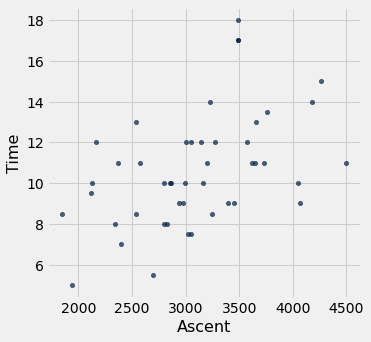

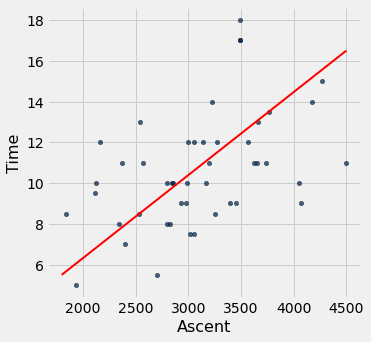

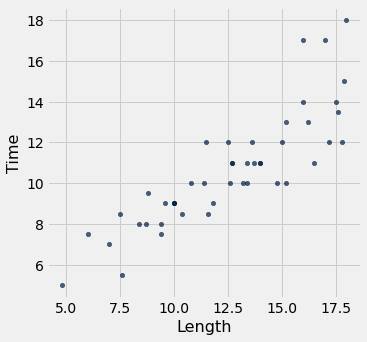

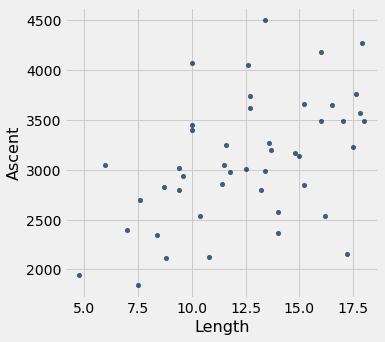

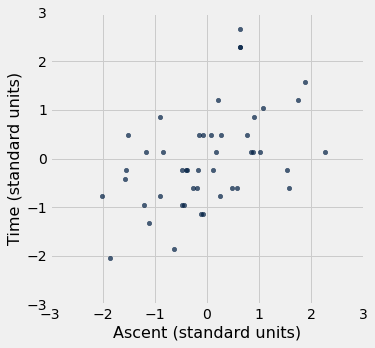

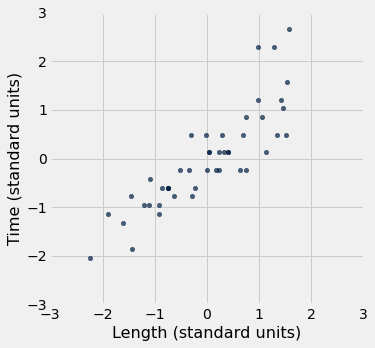

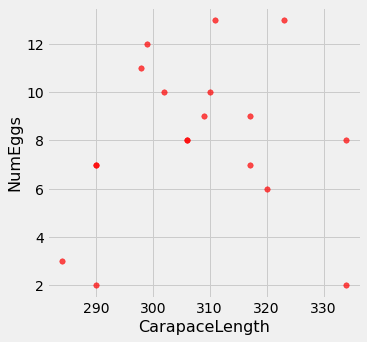

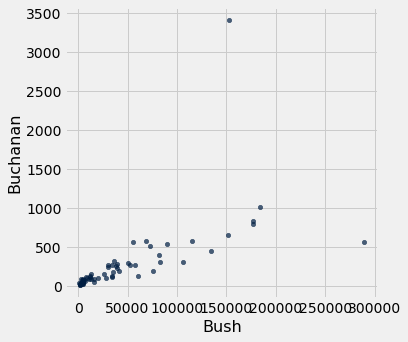

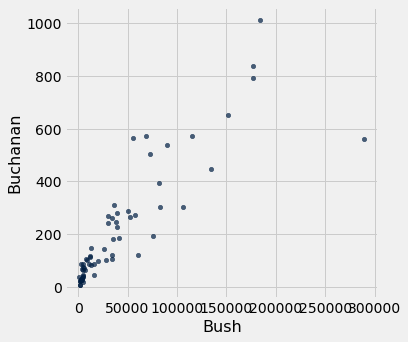

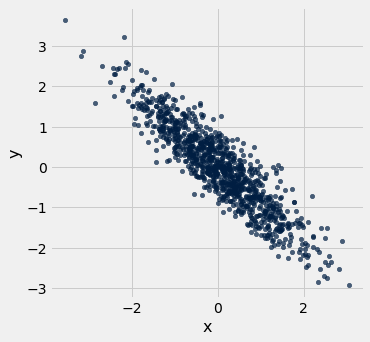

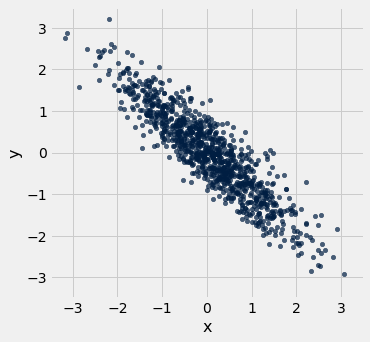

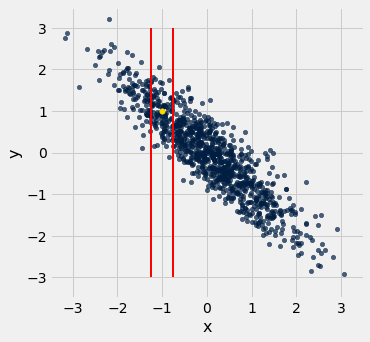

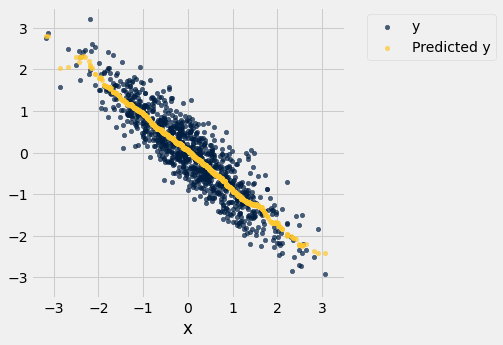

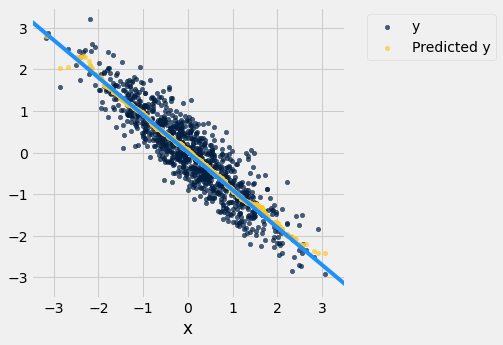

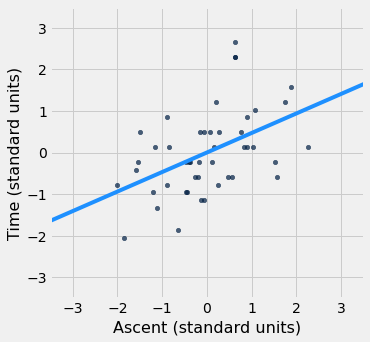

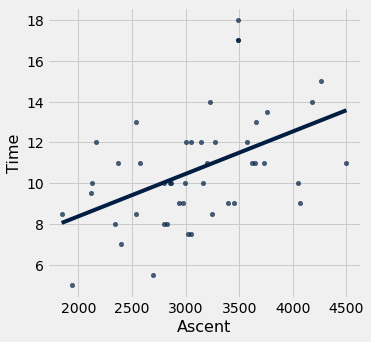

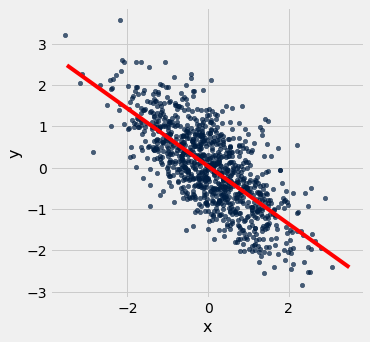

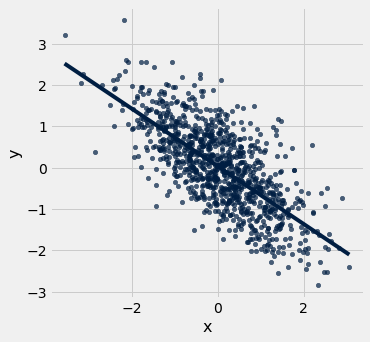

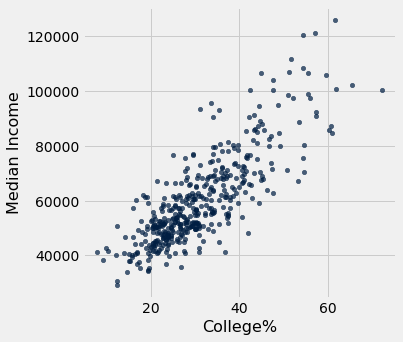

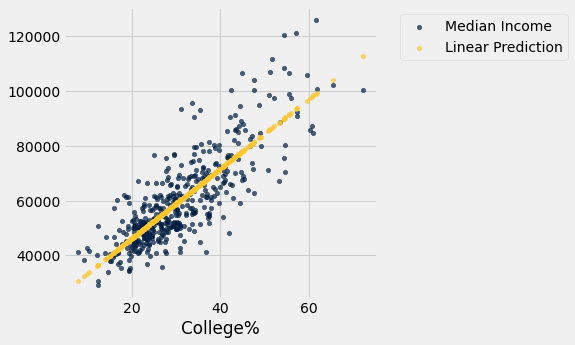

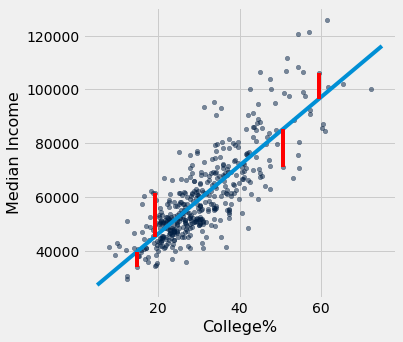

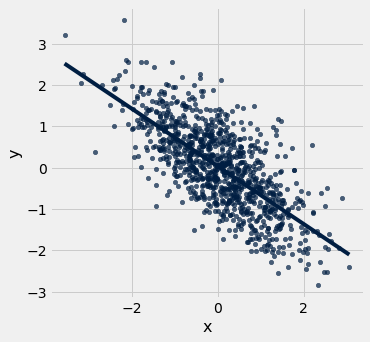

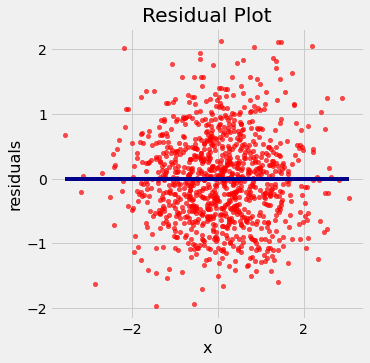

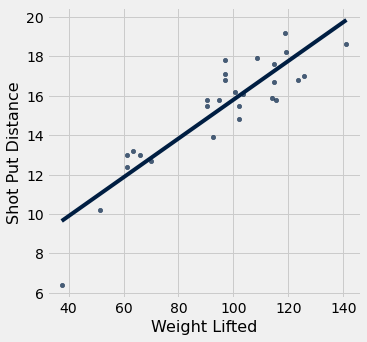

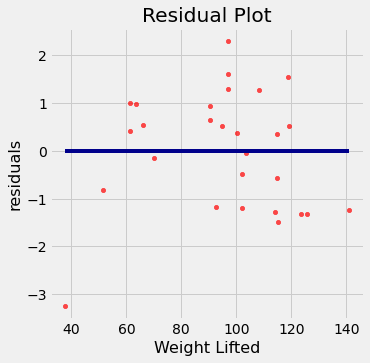

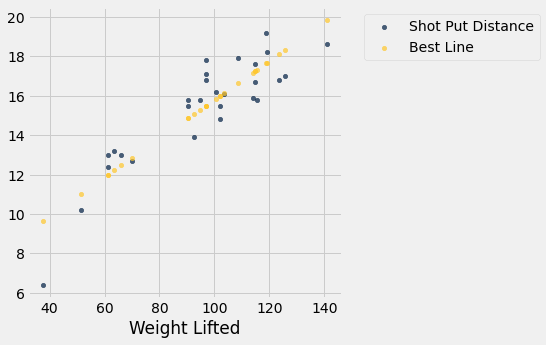

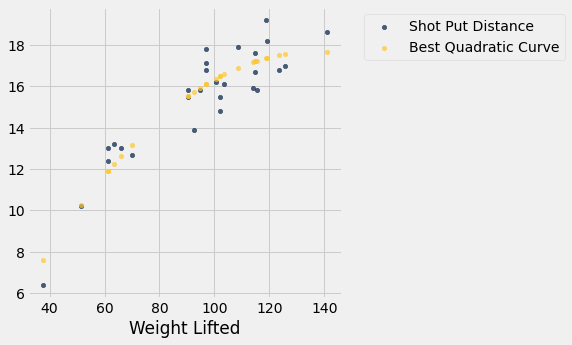

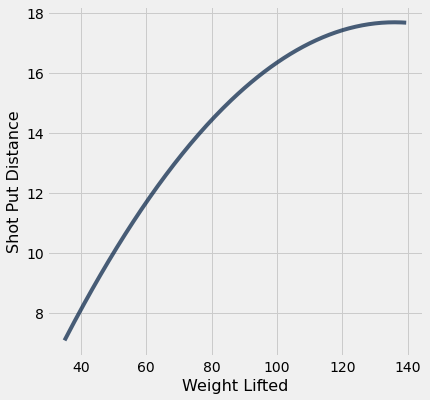

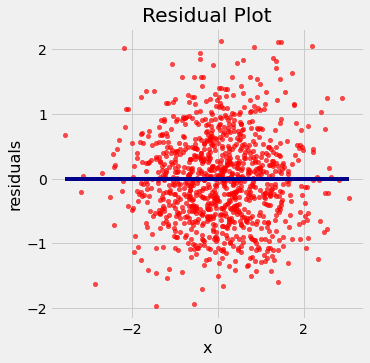

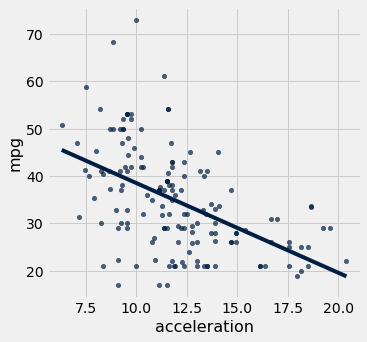

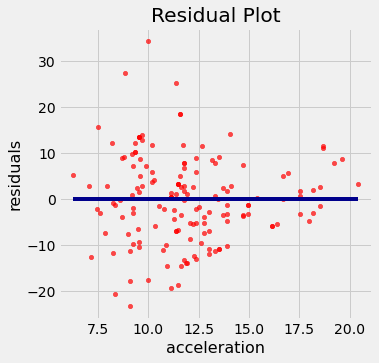

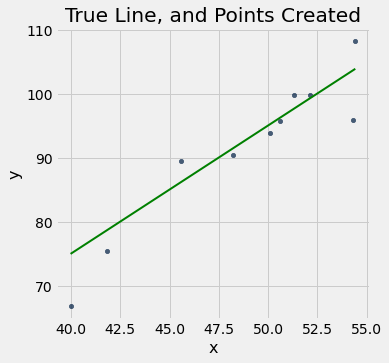

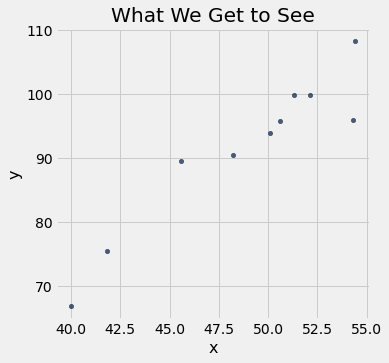

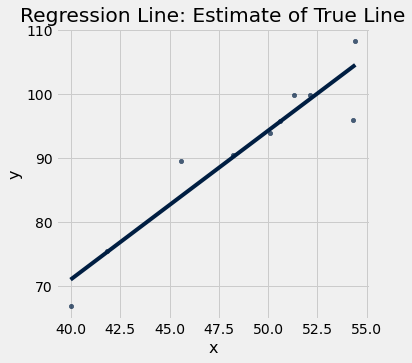

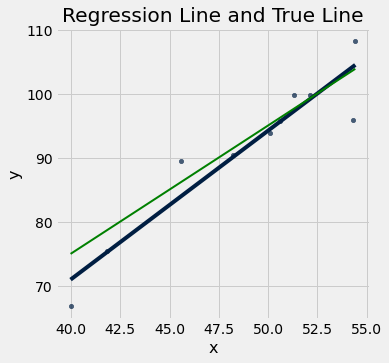

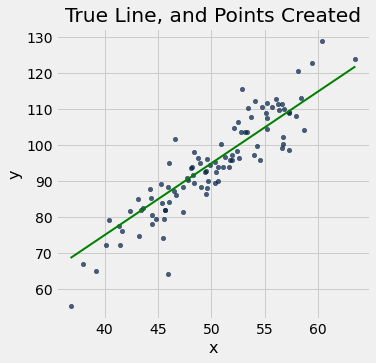

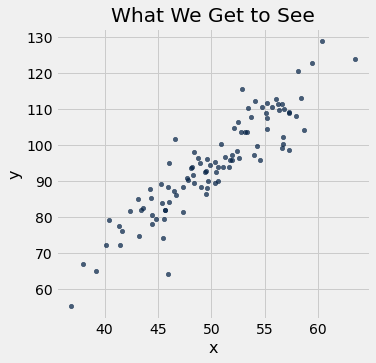

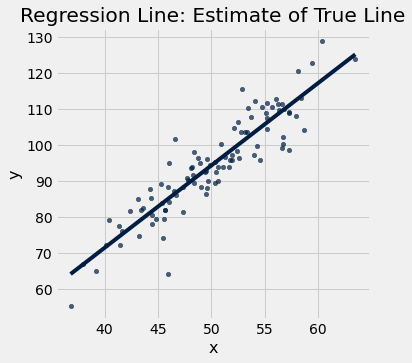

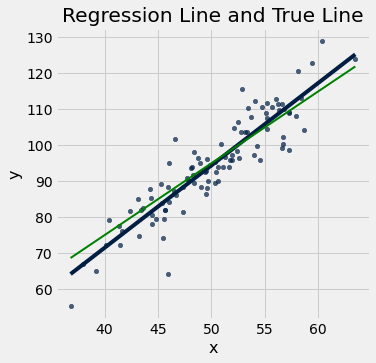

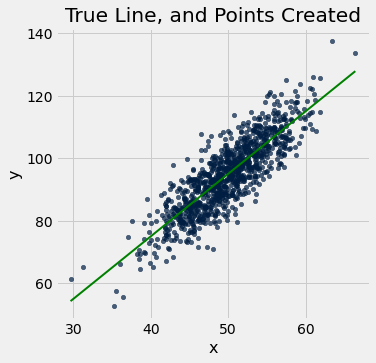

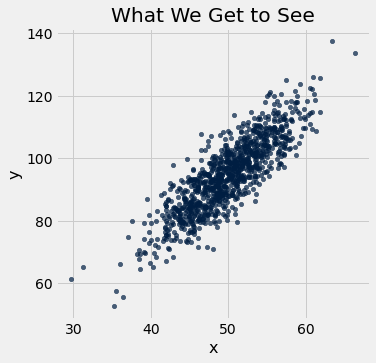

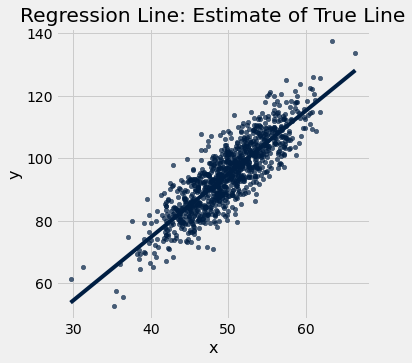

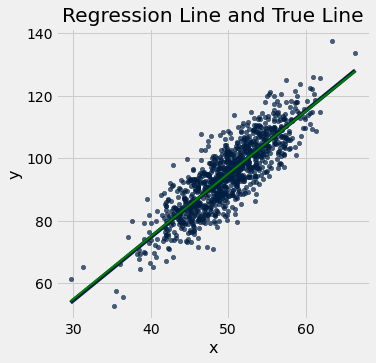

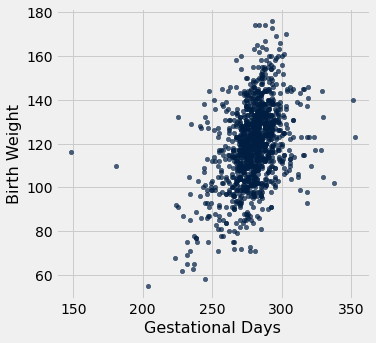

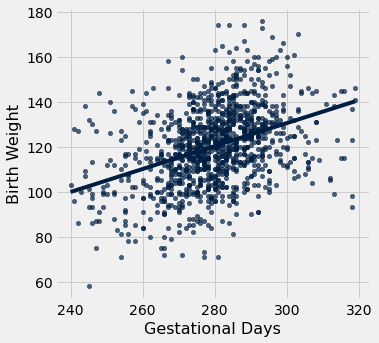

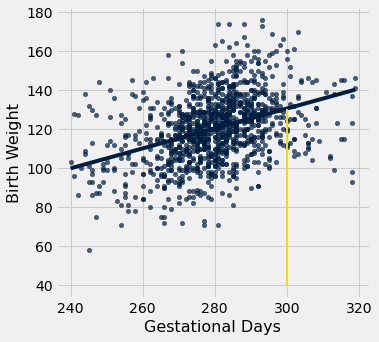

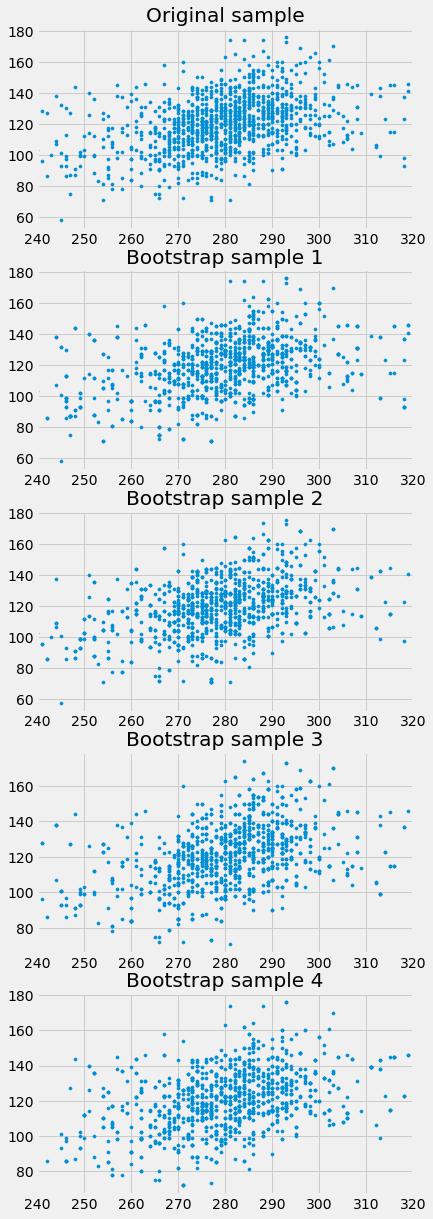

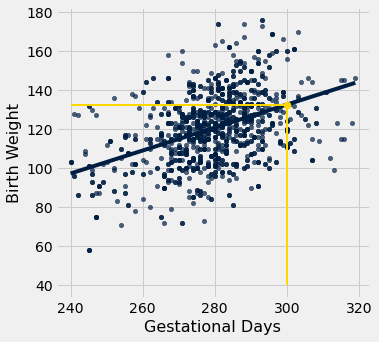

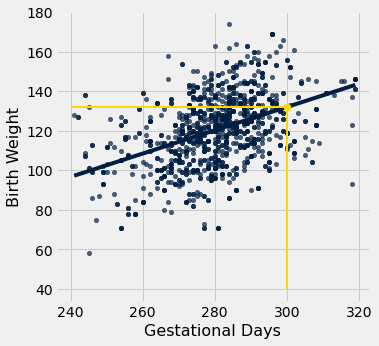

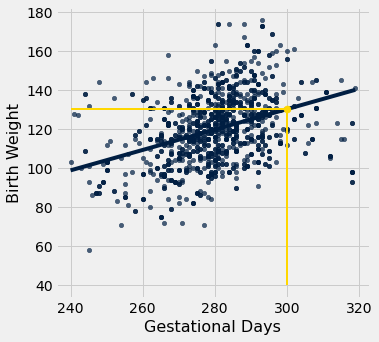

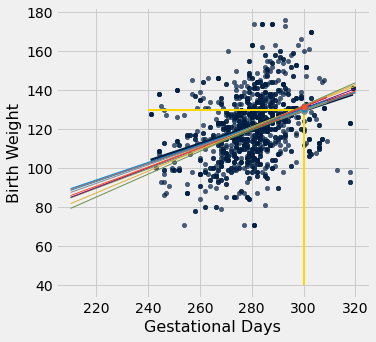

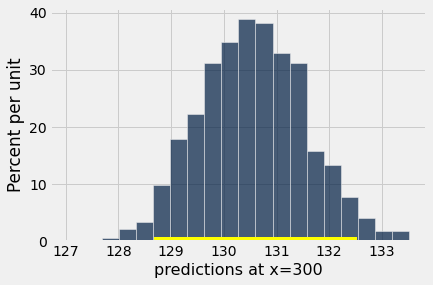

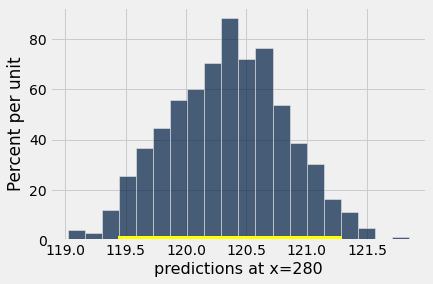

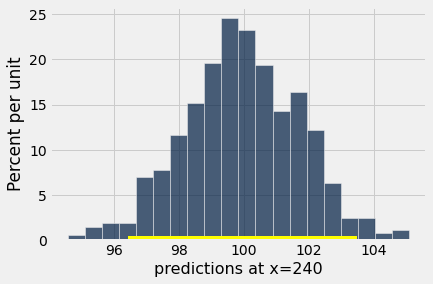

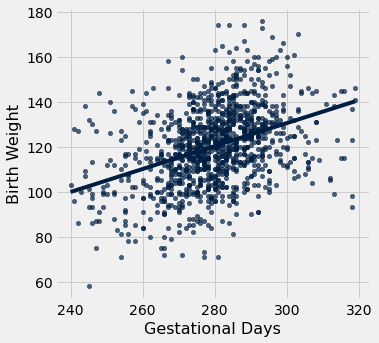

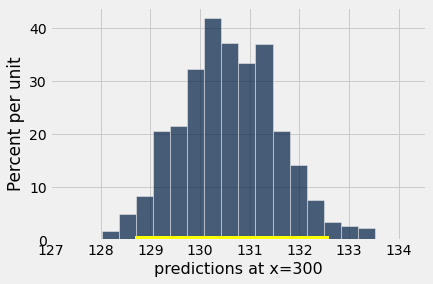

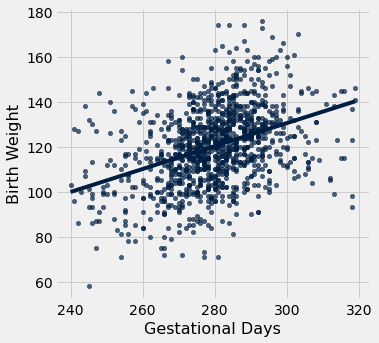

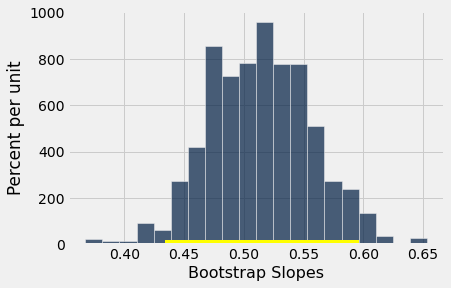

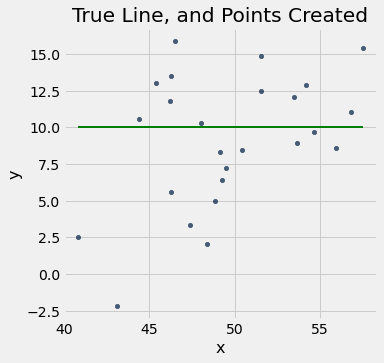

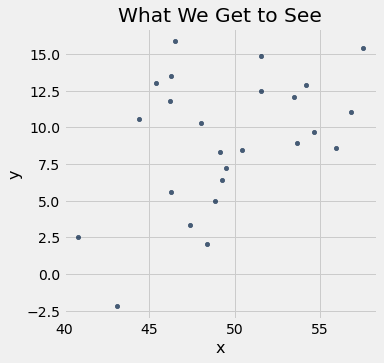

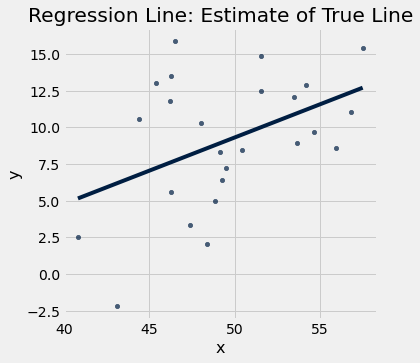

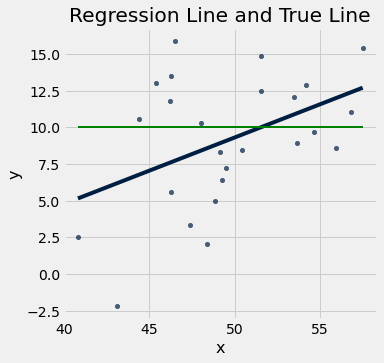

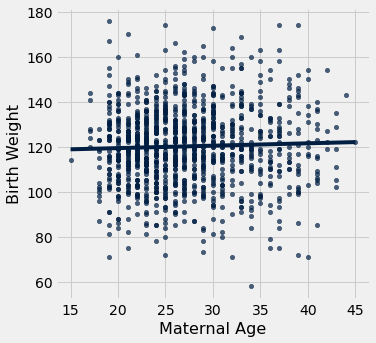

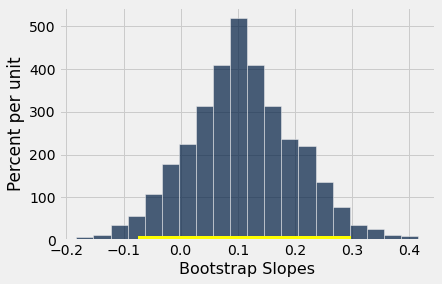

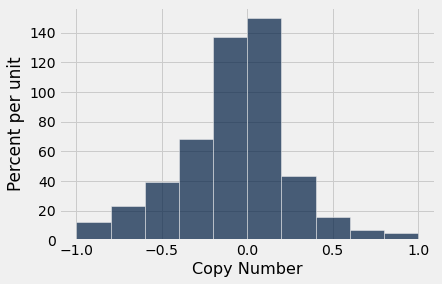

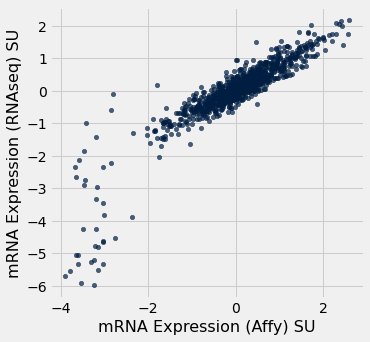

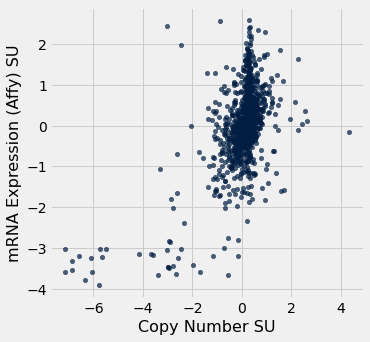

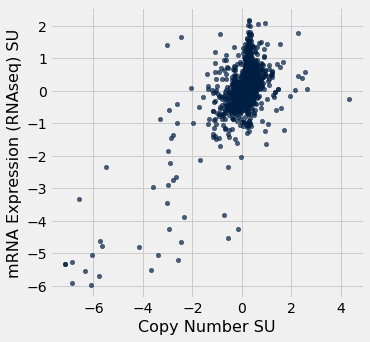

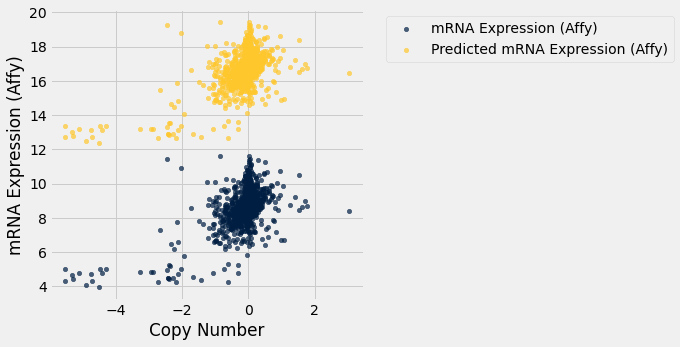

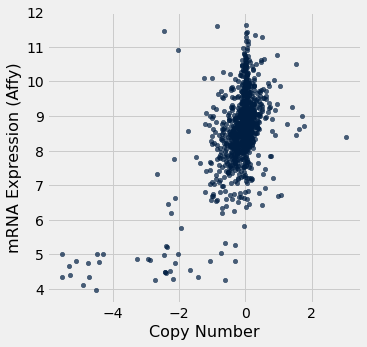

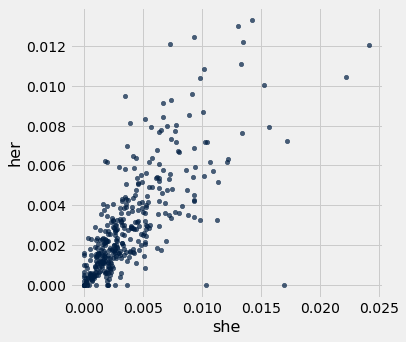

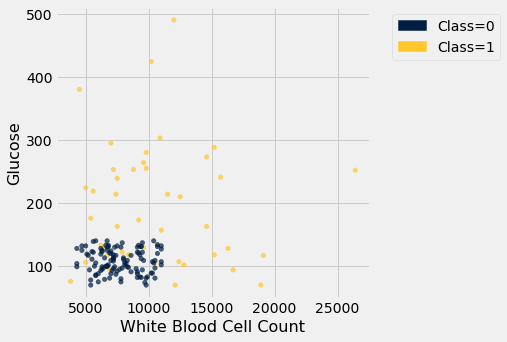

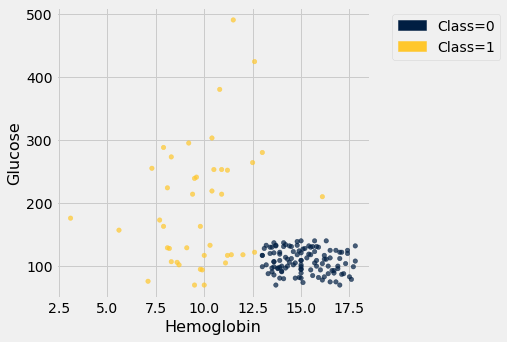

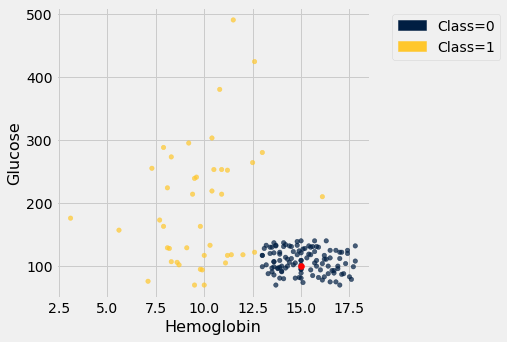

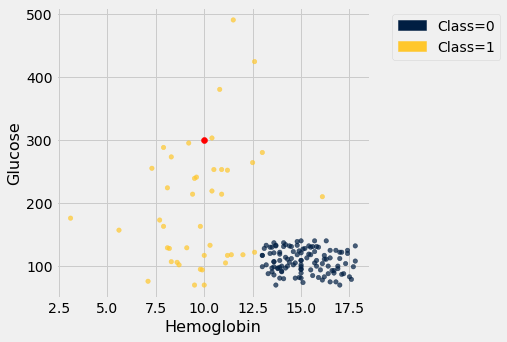

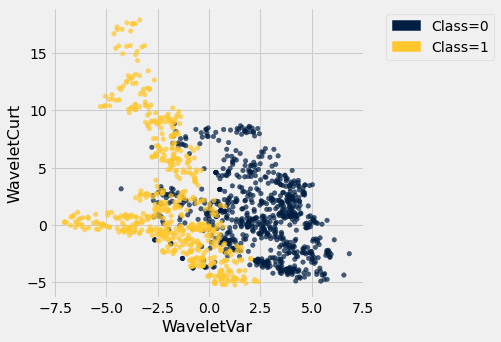

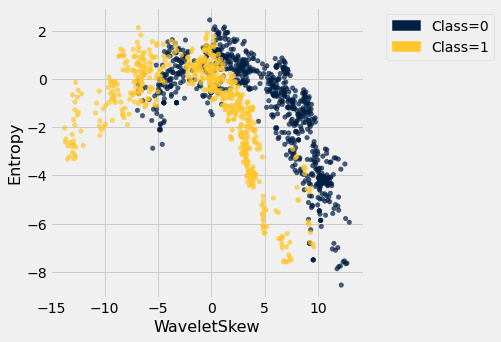

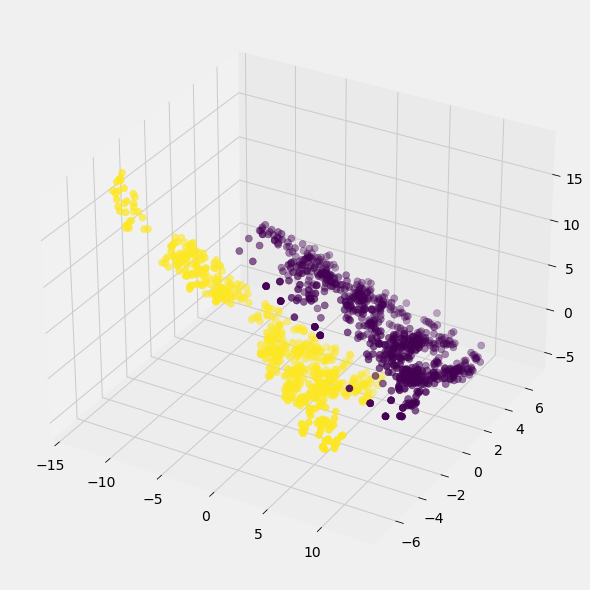

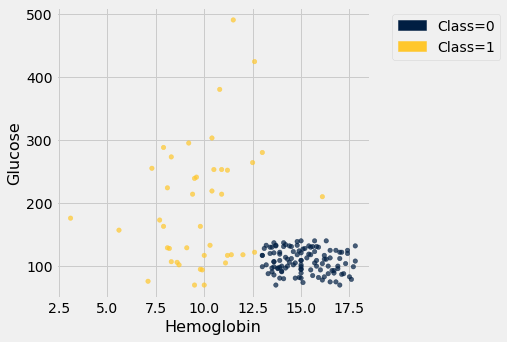

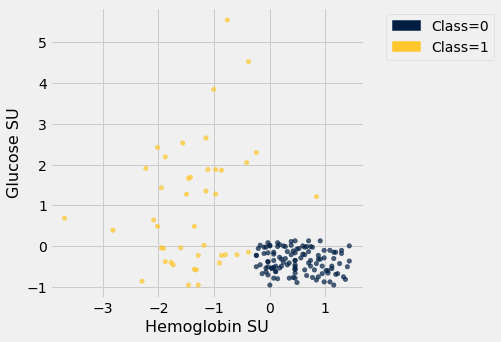

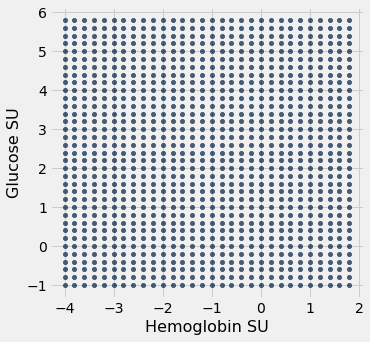

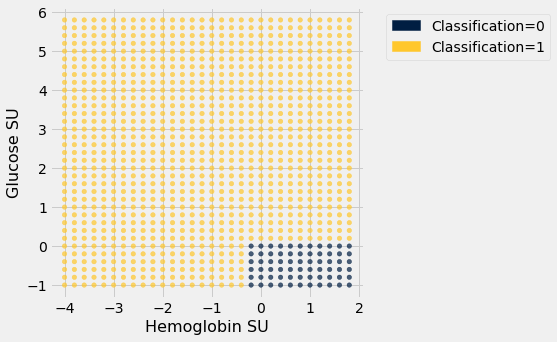

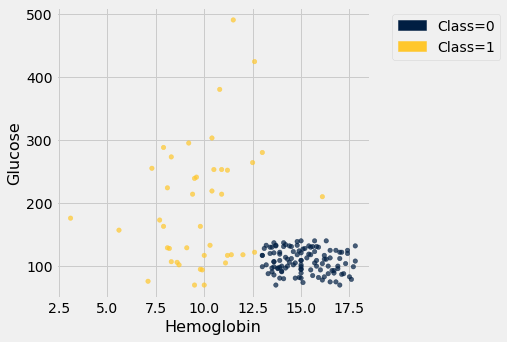

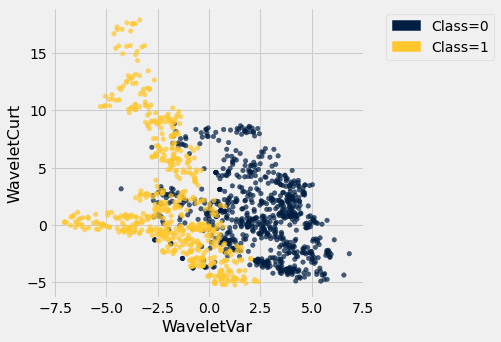

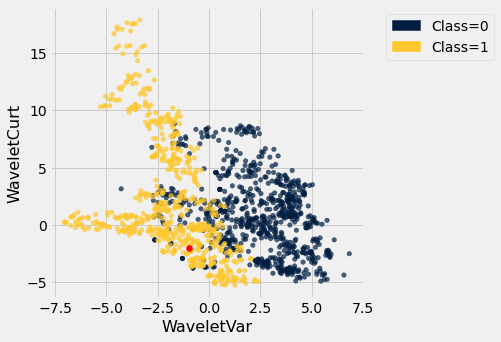

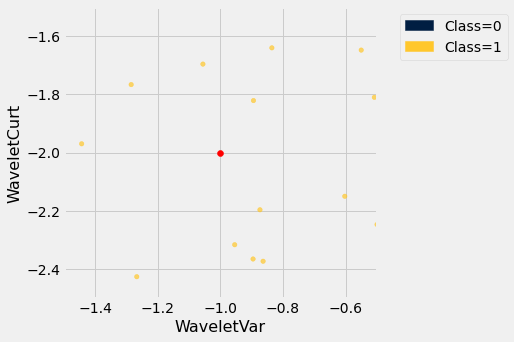

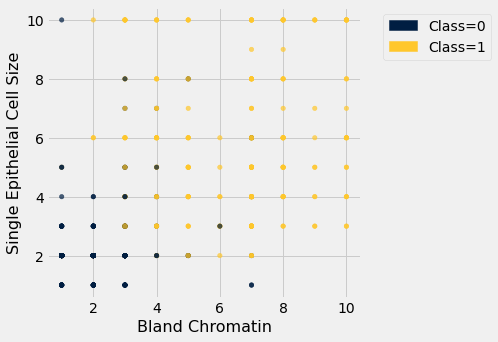

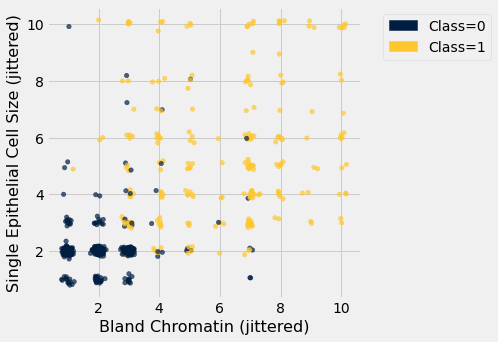

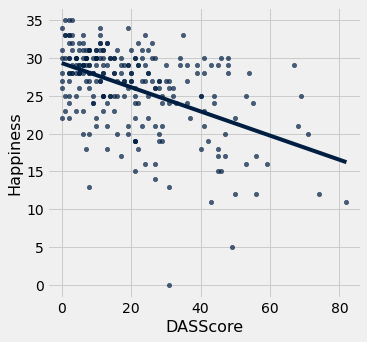

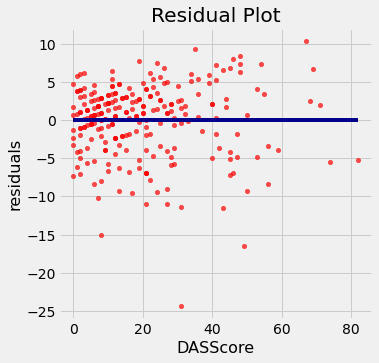

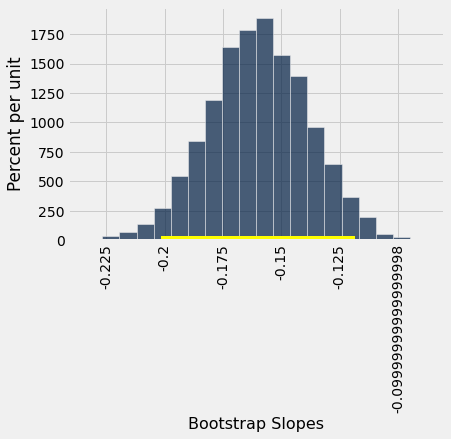

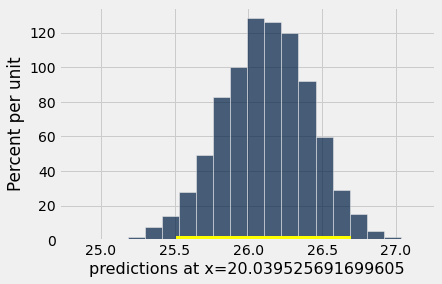

In [2]:
### Import Dependencies

from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Don't forget to import this 
from mpl_toolkits.mplot3d import Axes3D
#Use if looksing for classifiers 

# #### Notes 
# - The Least Squares section of Unit 8 Tells you how to fully do a start-finish linear regression model with predictions 
# - Residuals section of Unit 8 tells you how to get an optimized linear regression model, no predictions outputted 
# - Regression wrap up, unit 8 tells you how to do multiple linear regression in Python 

# - If you want to look at anything for Homework 11, open the actual file instead of running anything here. 

# - See ## Predicting Numerical Variables Review from Unit10 for another example on how to do multiple linear regression with 6 variables 

# ### Defined Functions 

# Where the functions are defined are still in their spots, but they're all here for help and quick reference

# Creates a scatter plot that follows the r value given 
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
# Standard Units 
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

# Calculating r (correlation), (r-squared is a different value, don't confuse the two (closely related))
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

# Use if you have a table of "x" column and "y" column that consists of ONLY INT VALUES 
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))

## Linear regression: defining the line

def slope(t, x, y):
    """t is a table; x and y are column labels"""
    r = correlation(t, x, y)
    slope_xy = r * np.std(t.column(y)) / np.std(t.column(x))
    return slope_xy

def intercept(t, x, y):
    """t is a table; x and y are column labels"""
    slope_xy = slope(t, x, y)
    intercept_xy = np.average(t.column(y) - slope_xy * np.average(t.column(x)))
    return intercept_xy

# How to estimate y at all x values 
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

# If you use this, you have to chage the sample points manually
# This tells you, based on the inputted slope and intercept, how far off is the line from your data 
# Also note, if oyu use this, you will have to change the demographics.scatter section to be whatever your dataset is
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

# calculating residual of a linear regression model 
def residual(table, x, y):
    return table.column(y) - fitted_values(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')
    
# This is the same as the demographics_rmse from the chunk below, but for a different dataset
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

# Quadratic Regression 
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")
    
def add_regression_to_table(t, x, y):
    """ Returns a new table with 'Fitted value' and 'Residual' columns added """
    t_with_extra_cols = t.with_columns(
        'Fitted value', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    return t_with_extra_cols

def prediction_at(t, x, y, x_value):
    '''
    t - table 
    x - label of x column 
    y - label of y column 
    x_value - the x value for which we want to predict y
    '''
    return slope(t,x,y)*x_value + intercept(t,x,y)

## Confidence Interval for Prediction ##

def bootstrap_prediction(t, x, y, new_x, repetitions=1000):
    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions): 
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')
    
# Example use of bootstrap_predictions 
# bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

def bootstrap_slope(t, x, y, repetitions=1000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

# Multiple Linear Regression 

def multiple_regression_rmse(gest_days_mult, mat_height_mult, mat_preg_weight_mult, intercept):
    
    gest_days = births.column('Gestational Days')
    mat_height = births.column('Maternal Height')
    mat_preg_weight = births.column('Maternal Pregnancy Weight')
    
    y = births.column('Birth Weight')
    
    prediction = sum([
        gest_days_mult * gest_days,
        mat_height_mult * mat_height,
        mat_preg_weight_mult * mat_preg_weight,
        intercept]
    )
    
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

# Optimizing teh multiple linear regression 
# best = minimize(multiple_regression_rmse)

# Lab 10 
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

# Homework 11
def fit_line(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    slope = r * y_sd / x_sd
    
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    intercept = y_mean - slope*x_mean
        
    return make_array(slope, intercept)

### Functions for Graphing, Not expected to know how work 

def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)

# If you dont want to have to guess and check the slope then do: 
# slope = correlation(dataset, "x", "y")
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)

# It's good practice to compare the scatter. fit_line and draw_line approach, just to make sure they look right 

# Alternate approach to drawing a line of best fit 
    # HighPeaks.scatter('Ascent', 'Time', fit_line=True)
    # Dataset.scatter('X', 'Y', fit_line=True)

# Alternate approach to drawing a line of best fit
# NOTE: NEed a table of "x" column, "y" column with INT VALUES 
    # ae_slope = slope(another_example, 'x', 'y')
    # ae_intercept = intercept(another_example, 'x', 'y')
    # another_example.scatter('x', 'y')
    # draw_line(
    #     slope = ae_slope, 
    #     intercept = ae_intercept, 
    #     x = make_array(-3.5, 3.5), 
    #     color='r'
    # )

# This gives us the residual for all y, based on all x
# This also gives us the regression line
# This is to the 0.5 power because he wants to square root it to return it to dollar format
# This may change based on your application
# See the residuals section for more details, it's under "another_example_rmse"
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

# This minimizes the regression line, gives us the new slope and intercept 
# Tells us that there is no better slope/intercept (assuming your line is good)
# minimize(demographics_rmse)

def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

#### Classification 

# If you're trying to classify things that are clearly separated in a scatter plot 
def classify(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0
    
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

## Distance ##

def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    
#   ^ SAME AS DOING:
#
#   for i in np.arange(attributes_only.num_rows):
#       row = attributes_only.row(i)
#       distances = np.append(distances, row_distance(list(row), example))
        
    return training.with_column('Distance_to_ex', distances)

## The Closest

def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

## Review of the Steps ## How to do Nearest Neighbor

# - `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
# - `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
# - `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
# - `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
# - `majority_class(topk)`: Returns the majority class in the `'Class'` column
# - `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Accuracy of a Classifier ##

def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

# Creates a table of being yes or not something, with the probability of that thing 
# IF you wanted to use this table, you'd just have to keep in mind whatever probaility you input 
# Is not the disease prob, it's something else 
def create_population(prior_disease_prob, n):
    
    disease = round(n * prior_disease_prob)
    no_disease = n - round(n * prior_disease_prob)

    status = np.array(
        np.sum([
            ['Disease'] * disease,
            ['No disease'] * no_disease
        ]),
        dtype=object
    )
        
    result = np.array(
        np.sum([
            ['Test +'] * disease,
            ['Test +'] * round(no_disease * 0.05),
            ['Test -'] * (no_disease - round(no_disease * 0.05))
        ]),
        dtype=object
    )
                 
    t = Table().with_columns(
    'Status', status,
    'Test Result', result
    )
    return t

#### Conclusion Functions (some repeat) 

## Functions

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(list(new_point)), np.array(list(row)))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')
    
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

# Unit 8: Predictions

## Correlation

# Creates a scatter plot that follows the r value given 
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

## Prediction ##

HighPeaks = Table.read_table('../../Unit8_Predictions/Datasets/HighPeaks.csv')
HighPeaks

# Creates a scatter plot between two variables in a dataset 
HighPeaks.scatter('Ascent', 'Time')

HighPeaks.scatter('Ascent', 'Time')

# My guess about a line that may describe the trend
# This is literally just a random number guess

plots.plot([1800,4500], [5.5,16.5], color='red', lw=2);

## Association ##

HighPeaks.scatter('Length', 'Time')

HighPeaks.scatter('Length', 'Ascent')

def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

Table().with_columns(
    'Ascent (standard units)',  standard_units(HighPeaks.column('Ascent')), 
    'Time (standard units)', standard_units(HighPeaks.column('Time'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

Table().with_columns(
    'Length (standard units)',  standard_units(HighPeaks.column('Length')), 
    'Time (standard units)', standard_units(HighPeaks.column('Time'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

## Correlation ##

# r_scatter(1)

# r_scatter(0.66)

# r_scatter(0.33)

# r_scatter(0)

# r_scatter(-0.33)

# r_scatter(-0.66)

# r_scatter(-1)

## Calculating $r$ by hand ##
# Step 1: select the two variables that you want to find the r value for 

HighPeaks_AT = HighPeaks.select('Ascent', 'Time')

# STep 2: Create a table with the standard values for the variables you want the r value on 
HighPeaks_AT = HighPeaks_AT.with_columns(
    'Ascent (standard units)',  standard_units(HighPeaks.column('Ascent')), 
    'Time (standard units)', standard_units(HighPeaks.column('Time'))
)

# Step 3: multiply the two standard units together 
# This gives you an idea for what the r value may be 
HighPeaks_AT = HighPeaks_AT.with_columns(
    'product of standard units', HighPeaks_AT.column(2) * HighPeaks_AT.column(3))
HighPeaks_AT

# r is the average of the products of the standard units
# STEP 4: get the average of the STANDARD UNIT COLUMNS, You don't care about the product column
# Or you could get the average of the product column I guess 

r = np.average(HighPeaks_AT.column(2) * HighPeaks_AT.column(3))
r

## Function for Calculating $r$ ##

def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

# correlation(HighPeaks, 'Ascent', 'Time')

# correlation(HighPeaks, 'Length', 'Time')

# correlation(HighPeaks, 'Length', 'Ascent')

### Switching Axes ###

correlation(HighPeaks, 'Ascent', 'Time'), correlation(HighPeaks, 'Time', 'Ascent')
# You get the same correlation, regardless of order

### Nonlinearity ###
# Dealing with Non-Linear R Values 
# Same process, just lower r values 

Tortoises = Table.read_table('../../Unit8_Predictions/Datasets/Tortoises.csv')
Tortoises

correlation(Tortoises, 'CarapaceLength', 'NumEggs')

Tortoises.scatter('CarapaceLength', 'NumEggs', s=30, color='r')

### Outliers ###
# Look at how it looks without the outliers
# It's not recommended to remove outliers, just to get a better r value

PalmBeach = Table.read_table('../../Unit8_Predictions/Datasets/PalmBeach.csv')
PalmBeach

correlation(PalmBeach, 'Buchanan', 'Bush')

PalmBeach.scatter('Bush', 'Buchanan')

PalmBeach_removed = PalmBeach.where('County', are.not_containing('PALM BEACH'))

PalmBeach_removed.scatter('Bush', 'Buchanan')

correlation(PalmBeach_removed, 'Buchanan', 'Bush')

## Linear Regression 

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in STOR 120

# def resize_window(lim=3.5)

# def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r')
    
# def make_correlated_data(r)

# def r_scatter(r)
    
# def r_table(r)

## Functions from Last Class
# standard units 
# correlation

## Prediction lines

example = r_table(-0.9)
example.show(3)

example.scatter('x', 'y')

example.scatter('x', 'y')
resize_window()

example.scatter('x', 'y')
plots.plot([-1.25, -1.25], [-3, 3], color='red', lw=2)
plots.plot([-0.75, -0.75], [-3, 3], color='red', lw=2)
plots.scatter(-1,1, s=30, color='gold')
resize_window()

# Use if you have a table of "x" column and "y" column that consists of ONLY INT VALUES 
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))

# Creating a table with the predicted values 
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

# Look at the scatterplot of the x values and since you did it on the example table, 
# it is going to show how well the predicted y worked 
example.scatter('x')
resize_window()

# Draw the line of best fit 
# If you dont want to have to guess and check the slope then do: 
# slope = correlation(dataset, "x", "y")
example.scatter('x')
draw_line(slope=-.9, color='dodgerblue')
resize_window()

# Drawing a line of best fit on a scatter plot 
HighPeaks_AT.scatter('Ascent (standard units)', 'Time (standard units)')

draw_line(slope = correlation(HighPeaks, 'Ascent', 'Time'), color='dodgerblue')
resize_window()

## Linear regression: defining the line

def slope(t, x, y):
    """t is a table; x and y are column labels"""
    r = correlation(t, x, y)
    slope_xy = r * np.std(t.column(y)) / np.std(t.column(x))
    return slope_xy

def intercept(t, x, y):
    """t is a table; x and y are column labels"""
    slope_xy = slope(t, x, y)
    intercept_xy = np.average(t.column(y) - slope_xy * np.average(t.column(x)))
    return intercept_xy

# slope(HighPeaks, 'Ascent', 'Time')

# intercept(HighPeaks, 'Ascent', 'Time')

Time_predict = slope(HighPeaks, 'Ascent', 'Time') * 3000 + intercept(HighPeaks, 'Ascent', 'Time')
# 3000 is the inserted x value we are trying to predict 

print('It will take', np.round(Time_predict, 2), 'hours to climb a mountain with an ascent of 3000 ft')

# HighPeaks.scatter('Ascent', 'Time')
# draw_line(
#     slope = slope(HighPeaks, 'Ascent', 'Time'), 
#     intercept = intercept(HighPeaks, 'Ascent', 'Time'), 
#     x = make_array(1800, 4500), 
#     color='r'
# )

HighPeaks.scatter('Ascent', 'Time', fit_line=True)

## Least Squares 

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in STOR 120

# def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r')
    
# def make_correlated_data(r)
    
# def r_table(r)

# ## Linear regression: defining the line

# def standard_units(x)

# def correlation(t, x, y)

# def slope(t, x, y)

# def intercept(t, x, y)

# Alternate appraoch to drawing a line of best fit 
another_example = r_table(-0.7)

ae_slope = slope(another_example, 'x', 'y')
ae_intercept = intercept(another_example, 'x', 'y')

another_example.scatter('x', 'y')
draw_line(
    slope = ae_slope, 
    intercept = ae_intercept, 
    x = make_array(-3.5, 3.5), 
    color='r'
)

# compare the approach to the fit_line = True Approach 
another_example.scatter('x', 'y', fit_line=True)

## Prediction

demographics = Table.read_table('../../Unit8_Predictions/Datasets/district_demographics2016.csv')

# Drop the columns you don't want to for predictions
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')

# Make a scatter plot of the two variables you want to predict
demographics.scatter('College%', 'Median Income')

correlation(demographics, 'College%', 'Median Income')

# Calculating regression slope and intercept 
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

# For 50% College 
regression_intercept + regression_slope*50
# This gives you the median income for those who completed 50% of their college education

def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

# Gives you the predicted values for all x (which is College%)
predicted = fitted_values(demographics, 'College%', 'Median Income')

# Create a table with the predicted values 
demographics = demographics.with_column(
    'Linear Prediction', predicted)

# Plot those values to see how accurate they are 
demographics.scatter('College%')

## Errors/Residual

actual = demographics.column('Median Income')
errors = actual - predicted

demographics.with_column('Error', errors)

np.mean(errors)

np.mean(errors ** 2) ** 0.5

def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

demographics_errors(regression_slope, regression_intercept)

# takes any slope, any intercept

# demographics_errors(1500, 20000)

# demographics_errors(-1000, 75000)

## Numerical Optimization ###

def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

minimize(complicated_function)
# This optimizes the y value, it makes the line of best fit, fit even better 
# Still have to take in a function as the input for the minimize fuction 

### Minimizing RMSE ###
# This gives us the residual for all y, based on all x
# This also gives us the regression line
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

# This minimizes the regression line 
minimize(demographics_rmse)

make_array(regression_slope, regression_intercept)

## Residuals 

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in STOR 120

# def make_correlated_data(r)
    
# def r_table(r)

# ### Function Defined in Class

# def standard_units(x)

# def correlation(t, x, y)

# def slope(t, x, y)

# def intercept(t, x, y)

# def fitted_values(table, x, y)

### Back to Another Example

another_example = r_table(-0.7)

ae_slope = slope(another_example, 'x', 'y')
ae_intercept = intercept(another_example, 'x', 'y')

ae_slope, ae_intercept

another_example.scatter('x', 'y', fit_line=True)

def another_example_rmse(any_slope, any_intercept):
    x = another_example.column('x')
    y = another_example.column('y')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate)**2)) ** 0.5

minimize(another_example_rmse)

ae_slope, ae_intercept

### Residual Diagnostics: Residual Plots - Another Example

def residual(table, x, y):
    return table.column(y) - fitted_values(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

# This is the same as the plot that you look at in R 
residual_plot(another_example, 'x', 'y')

another_example_with_resid = another_example.with_columns(
    'residual', residual(another_example, 'x', 'y'),
    'fit', fitted_values(another_example, 'x', 'y')
)

# correlation(another_example_with_resid,'x', 'residual')

# correlation(another_example_with_resid,'fit', 'residual')

np.mean(another_example_with_resid.column('residual'))

### Residual Diagnostics: Residual Plots - Shotput

shotput = Table.read_table('../../Unit8_Predictions/Datasets/shotput.csv')

shotput.scatter('Weight Lifted', fit_line=True)

residual_plot(shotput, 'Weight Lifted', 'Shot Put Distance')

def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

best_line = minimize(shotput_linear_rmse)

# Getting your predicted values 
weights = shotput.column(0)

linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

### Can we fix patterns in Residual Plots?
# Quadratic Function: f(x) = ax**2 + b*x + c

# Quadratic Regression 
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

best_quad = minimize(shotput_quadratic_rmse)

# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)

x = np.arange(35, 140, 0.5)
y = best_quad.item(0)*(x**2) + best_quad.item(1)*x + best_quad.item(2)

# Plots the line only
Table().with_columns('Weight Lifted', x, 'Shot Put Distance', y).plot('Weight Lifted')

### Residual Diagnostics: Heteroscedasticity (Uneven Spread)

residual_plot(another_example, 'x', 'y')

hybrid = Table.read_table('../../Unit8_Predictions/Datasets/hybrid.csv')

hybrid.scatter('acceleration', 'mpg', fit_line=True)

residual_plot(hybrid, 'acceleration', 'mpg')

## Regression Inference

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

## Linear regression

def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

def add_regression_to_table(t, x, y):
    """ Returns a new table with 'Fitted value' and 'Residual' columns added """
    t_with_extra_cols = t.with_columns(
        'Fitted value', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    return t_with_extra_cols

## Regression Model ##
draw_and_compare(2, -5, 10)

draw_and_compare(2, -5, 100)

draw_and_compare(2, -5, 1000)

## Prediction ##

births = Table.read_table('../../Unit8_Predictions/Datasets/baby.csv')

births.scatter('Gestational Days', 'Birth Weight')

births = births.where('Gestational Days', are.between(240, 320))

births.scatter('Gestational Days', 'Birth Weight', fit_line = True)

def prediction_at(t, x, y, x_value):
    '''
    t - table 
    x - label of x column 
    y - label of y column 
    x_value - the x value for which we want to predict y
    '''
    return slope(t,x,y)*x_value + intercept(t,x,y)

prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2)

## Prediction - with Bootstrapping ##

plots.figure(figsize=(6, 20))
plots.subplot(5, 1, 1)
plots.scatter(births[1], births[0], s=10)
plots.xlim([240, 320])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = births.sample()
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([240, 320])
    plots.title('Bootstrap sample '+str(i))

for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='gold', lw=2);
    plots.plot([240, x], [predicted_y, predicted_y], color='gold', lw=2);

## Regression Lines from Bootstrapping ##

lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Confidence Interval for Prediction ##

def bootstrap_prediction(t, x, y, new_x, repetitions=1000):
    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions): 
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Confidence Interval for Prediction at x ##
np.mean(births.column('Gestational Days'))

bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 240)


## Regression Wrap Up 

# def draw_and_compare(true_slope, true_int, sample_size)

## Linear regression

# def standard_units(arr)

# def correlation(t, x, y)

# def slope(t, x, y)

# def intercept(t, x, y)

# def prediction_at(t, x, y, x_value)

## Regression Model  - Sample vs Population Lines ##

# draw_and_compare(-2, 5, 50)

## Prediction ##

births = Table.read_table('../../Unit8_Predictions/Datasets/baby.csv')

births = births.where('Gestational Days', are.between(240, 320))

births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)

## Confidence Interval for Prediction ##

# def bootstrap_prediction(t, x, y, new_x, repetitions=1000)

bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Inference for the Slope ##

births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

slope(births, 'Gestational Days', 'Birth Weight')

def bootstrap_slope(t, x, y, repetitions=1000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

bootstrap_slope(births, 'Gestational Days', 'Birth Weight')

## Rain on the Regression Parade

draw_and_compare(0, 10, 25)

# **Null Hypothesis.** Slope of true line = 0.

# **Alternative Hypothesis.** Slope of true line is not 0.

slope(births, 'Maternal Age', 'Birth Weight')

births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 1000)

## Multiple Regression

births = Table.read_table('../../Unit8_Predictions/Datasets/baby.csv')

# correlation(births, 'Birth Weight', 'Gestational Days')

# correlation(births, 'Birth Weight', 'Maternal Age')

# correlation(births, 'Birth Weight', 'Maternal Height')

# correlation(births, 'Birth Weight', 'Maternal Pregnancy Weight')

# What if we try to predict birth weight from gestational days, maternal height, and maternal pregnancy weight?

def multiple_regression_rmse(gest_days_mult, mat_height_mult, mat_preg_weight_mult, intercept):
    
    gest_days = births.column('Gestational Days')
    mat_height = births.column('Maternal Height')
    mat_preg_weight = births.column('Maternal Pregnancy Weight')
    
    y = births.column('Birth Weight')
    
    prediction = sum([
        gest_days_mult * gest_days,
        mat_height_mult * mat_height,
        mat_preg_weight_mult * mat_preg_weight,
        intercept]
    )
    
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

best = minimize(multiple_regression_rmse)
best

# This means that our prediction for birth weight is:

# 0.3707216(*number of gestational days*) + 0.09485383(*Maternal Height*) + 0.10960043(*Maternal Pregnancy Weight*) + -4.16139904

mult_predictions = sum([
    best.item(0) * births.column('Gestational Days'),
    best.item(1) * births.column('Maternal Height'),
    best.item(2) * births.column('Maternal Pregnancy Weight'),
    best.item(3)]
)

mult_resid = births.column('Birth Weight') - mult_predictions 

births = births.with_columns(
    'Mult Predictions', mult_predictions,
    'Mult Residuals', mult_resid 
)

# Checking the scatter plots of the multiple regression variables 

# births.scatter('Mult Predictions', 'Mult Residuals')

# births.where('Mult Predictions', are.between(90, 150)).scatter('Mult Predictions', 'Mult Residuals')

# births.scatter('Maternal Height', 'Mult Residuals')

# births.scatter('Maternal Pregnancy Weight', 'Mult Residuals')

# births.scatter('Gestational Days', 'Mult Residuals')

# births.where('Gestational Days', are.between(210, 360)).scatter('Gestational Days', 'Mult Residuals')

### Homework 10:

# import warnings
# warnings.simplefilter('ignore', FutureWarning)
import matplotlib.pyplot as plt

## Exploring the PTEN Gene with Linear Regression

## 1. PTEN Linear Regression

# Just run this cell
pten = Table().read_table("../../Unit8_Predictions/Datasets/pten.csv")

# Just run this cell
pten.hist("Copy Number", bins = np.arange(-1, 1.1, 0.2))

# **Question 1**

# Looking at the histogram above, we want to check whether or not `Copy Number` is in standard units. For this question, compute the mean and the standard deviation of the values in `Copy Number` and assign these values to `copy_number_mean` and `copy_number_sd` respectively. After you calculate these values, assign `is_su` to either `True` if you think that `Copy Numbers` is in standard units or `False` if you think otherwise.

copy_number = pten.column("Copy Number")
copy_number_mean = np.mean(copy_number)
copy_number_sd = np.std(copy_number)
is_su = True
print(f"Mean: {copy_number_mean}, SD: {copy_number_sd}, Is in standard units?: {is_su}")

# **Question 2**

# Create the function `standard_units` so that it converts the values in the array `array` to standard units. We'll then use `standard_units` to create a new table, `pten_su`, that converts all the values in the table `pten` to standard units.

def standard_units(x):
    return (x - np.average(x)) / np.std(x)

# DON'T DELETE OR MODIFY ANY OF THE LINES OF CODE BELOW IN THIS CELL
pten_su = Table().with_columns("Cell Line", pten.column("Cell Line"),
                               "Copy Number SU", standard_units(pten.column("Copy Number")),
                               "mRNA Expression (Affy) SU", standard_units(pten.column("mRNA Expression (Affy)")),
                               "mRNA Expression (RNAseq) SU", standard_units(pten.column("mRNA Expression (RNAseq)"))                             
                              )
# You should always visually inspect your data, before numerically analyzing any relationships in your dataset. Run the following cell in order to look at the relationship between the variables in our dataset.

# Just run this cell
pten_su.scatter("mRNA Expression (Affy) SU", "mRNA Expression (RNAseq) SU")
pten_su.scatter("Copy Number SU", "mRNA Expression (Affy) SU")
pten_su.scatter("Copy Number SU", "mRNA Expression (RNAseq) SU")

# **Question 3**

# Which of the following relationships do you think has the weakest correlation (i.e. lowest absolute value of `r`)? Assign `weakest_correlation` to the number corresponding to the relationship you think has the lowest correlation.

#1. mRNA Expression (RNAseq) vs. mRNA Expression (Affy)
#2. mRNA Expression (Affy) vs. Copy Number
#3. mRNA Expression (RNAseq) vs. Copy Number 

weakest_correlation = 2

#**Question 4**

#Now, using the `standard units` function, define the function `correlation` which computes the correlation between `array1` and `array2`.

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

# This computes the correlation between the different variables in pten
copy_affy = correlation(pten, "Copy Number","mRNA Expression (Affy)")
copy_rnaseq = correlation(pten,"Copy Number","mRNA Expression (RNAseq)")
affy_rnaseq = correlation(pten,"mRNA Expression (Affy)","mRNA Expression (RNAseq)")

print(f" \
      mRNA Expression (RNAseq) vs. mRNA Expression (Affy) Correlation: {affy_rnaseq}, \n \
      mRNA Expression (Affy) vs. Copy Number Correlation: {copy_affy}, \n \
      mRNA Expression (RNAseq) vs. Copy Number Correlation: {copy_rnaseq}")

# **Question 5**

# If we switch what we input as arguments to `correlation`, i.e. found the correlation between `Copy Number` vs. `mRNA Expression (Affy)` instead of the other way around, would the correlation change? Assign `correlation_change` to either `True` if you think yes, or `False` if you think no.
 
correlation_change = False

#**Question 6**

#Looking at both the scatter plots after Question 2 and the correlations computed in Question 4, describe a pattern you see in the relationships between the variables.

# The pattern is those that follow more of a line, have a higher correlation value.  This is because correlation follows a linear value.  If these values were, say in a parabolic pattern, and followed that pattern strongly, I could see that there was high correlation, but the formula would say there was low correlation.  

#**Question 7**

#Let's look at the relationship between mRNA Expression (Affy) vs. Copy Number only. Define a function called `regression_parameters` that returns the parameters of the regression line as a two-item array containing the intercept and slope of the regression line as the first and second elements respectively. The function `regression_parameters` takes in two arguments, an array of `x` values, and an array of `y` values.

def regression_parameters(t, x, y):
    r = correlation(t, x, y)
    slope_xy = r * np.std(t.column(y)) / np.std(t.column(x))
    intercept_xy = np.average(t.column(y) - slope_xy * np.average(t.column(x)))
    return make_array(intercept_xy, slope_xy)

parameters = regression_parameters(pten, "Copy Number", "mRNA Expression (Affy)")
parameters

#**Question 8**

#If we switch what we input as arguments to `regression_parameters`, i.e. found the parameters for the regression line for `Copy Number` vs. `mRNA Expression (Affy)` instead of the other way around, would the regression parameters change (would the slope and/or intercept change)? Assign `parameters_change` to either `True` if you think yes, or `False` if you think no.

parameters_change = True

#**Question 9**

#Now, let's look at how the regression parameters look like in standard units. Use the table `pten_su` and the function `regression_parameters`, and assign `parameters_su` to a two-item array containing the intercept and the slope of the regression line for mRNA Expression (Affy) in standard units vs. Copy Number in standard units.

import pandas as pd
parameters_su = standard_units(regression_parameters(pten, "Copy Number", "mRNA Expression (Affy)"))
parameters_su

#If you are unfamiliar with scientific notation, running the following cell will help you see the slope and intercept more clearly.

round(parameters_su.item(0), 2), round(parameters_su.item(1), 2)

#**Question 10**

#Looking at the array `parameters_su`, what do you notice about the intercept and slope values specifically? Relate them to another value we already calculated in a previous question, as well as relate them to an equation.

#The values make me think a lot of correlation values.  1 is a strong, pretty perfect positive correlation and -1 is a strong, pretty perfect negative correlation. 

#**Question 11**

#The HeLa cell line is missing from our dataset. If we know that the HeLa Copy Number value is 0.5, what is the predicted mRNA Expression (Affy) value? Use the values in `parameters` that we derived in Question 1.7, and assign the result to `hela_affy`.

# y = mx + b 
# y = 0.91930096x + 8.7525022
 
hela_affy = 0.91930096*(0.5) + 8.7525022
hela_affy

#**Question 12**

#Compute the predicted mRNA Expression (Affy) values from the Copy Number values in the `pten` table. Use the values in the `parameters` array from Question 1.7, and assign the result to `predicted_affy`. We'll plot your computed regression line with the scatter plot from after question 1.2 of mRNA Expression (Affy) vs. Copy Number.

predicted_affy = 0.91930096*(pten["mRNA Expression (Affy)"]) + 8.7525022

# DON'T CHANGE/DELETE ANY OF THE BELOW CODE IN THIS CELL
(pten.with_column("Predicted mRNA Expression (Affy)", predicted_affy)
 .select("Copy Number", "mRNA Expression (Affy)", "Predicted mRNA Expression (Affy)")
 .scatter("Copy Number"))
plt.ylabel("mRNA Expression (Affy)");

## Fitting a least-squares regression line

#Recall that the least-square regression line is the unique straight line that minimizes root mean squared error (RMSE) among all possible fit lines. Using this property, we can find the equation of the regression line by finding the pair of slope and intercept values that minimize root mean squared error.

#**Question 13**

#Define a function called `RMSE`. It should take two arguments:

#1. the intercept of a line (a number)
#2. the slope of a line (a number).

#It should return a number that is the root mean squared error (RMSE) for a line defined with the arguments slope and intercept used to predict mRNA Expression (Affy) values from Copy Number values for each row in the `pten` table.

#*Hint: Errors are defined as the difference between the actual `y` values and the predicted `y` values.*

#*Note: if you need a refresher on RMSE, here's the [link](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html#Root-Mean-Squared-Error) from the textbook*

def RMSE(any_intercept, any_slope):
    y = pten.column("mRNA Expression (Affy)")
    x = pten.column("Copy Number")
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

# DON'T CHANGE THE FOLLOWING LINES BELOW IN THIS CELL
rmse_example = RMSE(8.75, 0.92)
rmse_example

#**Question 14**

#What is the RMSE of a line with slope 0 and intercept of the mean of `y` equal to?

# *Hint 1: The line with slope 0 and intercept of mean of `y` is just a straight horizontal line at the mean of `y`*

# *Hint 2: What does the formula for RMSE become if we input our predicted `y` values in the formula. Try writing it out on paper! It should be a familiar formula.*
# The RMSE of a line with slope 0 and intercept of the mean of y tells us how far off from the intercept the predicted values are off from the actual values. 

# **Question 15**

# Find the parameters that minimizes RMSE of the regression line for mRNA Expression (Affy) vs. Copy Number. Assign the result to `minimized_parameters`.

# If you haven't tried to use the `minimize` yet, now is a great time to practice. Here's an [example from the textbook](https://www.inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html#numerical-optimization).

# *Hint: Use the `RMSE` function in Question 1.13*

# **NOTE: When you use the minimize function, please pass in `smooth=True` as the second argument to this function. You'll need to do this, otherwise, your answer will be incorrect**

minimized_parameters = minimize(RMSE, smooth=True)
minimized_parameters

# **Question 16**

# The slope and intercept pair you found in Question 1.15 should be very similar to the values that you found in Question 1.7. Why were we able to minimize RMSE to find the same slope and intercept from the previous formulas?

# We were able to minimize the RMSE and find the same slope and intercept because the RMSE is already trying to find the smallest root means squared error, so when we minimized it, it just focused the search a little closer. 

# **Question 17**

# If we had instead minimized mean squared error (MSE), would we have gotten the same slope and intercept of the minimized root mean squared error (RMSE) results? Assign `same_parameters` to either `True` if you think yes, or `False` if you think no.

same_parameters = False
same_parameters

# Let's look at the scatter plot of the relationship between Copy Number and mRNA Expression (Affy) again:

pten.scatter("Copy Number", "mRNA Expression (Affy)")

# **Question 18**

# Using a linear regression model, would we be able to obtain accurate predictions for most of the points? Explain why or why not.
#I say no because this looks more like an exponential function graph than a linear regression line.  Therefore the responses would not be accurate unless we fit the regression to a nonlinear regression line. 

### Lab 10

# # Lab 10: Regression

# # 1. The Dataset

# In this lab, we are exploring movie screenplays. In particular, we have compiled a list of 5,000 words (including stemmed words) that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

# Run the cell below to read the `movies` table.

movies = Table.read_table('../../Unit8_Predictions/Datasets/movies.csv')
movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

# The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
# This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format.

# All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

# *Note: All movies in our dataset have their titles lower-cased.* 

title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

# For example, the fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. Check the original table to see if this worked for you!

# row_for_title('the terminator').item('none') 

# #### Question 1.1
# Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns.

# import pandas as pd 

movies_df = pd.read_csv('../../Unit8_Predictions/Datasets/movies.csv')

updated_movies_df = movies_df.drop(["Title", "Year", "Rating", "Genre", "# Words"], axis = 1)
updated_movies_df["Sum"] = updated_movies_df.sum(axis=1)
updated_movies_df["Sum"]

# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = np.average(updated_movies_df["Sum"])
expected_row_sum

# This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

# ## 2. Relationships Between Pairs of Words

# For this section we will look at the relationship between the proportion of the word `her` in screenplays versus the word `she`. We would like to use linear regression to make predictions about this relationship, but that won't work well if the data aren't roughly linearly related. To check that, we should look at the data. Run the cell below to construct a new table `she_her` that contains only the proportions of the words `she` and `her` in the screenplays.

she_her = movies.select("she", "her")
she_her

# **Question 2.1.** Make a scatter plot of the data.  It's conventional to put the column we want to predict on the vertical axis and the other column on the horizontal axis. Lets's say we want to use the proportions of `she` to predict the proportions of `her`

she_her.scatter("she", "her")

# **Question 2.2.** Are the proportions of `she` and `her` in the screenplays roughly linearly related based on the scatter plot above?

# Yes, they appear roughly linear.

# We're going to continue with the assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

# We'd next like to plot the data in standard units. If you don't remember the definition of standard units, textbook section [14.2](https://www.inferentialthinking.com/chapters/14/2/Variability.html#standard-units) might help!

# **Question 2.3.** Compute the mean and standard deviation for the proportions of `she` and `her` in the screenplays.  **Then** create a table called `she_her_standard` containing the proportions of `she` and `her` in the screenplays in standard units.  The columns should be named `she (standard units)` and `her (standard units)`.

# def standard_units(x):
#     "Convert any array of numbers to standard units."
#     return (x - np.average(x)) / np.std(x)

# she_mean = np.mean(she_her.column("she"))
# she_std = np.std(she_her.column("she"))
# her_mean = np.mean(she_her.column("her"))
# her_std = np.std(she_her.column("her"))

# she_her_standard = Table().with_columns(
#     "she (standard units)", standard_units(she_her.column("she")),
#     "her (standard units)", standard_units(she_her.column("her"))
# )

# she_her_standard

# **Question 2.4.** Plot the data again, but this time in standard units.

# she_her_standard.scatter("she (standard units)", "her (standard units)")

# You'll notice that this plot looks the same as the last one!  However, the data and axes are scaled differently.  So it's important to read the ticks on the axes.

# **Question 2.5.** Which would you guess best describes the correlation between the proportions of `she` and `her` in this dataset?

# 1. correlation is positive (but not close to zero)
# 2. correlation is close to zero
# 3. correlation is negative (but not close to zero)

# Assign `correlation` to the number corresponding to your guess.

# correlation = 1

# **Question 2.6.** Compute the correlation `r`.  

# *Hint:* Use `she_her_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r) explains how to do this.

# def correlation(t, x, y)

# r = correlation(she_her_standard, "she (standard units)", "her (standard units)")
# r

# ## 3. The regression line
# Correlation is the **slope of the regression line when the data are put in standard units**.

# The next cell plots the regression line in standard units:

# $$\text{her proportion in standard units} = r \times \text{she proportions in standard units}.$$

# Then, it plots the data in standard units again, for comparison.

# def draw_line(slope=0, intercept=0, x=make_array(-1.5, 6), color='r')

# she_her_standard.scatter('she (standard units)', 'her (standard units)')
# draw_line(slope = r)

# How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `she_std` and its vertical position by `her_std`. That means the same thing would happen to the slope of the line.

# Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

# **Question 3.1.** Calculate the slope of the regression line in original units, and assign it to `slope`.

# (If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line) in the textbook.)

# def slope(t, x, y)

# t = she_her
# x = "she"
# y = "her"

# r = correlation(t,x,y)

# slope = r*y_sd/x_sd
# slope

# We know that the regression line passes through the point `(she_mean, her_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

# $$\text{her proportion} - \verb|her_mean| = \texttt{slope} \times (\text{she proportion} - \verb|she_mean|)$$

# The rearranged equation becomes:

# $$\text{her proportion} = \texttt{slope} \times \text{she proportion} + (- \texttt{slope} \times \verb|she_mean| + \verb|her_mean|)$$


# **Question 3.2.** Calculate the intercept in original units and assign it to `intercept`.

# def intercept(t, x, y)

# t = she_her
# x = "she"
# y = "her"

# x_mean = np.mean(t.column(x))
# y_mean = np.mean(t.column(y))
# y_mean - slope*x_mean

# intercept = y_mean - slope*x_mean
# intercept

# ## 3. Investigating the regression line
# The slope and intercept tell you exactly what the regression line looks like. To predict the proportion of the words in a screenplay that are `her` , multiply the proportion of the words in a screenplay that are `she` by `slope` and then add `intercept`.

# **Question 3.1.** Compute the the proportion of the words in a screenplay that are `her` for a screenplay with `she` occurring for 0.005 proportion of the words and for a screenplay with `she` occurring for 0.015 proportion of the words

# her_prop_for_she005 = 0.005 * slope + intercept
# her_prop_for_she015 = 0.015 * slope + intercept

# # Here is a helper function to print out your predictions.
# # Don't modify the code below.
# def print_prediction(she, predicted_her):
#     print("For a screenplay with 'she' occurring for", she,
#           "proportion of the words, we predict that 'her' would occur in the screenplay", predicted_her,
#           "proportion of the words.")

# print_prediction(0.005, her_prop_for_she005)
# print_prediction(0.015, her_prop_for_she015)

# The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

# she_her.scatter('she', 'her')
# draw_line(
#     slope = slope,
#     intercept = intercept,
#     x = make_array(0.005, 0.0015)
# )

# **Question 3.2.** Make predictions for the proportion of words that are `her` for each screenplay in the `she_her` table.  (Of course, we know exactly what the proportions are! We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `her_predictions` that also includes the columns of the `she_her` table.

# def prediction_at(t, x, y, x_value)

# her_predictions_values = slope * she_her.column("her") + intercept

# her_predictions = she_her.with_column("her_predictions", her_predictions_values)
# her_predictions

# **Question 3.3.** How close were we?  Compute the *residual* for each screenplay in the dataset.  The residual is the actual proportion of the words that are `her` minus the predicted proportion of the words that are `her`.  Add the residuals to `her_predictions` as a new column called `residual` and name the resulting table `her_residuals`.

# resdiuals = her_predictions.column("her") - her_predictions.column("her_predictions")

# her_residuals = her_predictions.with_column("residual", resdiuals)
# her_residuals

# Here is a plot of the residuals you computed.  Each point corresponds to one screenplay.  It shows how much our prediction over- or under-estimated the proportion of `her` words in the screenplay.

# her_residuals.scatter("she", "residual", color="r")

# ## 4. More Words for Multiple Regression

# #### Question 4.1
# Choose a new word in the dataset that you think could be used to predict the proportion of the word `her` in a screenplay. The new word should have a correlation of greater than 0.05 or less than -0.0.5 with `her`. The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values for `r_her_new_word`, `slope_her_new_word` and `intercept_her_new_word`.

# *Hint: It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*.

# corrMatrix = updated_movies_df.corr()

# corrHer = pd.DataFrame(corrMatrix["her"])

# possible_options05 = corrHer[corrHer["her"] >= 0.05]
# possible_options5 = corrHer[corrHer["her"] >= 0.2]

# possible_options5["her"]["daughter"]

# new_word = "daughter"

# # This array should make your code cleaner!
# arr_new_word = movies.column(new_word)

# new_word_su = standard_units(arr_new_word)

# new_word = "daughter"

# # This array should make your code cleaner!
# arr_new_word = movies.column(new_word)

# new_word_su = standard_units(arr_new_word)

# r_her_new_word = possible_options5["her"]["daughter"]

# t = movies
# x = "daughter"
# y = "her"

# r = possible_options5["her"]["daughter"]
# y_sd = np.std(t.column(y))
# x_sd = np.std(t.column(x))

# slope_her_new_word = r * y_sd / x_sd

# x_mean = np.mean(t.column(x))
# y_mean = np.mean(t.column(y))

# intercept_her_new_word = y_mean - slope_her_new_word*x_mean


# # DON'T CHANGE THESE LINES OF CODE
# movies.scatter(new_word, 'her')
# max_x = max(movies.column(new_word))
# print('Correlation:', r_her_new_word)
# plots.plot([0, max_x * 1.3], [intercept_her_new_word, intercept_her_new_word + slope_her_new_word * (max_x*1.3)], color='gold');

# In class we saw that the best fit regression line used to predict y with x minimized the root mean squared error (rmse). 

# $$
# rmse ~=~ \sqrt{mean{(y - y_{estimate})}^2}
# $$



# #### Question 4.2
# Define the function below to calculate the root mean squared error for a regression line that uses the proportion of `new_word` as predictor for the proportion of `her`.

# def her_new_word_rmse(any_slope, any_intercept):
#     y = movies.column("her")
#     x = movies.column("daughter")
#     estimate = any_slope*x + any_intercept
#     return (np.mean((y - estimate) ** 2)) ** 0.5

# Run the cells below to see that the minimize function will (most likely) output the same values for the slope and intercept that you calculated in question 3.2

# minimize(her_new_word_rmse)

# slope_her_new_word, intercept_her_new_word

# This method of using the minimize function to find the minimum root mean squared value for a function can be extended to nonlinear models as well as to models with multiple predictors.

# #### Question 4.2 

# Use the proportions of your `new_word` and `she` to construct a multiple regression model to predict the proportion of the words in the script that are `her`.


# $$
# her_{estimate} ~=~ a*newword + b*she + c
# $$

# for constants $a$, $b$, and $c$

# Define the function below to calculate the root mean squared error for a regression line that has the proportions of these words as predictors for the proportion of `her` in a screenplay.

# def she_new_her_rmse(gest_days_mult, mat_height_mult, intercept):
    
#     newword = movies.column('daughter')
        
#     y = movies.column('she')
    
#     prediction = sum([
#         gest_days_mult * newword,
#         mat_height_mult * mat_height,
#         intercept]
#     )
    
#     mse = np.mean((y - prediction) ** 2)
#     return np.sqrt(mse)

# def fit_line(t, x, y):
#     r = correlation(t, x, y)
#     y_sd = np.std(t.column(y))
#     x_sd = np.std(t.column(x))
#     slope = r * y_sd / x_sd
    
#     x_mean = np.mean(t.column(x))
#     y_mean = np.mean(t.column(y))
#     intercept = y_mean - slope*x_mean
       
#     x = t.column(x)

#     y = x*slope + intercept
    
#     prediction = sum([
#         gest_days_mult * newword,
#         mat_height_mult * mat_height,
#         intercept]
#     )
    
#     mse = np.mean((y - prediction) ** 2)
#     return np.sqrt(mse)
        
#     return make_array(slope, intercept)

# #### Question 4.3

# Use the minimize function to find the coefficients  $a$, $b$, and $c$ that result in the minimal root mean squared error.

# minimize(she_new_her_rmse)

### Homework 11: 

# ## An Introduction to Regression Inference

# # Previously in this class, we've used confidence intervals to quantify uncertainty about estimates. We can also run hypothesis tests using a confidence interval under the following procedure:

# # 1. Define a null and alternative hypothesis (they must be of the form "The parameter is X" and "The parameter is not X").
# # 2. Choose a p-value cutoff, and call it q.
# # 3. Construct a $(100-q)\%$ interval using bootstrap sampling (for example, if your p-value cutoff q is 0.01, or 1%, then construct a 99% confidence interval).
# # 4. Using the confidence interval, determine if your data are more consistent with your null or alternative hypothesis:
# #    * If the null hypothesis mean X is in your confidence interval, the data are more consistent with the null hypothesis.
# #    * If the null hypothesis mean X is *not* in your confidence interval, the data are more consistent with the alternative hypothesis.

# # More recently, we've discussed the use of linear regression to make predictions based on correlated variables. For example, we can predict the height of children based on the heights of their parents.

# # We can combine these two topics to make powerful statements about our population by using the following techniques:
# # - Bootstrapped interval for the true slope
# # - Bootstrapped prediction interval for y (given a particular value of x)

# # This homework explores these two methods.

# ## The Data
# birds = Table.read_table('../../Unit8_Predictions/Datasets/snowy_plover.csv')
# birds

# # In this investigation, we will be using the egg weight to predict bird weight. Run the cell below to create a scatter plot of the egg weights and bird weights, along with their line of best fit.

# # Just run this cell and examine the scatter plot.
# birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

# ## 1. Finding the Bootstrap Confidence Interval for the True Slope

# # Looking at the scatter plot of our sample, we observe a linear relationship between egg weight and bird weight. However, relationships that appear in a sample might not exist in the population from which the sample was taken. 

# # We want to know if there truly exists a linear relationship between egg weight and bird weight for Snowy Plovers. If there is no linear relationship between the two variables, then we'd expect a correlation of 0. Consequently, the slope of the regression line would also be 0. 

# # **Question 1.1.** Let's run a hypothesis test using confidence intervals to see if there is a linear relationship between egg weight and bird weight. Define the null and alternative hypotheses that will allow you to conduct this test.

# # *Note:* Please write your answer **in the cell below** in the following format:
# # - **Null Hypothesis:**
# # - **Alternative Hypothesis:**

# # Ho: There is a linear relationship between egg weight and bird weight  
# # Ha: There is not a linear relationship between egg weight and bird weight 

# # **Question 1.2.** Define the following two functions:

# # 1. `standard_units`: This function takes in an array of numbers and returns an array containing those numbers converted to standard units.
# # 2. `correlation`: This function takes in a table and two column names (one for *x* and one for *y*) and returns the correlation between these columns. 

# # def standard_units(arr):
# #     return (arr - np.average(arr))/np.std(arr)

# # def correlation(t, x, y):
# #     x_standard = standard_units(t.column(x))
# #     y_standard = standard_units(t.column(y))
# #     return np.average(x_standard * y_standard)

# # def slope(t, x, y):
# #     r = correlation(t, x, y)
# #     y_sd = np.std(t.column(y))
# #     x_sd = np.std(t.column(x))
# #     return r * y_sd / x_sd

# # **Question 1.3.** Using the functions you just implemented, create a function called `fit_line`.  It should take a table like `birds` and the column names associated to *x* and *y* as its arguments and return an array containing the slope and intercept of the regression line (in that order) that predicts the *y* column in the table using the *x* column.

# %matplotlib inline
# import matplotlib.pyplot as plots

# def fit_line(t, x, y):
#     r = correlation(t, x, y)
#     y_sd = np.std(t.column(y))
#     x_sd = np.std(t.column(x))
#     slope = r * y_sd / x_sd
    
#     x_mean = np.mean(t.column(x))
#     y_mean = np.mean(t.column(y))
#     intercept = y_mean - slope*x_mean
        
#     return make_array(slope, intercept)
    
# fit_line(birds, "Egg Weight", "Bird Weight")

# # Run this cell to plot the line produced by calling `fit_line` on the `birds` table.  

# # **Note:** You are not responsible for the code in the cell below, but make sure that your `fit_line` function generated a reasonable line for the data.

# # Ensure your fit_line function fits a reasonable line 
# # to the data in faithful, using the plot below.

# slope, intercept = fit_line(birds, "Egg Weight", "Bird Weight")
# birds.scatter("Egg Weight", "Bird Weight")
# plt.plot([min(birds.column("Egg Weight")), max(birds.column("Egg Weight"))], 
#          [slope*min(birds.column("Egg Weight"))+intercept, slope*max(birds.column("Egg Weight"))+intercept])
# plt.show()

# # Now we have all the tools we need to create a confidence interval that quantifies our uncertainty about the true relationship between egg weight and bird weight.

# # **Question 1.4.** Create an array called `resampled_slopes` that contains the slope of the best fit line for 1000 bootstrap resamples of `birds`. Plot the distribution of these slopes.

# # resample_slopes = make_array()

# # for i in np.arange(1000): 
# #     birds_resample = birds.sample()
# #     resample_line = fit_line(birds, "Egg Weight", "Bird Weight")
# #     resample_slope = slope(birds_resample, "Egg Weight", "Bird Weight")
# #     resample_slopes = np.append(resample_slope, resample_slopes)
    
# # DO NOT CHANGE THIS LINE
# Table().with_column("Slope estimate", resample_slopes).hist()

# # **Question 1.5.** Use your resampled slopes to construct a 95% confidence interval for the true value of the slope.

# lower_end = percentile(2.5, resample_slopes)
# upper_end = percentile(97.5, resample_slopes)
# print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

# # **Question 1.6.** Based on your confidence interval, would you reject or fail to reject the null hypothesis that the true slope is 0?  Why?  What p-value cutoff are you using?

# # We would fail to reject Ho because the slope of 0 does not fall within our confidence interval levels.  In a 95% confidence interval, we are using a pvalue of 0.05, which means that there is a 5% chance of being wrong if we happened to reject the null hypothesis.

# # **Question 1.7.** What do you think the true slope is? You do not need an exact number.

# # *Hint:* Can you provide an interval that you think the true slope falls in?

# # Based on this confidence interval, I am 95% confident that the true slope is between 0.595771 to 0.811468.

# # <!-- END QUESTION -->

# ## 2. Finding the Bootstrap Prediction Interval

# # Suppose that we're visiting [Point Reyes](https://www.nps.gov/pore/index.htm) (which I highly recommend!) and stumble upon some Snowy Plover eggs; we'd like to know how heavy they'll be once they hatch. In other words, we want to use our regression line to make predictions about a bird's weight based on the weight of the corresponding egg.

# # However, just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions made based on the true regression line.

# # **Question 2.1.** Define the function `fitted_value`.  It should take in four arguments:

# # 1. `table`: a table like `birds`.  We'll be predicting the values in the second column using the first.
# # 2. `x_col`: the name of our x-column within the input `table`
# # 3. `y_col`: the name of our y-column within the input `table`
# # 2. `given_x`: a number, the value of the predictor variable for which we'd like to make a prediction.
  
# # The function should return the line’s prediction for the given x.

# # *Hint:* Make sure to use the `fit_line` function you defined in Question 1.3.

# def fitted_value(t, x, y, x_val):
#     r = correlation(t, x, y)
#     y_sd = np.std(t.column(y))
#     x_sd = np.std(t.column(x))
#     slope = r * y_sd / x_sd
    
#     x_mean = np.mean(t.column(x))
#     y_mean = np.mean(t.column(y))
#     intercept = y_mean - slope*x_mean
       
#     y = x_val*slope + intercept
        
#     return y

# # Here's an example of how fitted_value is used. The code below
# # computes the prediction for the bird weight, in grams, based on
# # an egg weight of 8 grams.
# egg_weight_eight = fitted_value(birds, "Egg Weight", "Bird Weight", 8)
# egg_weight_eight

# # **Question 2.2.** Shayan, the resident Snowy Plover expert at Point Reyes, tells us that the egg he has been carefully observing has a weight of 9 grams. Using `fitted_value` above, assign the variable `experts_egg` to the predicted bird weight for Shayan's egg. 

# experts_egg = fitted_value(birds, "Egg Weight", "Bird Weight", 9)
# experts_egg

# # A fellow parkgoer raises the following objection to your prediction:

# # > "Your prediction depends on your sample of 44 birds.  Wouldn't your prediction change if you had a different sample of birds?"

# # Having read section [16.3](https://inferentialthinking.com/chapters/16/3/Prediction_Intervals.html) of the textbook, you know just the response! Had the sample been different, the regression line would have been different too. This would ultimately result in a different prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

# # **Question 2.3.** Define a function `compute_resampled_line` that takes in a table `tbl`and two column names, `x_col` and `y_col`, and returns an array containing the parameters of the best fit line (slope and intercept) for one bootstrapped resample of the table.

# birds.sample(1)

# def compute_resampled_line(tbl, x_col, y_col):
#     resample = tbl.sample(2)
#     resampled_line = fit_line(resample, x_col, y_col)
#     return resampled_line

# compute_resampled_line(birds, "Egg Weight", "Bird Weight")

# # value = birds.sample(2)
# # value_2 = fit_line(value, "Egg Weight", "Bird Weight")
# # value_2

# # **Run** the following cell below in order to define the function `bootstrap_lines`.  It takes in four arguments:
# # 1. `tbl`: a table like `birds`
# # 2. `x_col`: the name of our x-column within the input `tbl`
# # 3. `y_col`: the name of our y-column within the input `tbl`
# # 4. `num_bootstraps`: an integer, a number of bootstraps to run.

# # It returns a *table* with one row for each bootstrap resample and the following two columns:
# # 1. `Slope`: the bootstrapped slopes 
# # 2. `Intercept`: the corresponding bootstrapped intercepts 

# # def bootstrap_lines(tbl, x_col, y_col, num_bootstraps):
# #     resampled_slopes = make_array()
# #     resampled_intercepts = make_array() 
# #     for i in np.arange(num_bootstraps): 
# #         resampled_line = compute_resampled_line(tbl, x_col, y_col) 
# #         resampled_slope = resampled_line.item(0) 
# #         resampled_intercept = resampled_line.item(1) 
# #         resampled_slopes = np.append(resampled_slopes,resampled_slope)
# #         resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
# #     tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
# #     return tbl_lines

# # regression_lines = bootstrap_lines(birds, "Egg Weight", "Bird Weight", 1000)
# # regression_lines

# # **Question 2.4.** Create an array called `predictions_for_nine` that contains the predicted bird weights based on an egg of weight 9 grams for each regression line in `regression_lines`.

# # regression_lines.column("Slope")*9+regression_lines.column("Intercept")

# predictions_for_nine = regression_lines.column("Slope")*9+regression_lines.column("Intercept")
        
# # This will make a histogram of your predictions:
# table_of_predictions = Table().with_column('Predictions at Egg Weight=9', predictions_for_nine)
# table_of_predictions.hist('Predictions at Egg Weight=9', bins=20)

# # predictions_for_nine

# # **Question 2.6.** Use your resampled predictions to construct a 95% confidence interval for the true value of the mean birds' weight for 9 gram eggs.

# lower_end_pred = percentile(2.5, predictions_for_nine)
# upper_end_pred = percentile(97.5, predictions_for_nine)
# print("95% confidence interval for mean bird weight for a 9 gram egg:")
# print("[{:g}, {:g}]".format(lower_end_pred, upper_end_pred))

# # **Question 2.7.** Set `plover_statements` to an array of integer(s) that correspond to statement(s) that are true.

# # 1. The 95% confidence interval covers 95% of the bird weights for eggs that had a weight of nine grams in `birds`.

# # 2. The 95% confidence interval gives a sense of how much actual bird weights differ from your prediction.

# # 3. The 95% confidence interval quantifies the uncertainty in our estimate of what the true line would predict.

# plover_statements = make_array(2, 3)


# Unit 9: Predicting Categories

## Classification 

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# def standard_units(x):

## Classifying Patients CKD ##

ckd = Table.read_table('../../Unit9_Predicting_Categories/Datasets/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')

ckd.group('Class')

# Create scatter plots to see if there is a clear distinction between where you can classify things 
ckd.scatter('White Blood Cell Count', 'Glucose', group='Class')

ckd.scatter('Hemoglobin', 'Glucose', group='Class')

# we want to be able to way to predict the class of someone
# without having to plot & eye ball this graph every time.
#
# one way to do this is to put some thresholds into code

max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

max_glucose_for_0, min_hemoglobin_for_0

def classify(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

# Let's try our classifier!
classify(15, 100)

ckd.scatter('Hemoglobin', 'Glucose', group='Class')
plots.scatter(15, 100, color='red');

classify(10, 300)

ckd.scatter('Hemoglobin', 'Glucose', group='Class')
plots.scatter(10, 300, color='red');

## Classifying Banknotes ##
# Classifying things that are not as clearly distinguished 

banknotes = Table.read_table('../../Unit9_Predicting_Categories/Datasets/banknote.csv')
banknotes

banknotes.group('Class')

banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

banknotes.scatter('WaveletSkew', 'Entropy', group='Class')

# Plotting things on a 3D graph to see if there is any overlap with 3 variables 
# There is some distinction on a 3D plot 
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

## Back to Classifying Patients CKD##

ckd.scatter('Hemoglobin', 'Glucose', group='Class')

ckd = ckd.with_columns(
    'Hemoglobin SU', standard_units(ckd.column('Hemoglobin')),
    'Glucose SU', standard_units(ckd.column('Glucose'))
)

ckd.scatter('Hemoglobin SU', 'Glucose SU', group='Class')

x_array = make_array()
y_array = make_array()
for x in np.arange(-4, 2, 0.2):
    for y in np.arange(-1, 6, 0.2):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        


x_array, y_array

test_grid = Table().with_columns(
    'Hemoglobin SU', x_array,
    'Glucose SU', y_array
)

test_grid.scatter('Hemoglobin SU')

max_glucose_SU_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose SU').max()
min_hemoglobin_SU_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin SU').min()

max_glucose_SU_for_0, min_hemoglobin_SU_for_0

# Make things into standard units 
def classify_SU(hemoglobin_SU, glucose_SU):
    if hemoglobin_SU < min_hemoglobin_SU_for_0 or glucose_SU > max_glucose_SU_for_0:
        return 1
    else:
        return 0

    # Use the classifier SU function above so that you can use that to apply to the model 
test_grid = test_grid.with_column(
    'Classification', test_grid.apply(classify_SU, 'Hemoglobin SU', 'Glucose SU'))

# Starting the nearest neighbor things 
test_grid

test_grid.scatter('Hemoglobin SU', 'Glucose SU', group='Classification')

## Nearest Neighbor ##

ckd.scatter('Hemoglobin', 'Glucose', group='Class')

banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')
plots.scatter(-1, -2, color='red');

banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')
plots.scatter(-1, -2, color='red');
plots.ylim(-2.5, -1.5)
plots.xlim(-1.5, -0.5)

## Classifiers 

# Google Science Fair

patients = Table.read_table('../../Unit9_Predicting_Categories/Datasets/breast-cancer.csv').drop('ID')

patients.group('Class')

patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, group='Class')

## Distance ##

def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

attributes = patients.drop('Class')

row_distance(attributes.row(0), attributes.row(1))

row_distance(attributes.row(0), attributes.row(2))

row_distance(attributes.row(2), attributes.row(2))

# The Classifier

def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    
#   ^ SAME AS DOING:
#
#   for i in np.arange(attributes_only.num_rows):
#       row = attributes_only.row(i)
#       distances = np.append(distances, row_distance(list(row), example))
        
    return training.with_column('Distance_to_ex', distances)

example = attributes.row(21)

distances(patients.exclude(21), example).sort('Distance_to_ex')

## The Closest

def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

closest(patients.exclude(21), example, 5)

closest(patients.exclude(21), example, 5).group('Class').sort('count', descending=True)

def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

classify(patients.exclude(21), example, 5)

patients.take(21)

new_example = attributes.row(10)
classify(patients.exclude(10), new_example, 5)

patients.take(10)

another_example = attributes.row(15)
classify(patients.exclude(15), another_example, 5)

patients.take(15)

## Review of the Steps ##

# - `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
# - `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
# - `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
# - `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
# - `majority_class(topk)`: Returns the majority class in the `'Class'` column
# - `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Accuracy of a Classifier ##

patients.num_rows

shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

evaluate_accuracy(training_set, test_set, 5)

evaluate_accuracy(training_set, test_set, 3)

evaluate_accuracy(training_set, test_set, 11)

evaluate_accuracy(training_set, test_set, 1)

# Standardize if Necessary

def standard_units(x):
    return (x - np.average(x)) / np.std(x)

ckd = Table.read_table('../../Unit9_Predicting_Categories/Datasets/ckd.csv')
ckd = ckd.relabeled('Blood Glucose Random', 'Glucose').select('Glucose', 'Hemoglobin', 'White Blood Cell Count', 'Class')

ckd_new = ckd.select('Class').with_columns(
    'Glucose_su', standard_units(ckd.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd.column('Hemoglobin')),
    'WBC_su', standard_units(ckd.column('White Blood Cell Count'))
)

ckd_new

shuffled = ckd_new.sample(with_replacement=False)
training_set = shuffled.take(np.arange(79))
test_set = shuffled.take(np.arange(79, 158))

evaluate_accuracy(training_set, test_set, 3)

shuffled = ckd_new.sample(with_replacement=False)
training_set = shuffled.take(np.arange(79))
test_set = shuffled.take(np.arange(79, 158))

evaluate_accuracy(training_set, test_set, 3)

## Decisions and Probability

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

## Years and Majors

# np.array(list) converts list to an array
# provided all the elements of list are of the same type

# Creating the data we are going to work with 
n = 100
second = round(n * 0.6)
third = n - round(n * 0.6)

year = np.array(
    np.sum([
        ['Second'] * second,
        ['Third'] * third
    ]),
    dtype=object
)

major = np.array(
    np.sum([
        ['Declared'] * round(second * 0.5),
        ['Undeclared'] * (second - round(second * 0.5)),
        ['Declared'] * round(third * 0.8),
        ['Undeclared'] * (third  - round(third * 0.8))
    ]),
    dtype=object
)

# Creating the table we will be working with 
students = Table().with_columns(
    'Year', year,
    'Major', major
)

# This creates a grouped table 
students.group('Year')

# This creates a multiple grouped table 
students.pivot('Year', 'Major')

# I pick one student at random...That student has declared a major!
# Second Year or Third Year?

# Probablity of third year
32 / (30 + 32)

# Probability of second year
30 / (30 + 32)

## Tree Diagram Calculation

# P(third year | declared), from tree diagram

(0.4 * 0.8) / (0.6 * 0.5 + 0.4 * 0.8)

# P(second year | declared), from tree diagram

(0.6 * 0.5) / (0.6 * 0.5 + 0.4 * 0.8)

## Monty Hall

# P(win car | switched), from tree diagram

(2/3 * 1/2) / (2/3 * 1/2 + 1/3 * 1/2)

## Disease Decisions

# P(disease | tested +)
# if prior probability of disease is 1/10

(0.001 * 1) / (0.001*1 + 0.999*0.05)

def create_population(prior_disease_prob, n):
    
    disease = round(n * prior_disease_prob)
    no_disease = n - round(n * prior_disease_prob)

    status = np.array(
        np.sum([
            ['Disease'] * disease,
            ['No disease'] * no_disease
        ]),
        dtype=object
    )
        
    result = np.array(
        np.sum([
            ['Test +'] * disease,
            ['Test +'] * round(no_disease * 0.05),
            ['Test -'] * (no_disease - round(no_disease * 0.05))
        ]),
        dtype=object
    )
                 
    t = Table().with_columns(
    'Status', status,
    'Test Result', result
    )
    return t

create_population(1/1000, 10000)

create_population(1/1000, 10000).pivot('Test Result', 'Status')

## More Common Disease

# P(disease | tested +)
# if prior probability of disease is 1/10

(0.1 * 1) / (0.1*1 + 0.9*0.05)

create_population(1/10, 10000).pivot('Test Result', 'Status')

# P(disease | tested +)
# if prior probability of disease is 1/10

1000 / (1000 + 450)

### Lab 11: 

# # Lab 11: Movie Classification
# In this lab you will build a classifier that guesses whether a movie is a comedy or a thriller, using only the number of times words appear in the movies's screenplay. By the end of the lab, you should know how to:

# 1. Build a k-nearest-neighbors classifier.
# 2. Test a classifier on data.

# To get started, run the cell below.

# # Run this cell to set up the notebook, but please don't change it.
# import numpy as np
# import math
# from datascience import *

# # These lines set up the plotting functionality and formatting.
# import matplotlib
# %matplotlib inline
# import matplotlib.pyplot as plots
# plots.style.use('fivethirtyeight')
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

# # 1. The Dataset (Again)

# In this lab we will again explore movie screenplays. We will be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

# Run the cell below to read the `movies` table.

# movies = Table.read_table('../Datasets/movies.csv')
# movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

# The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
# This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

# All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

# *Note: All movies in our dataset have their titles lower-cased.* 

# title_index = movies.index_by('Title')
# def row_for_title(title):
#     """Return the row for a title, similar to the following expression (but faster)
    
#     movies.where('Title', title).row(0)
#     """
#     return title_index.get(title)[0]

# For example, the fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. Check the original table to see if this worked for you!

# row_for_title('the terminator').item('none') 

# ## 1.1. Splitting the dataset
# We're going to use our `movies` dataset for two purposes.

# 1. First, we want to *train* movie genre classifiers.
# 2. Second, we want to *test* the performance of our classifiers.

# Hence, we need two different datasets: *training* and *test*.

# The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

# Run the code below (without changing it) to separate the datasets into two tables.

# # Here we have defined the proportion of our data
# # that we want to designate for training as 17/20ths
# # of our total dataset.  3/20ths of the data is
# # reserved for testing.

# training_proportion = 17/20

# num_movies = movies.num_rows
# num_train = int(num_movies * training_proportion)
# num_test = num_movies - num_train

# train_movies = movies.take(np.arange(num_train))
# test_movies = movies.take(np.arange(num_train, num_movies))

# print("Training: ",   train_movies.num_rows, ";",
#       "Test: ",       test_movies.num_rows)

# # 2. K-Nearest Neighbors - A Guided Example

# K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

# An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

# To build understanding, we're going to visualize the algorithm instead of just describing it.

# ## 2.1. Classifying a movie

# In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

# Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "paid" and "rent" in the movie.  Taking the movie *Fast Times at Ridgemont High* (in the test set), 0.0001915341 of its words are "paid" and 0.0001915341 are "rent". This movie appears in the test set, so let's imagine that we don't yet know its genre.

# First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. 

# This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is: 
# &nbsp;

# <center> $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$. </center>
# &nbsp;

# For example, in the movie *Ghostbusters* (in the training set), 0.0002191060 of all the words in the movie are "paid" and 0 are "rent".  Its distance from *Fast Times at Ridgemont High* on this 2-word feature set is: 
# &nbsp;

# <center> $\sqrt{(0.0001915341 - 0.0002191060)^2 + (0.0001915341 - 0)^2} \approx 0.0001935084$. </center> 
# &nbsp;

# A third movie, *Point Break* (in the training set), is 0 "paid" and 0.0002754820 "rent".

# The function below creates a plot to display the "paid" and "rent" features of a test movie and some training movies. As you can see in the result, *Fast Times at Ridgemont High* is more similar to *Ghostbusters* than to the *Point Break* based on these features, which makes sense as both movies are comedy movies, while *Point Break* is a thriller.


# # Just run this cell.
# def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
#     """Plot a test movie and training movies using two features."""
#     test_row = row_for_title(test_movie)
#     distances = Table().with_columns(
#             x_feature, [test_row.item(x_feature)],
#             y_feature, [test_row.item(y_feature)],
#             'Color',   ['unknown'],
#             'Title',   [test_movie]
#         )
#     for movie in training_movies:
#         row = row_for_title(movie)
#         distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
#     distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=30)
    
# training = ["ghostbusters", "point break"] 
# plot_with_two_features("fast times at ridgemont high", training, "paid", "rent")
# plots.axis([-0.0001, 0.0003, -0.0001, 0.0004]);
# plots.xticks(rotation=90);

# #### Question 2.1.1

# Compute the Euclidean distance (defined in the section above) between the two movies, *Fast Times at Ridgemont High* and *Point Break*, using the `paid` and `rent` features only.  Assign it the name `one_distance`.

# **Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

# *Hint*: Remember the function `row_for_title`, redefined for you below.

# <!--
# BEGIN QUESTION
# name: q2_1_1
# -->

# title_index = movies.index_by('Title')
# fast_times = row_for_title('fast times at ridgemont high') 
# point_break = row_for_title("point break") 

# x_1 = fast_times.item("paid")
# y_1 = fast_times.item("rent")
# x_2 = point_break.item('paid')
# y_2 = point_break.item("rent")

# one_distance = np.sqrt(((x_1 - x_2)**2) + ((y_1-y_2)**2))
# one_distance

# Below, we've added a third training movie, *The Abyss*. Before, the point closest to *Fast Times at Ridgemont High* was *Ghostbusters*, a comedy movie. However, now the closest point is *The Abyss*, a thriller movie.

# training = ["ghostbusters", "point break", "the abyss"] 
# plot_with_two_features("fast times at ridgemont high", training, "paid", "rent") 
# plots.axis([-0.0001, 0.00035, -0.0001, 0.0004]);
# plots.xticks(rotation=90);

# #### Question 2.1.2
# Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Fast Times at Ridgemont High* is closer to *The Abyss* than it is to *Ghostbusters*. 

# <!--
# BEGIN QUESTION
# name: q2_1_2
# -->

# def distance_two_features(title0, title1, x_feature, y_feature):
#     """Compute the distance between two movies with titles title0 and title1
    
#     Only the features named x_feature and y_feature are used when computing the distance.
#     """
#     x_1 = row_for_title(title0).item(x_feature)
#     y_1 = row_for_title(title0).item(y_feature)
#     x_2 = row_for_title(title1).item(x_feature)
#     y_2 = row_for_title(title1).item(y_feature)
    
#     return np.sqrt(((x_1 - x_2)**2) + ((y_1-y_2)**2))

# for movie in make_array("ghostbusters", "the abyss"):
#     movie_distance = distance_two_features(movie, "fast times at ridgemont high", "paid", "rent")
#     print(movie, 'distance:\t', movie_distance)

# #### Question 2.1.3
# Define the function `distance_from_fast_times` so that it works as described in its documentation.

# **Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

# <!--
# BEGIN QUESTION
# name: q2_1_3
# -->

# def distance_from_fast_times(title):
#     """The distance between the given movie and "fast times at ridgemont high", 
#     based on the features "paid" and "rent".
    
#     This function takes a single argument:
#       title: A string, the name of a movie.
#     """
#     return distance_two_features(title0, "fast times at ridgemont hight", "paid", "rent")

# #### Question 2.1.4

# Using the features `"paid"` and `"rent"`, what are the names and genres of the 5 movies in the **training set** closest to *Fast Times at Ridgemont High*?  To answer this question, make a table named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"paid"`, and `"rent"`, as well as a column called `"distance from fast times"` that contains the distance from *Fast Times at Ridgemont High*.  The table should be **sorted in ascending order by `distance from fast times`**.

# <!--
# BEGIN QUESTION
# name: q2_1_4
# -->

# # The staff solution took multiple lines.
# test = Table().with_columns("Title", training)

# genres = []
# for x in np.arange(0,3,1):
#     movie = test[0][x]
#     genres.append(row_for_title(movie)[3])

# test = test.with_columns("Genre", genres)

# paid_list = [] 
# for x in np.arange(0,3,1):
#     movie = test[0][x]
#     paid_list.append(row_for_title(movie).item("paid"))
    
# test = test.with_columns("paid", paid_list)

# rent_list = [] 
# for x in np.arange(0,3,1):
#     movie = test[0][x]
#     rent_list.append(row_for_title(movie).item("rent"))
    
# test = test.with_columns("rent", rent_list)

# distance_from = []
# for x in np.arange(0,3,1):
#     movie = test[0][x]
    
#     title0 = "fast times at ridgemont high"
#     title1 = movie
#     x_feature = "paid"
#     y_feature = "rent"

#     x_1 = row_for_title(title0).item(x_feature)
#     y_1 = row_for_title(title0).item(y_feature)
#     x_2 = row_for_title(title1).item(x_feature)
#     y_2 = row_for_title(title1).item(y_feature)

#     distance_from.append(np.sqrt(((x_1 - x_2)**2) + ((y_1-y_2)**2)))
    
# test = test.with_columns("distance from fast times", distance_from)

# test = test.sort("distance from fast times")

# close_movies = test
# close_movies

# ### Question 2.1.5
# Next, we'll classify *Fast Times at Ridgemont High* based on the genres of the closest movies. 

# To do so, define the function `most_common` so that it works as described in its documentation below.

# <!--
# BEGIN QUESTION
# name: q2_1_5
# -->

# from collections import Counter

# def my_mode(sample):
#     c = Counter(sample)
#     return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

# my_mode(close_movies["Genre"])

# # Function source: https://stackabuse.com/calculating-mean-median-and-mode-in-python/

# def most_common(label, table):
#     """The most common element in a column of a table.
    
#     This function takes two arguments:
#       label: The label of a column, a string.
#       table: A table.
     
#     It returns the most common value in that column of that table.
#     In case of a tie, it returns any one of the most common values
#     """
#     c = Counter(table[label])
#     return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

# most_common('Genre', close_movies)



# Congratulations are in order -- you've classified your first movie! You correctly classified Fast Times at Ridgemont High as a comedy! You are done with Lab 11! In class we will expand on how we can use many features to perform classification.

# Unit 10: Conclusion 

## Predicting Categories Review 

## Functions

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(list(new_point)), np.array(list(row)))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

## Counterfeit Currency

banknotes = Table.read_table('../../Unit10_Conclusion/Datasets/banknote.csv')

# Group by class 
banknotes.group('Class')

### Standardize the data

# Standardize data

banknotes_SU = Table().with_columns(
    'WaveletVar SU', standard_units(banknotes.column('WaveletVar')),
    'WaveletSkew SU', standard_units(banknotes.column('WaveletSkew')),
    'WaveletCurt SU', standard_units(banknotes.column('WaveletCurt')),
    'Class', banknotes.column('Class'))

banknotes_SU

### Split data into training and testing tables

banknotes.num_rows

# 70%/30% for Training/Testing 

banknotes.num_rows * 0.70

shuffled_banknotes_SU = banknotes_SU.sample(with_replacement=False) 
banknotes_SU_train = shuffled_banknotes_SU.take(np.arange(960))
banknotes_SU_test  = shuffled_banknotes_SU.take(np.arange(960, 1372))

banknotes_SU_test.group('Class')

### Classify data

attributes = banknotes_SU_test.drop('Class')

classify(banknotes_SU_train, attributes.row(7), 9)

# How to choose K? That's complicated...

### Determine the accuracy of the Classifier

evaluate_accuracy(banknotes_SU_train, banknotes_SU_test, 9)

# This accuracy will depend on the randomly selected training and testing datasets. Let's assume that the accuracy is 99%.

### If we test a random bill and classify it as counterfeit, what is the probability that it is _actually_ counterfeit?

# P(counterfeit) = 0.0001    
# P(Not counterfeit) = 0.9999

# __Assume that our accuracy if for both detecting counterfeit and non counterfeit bills__

# P(test+ | counterfeit) = 0.99    
# P(test- | counterfeit) = 0.01    

# P(test+ | not counterfeit) = 0.01    
# P(test- | counterfeit) = 0.99   

(0.0001 * 0.99) / ((0.0001 * 0.99) + (0.9999 * 0.01)) 

## Predicting Numerical Variables Review 

## Functions

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')
    
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

## SleepStudy

SleepStudy = Table.read_table('../../Unit10_Conclusion/Datasets/SleepStudy.csv')

## Can DASScore predict Happiness?

SleepStudy.scatter('DASScore','Happiness', fit_line=True)

correlation(SleepStudy, 'DASScore', 'Happiness')

slope(SleepStudy, 'DASScore', 'Happiness')

intercept(SleepStudy, 'DASScore', 'Happiness')

## Residual Diagnostics

residual_plot(SleepStudy, 'DASScore', 'Happiness')

## What does this say about the population?
# Interpreting Null and Alternative Hypothesis
# Interpret the Null
# Interpret

# **Null Hypothesis.** Slope of true line = 0.

# **Alternative Hypothesis.** Slope of true line is not 0.

bootstrap_slope(SleepStudy, 'DASScore', 'Happiness', 5000)

mean_DASScore = np.mean(SleepStudy.column('DASScore'))
mean_DASScore

fitted_value(SleepStudy, 'DASScore', 'Happiness', mean_DASScore)

bootstrap_prediction(SleepStudy, 'DASScore', 'Happiness', mean_DASScore, 5000)

## Minimizing RMSE and extensions to more complex models

def Sleep_DAS_Hap_mse(any_slope, any_intercept):
    x = SleepStudy.column('DASScore')
    y = SleepStudy.column('Happiness')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

minimize(Sleep_DAS_Hap_mse)

slope(SleepStudy, 'DASScore', 'Happiness'), intercept(SleepStudy, 'DASScore', 'Happiness')

# Multiple Regression 
def Sleep_DAS_Hap_mse(a, b, c, d, e, f):
    x1 = SleepStudy.column('DASScore')
    x2 = SleepStudy.column('GPA')
    x3 = SleepStudy.column('PoorSleepQuality')
    x4 = SleepStudy.column('Drinks')
    x5 = SleepStudy.column('AverageSleep')
    y = SleepStudy.column('Happiness')
    fitted = a*x1 + b*x2 + c*x3 + d*x4 + e*x5 + f
    return np.mean((y - fitted) ** 2)

coefficients = minimize(Sleep_DAS_Hap_mse)
coefficients

coefficients.item(0)*20 + coefficients.item(1)*3.2 + coefficients.item(2)*19 + \
coefficients.item(3)*4 + coefficients.item(4)*6.5 + coefficients.item(5)